In [1]:
# import sys
import sys
sys.path.append("/home/ladin/Projects/research/botnet-traffic-analysis/")

In [2]:
import time
import math

import somoclu
from hyperopt import hp, Trials, STATUS_OK, fmin, tpe
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import normalize
import numpy as np
from sklearn.utils import resample

from utils.config import data_path, nbaiot_1K_data_path, nbaiot_10K_data_path, nbaiot_5K_data_path, \
    nbaiot_20K_data_path, nbaiot_data_path, dn_nbaiot
from utils import minisom
from utils.datasets import get_all_files, get_data_by_device_type
from utils.som_utils import som_fn, plot_som, anomaly_fn, minimize_anomaly, visualizing_metric, get_anomalies
from utils import datasets
from som_anomaly_detection.anomaly_detection import AnomalyDetection

In [3]:
def main(choose_folder, choose_index):
    # select folder and device type to test
    # choose_folder = nbaiot_1K_data_path
    # choose_index = 1
    # get data
    df_benign, df_ack, df_scan, df_syn, df_udp = get_data_by_device_type(index=choose_index,
                                                                         choose_folder=choose_folder)
    print(df_benign.shape, df_ack.shape, df_scan.shape, df_syn.shape, df_udp.shape)
    # preprocess data
    # preprocess data
    df_benign['class'] = 0
    df_ack['class'] = 1
    df_scan['class'] = 2
    df_syn['class'] = 3
    df_udp['class'] = 4

    data_benign = normalize(df_benign.iloc[:, 0:-1])
    data_ack = normalize(df_ack.iloc[:, 0:-1])
    data_scan = normalize(df_scan.iloc[:, 0:-1])
    data_syn = normalize(df_syn.iloc[:, 0:-1])
    data_udp = normalize(df_udp.iloc[:, 0:-1])

    target_benign = df_benign.iloc[:, -1].astype(int)
    target_ack = df_ack.iloc[:, -1].astype(int)
    target_scan = df_scan.iloc[:, -1].astype(int)
    target_syn = df_syn.iloc[:, -1].astype(int)
    target_udp = df_udp.iloc[:, -1].astype(int)

    # combine data
    data = np.vstack([data_benign, data_ack, data_scan, data_syn, data_udp])
    target = np.hstack([target_benign, target_ack, target_scan, target_syn, target_udp])

    data, target = resample(data, target)

    # creating and training SOM
    n = 5000
    x = int(1 / 2 * np.sqrt(n))
    som_og = minisom.MiniSom(x=x,
                             y=x,
                             input_len=data_benign.shape[1],
                             sigma=2,
                             learning_rate=0.5)
    som_og.train_random(data_benign, 100)
    # plot som
    plot_som(som_og, data[0:n, :], target[0:n])

    # Tree-based feature selection
    clf = ExtraTreesClassifier()
    clf.fit(data, target)

    sfm = SelectFromModel(clf, prefit=True)
    data_benign_new = sfm.transform(data_benign)
    data_ack_new = sfm.transform(data_ack)
    data_scan_new = sfm.transform(data_scan)
    data_syn_new = sfm.transform(data_syn)
    data_udp_new = sfm.transform(data_udp)
    data_new = sfm.transform(data)
    print("Number of feature: ", data_new.shape[1])

    # get parameters
    space = {
        'sigma': hp.uniform('sigma', 5, 10),
        'learning_rate': hp.uniform('learning_rate', 0.05, 5),
        'x': hp.uniform('x', 20, 50),
        'data_benign': data_benign_new
    }
    trials = Trials()
    best = fmin(fn=som_fn,
                space=space,
                algo=tpe.suggest,
                max_evals=500,
                trials=trials,
                verbose=0)
    print('Best: {}'.format(best))
    som_turned = minisom.MiniSom(x=math.ceil(best['x']),
                                 y=math.ceil(best['x']),
                                 input_len=data_benign_new.shape[1],
                                 sigma=best['sigma'],
                                 learning_rate=best['learning_rate'])
    som_turned.train_random(data_benign_new, 1000, verbose=0)
    n = 10000
    plot_som(som_turned, data_new[0:n, :], target[0:n])

    # Somoclu
    som_somoclu = somoclu.Somoclu(n_columns=math.ceil(best['x']),
                                  n_rows=math.ceil(best['x']),
                                  std_coeff=best['sigma'])
    som_somoclu.train(data_new[0:1000, :],
                      scale0=0.2,
                      scaleN=0.02)
    colors = ['red', 'green', 'blue', 'pink', 'yellow']
    color_list = [colors[t] for t in target[0:1000]]
    som_somoclu.view_umatrix(bestmatches=True, bestmatchcolors=color_list)

    ## Anomalies detection ##
    training = data_benign_new
    evaluation = data_new

    # initialize our anomaly detector with some arbitrary parameters
    anomaly_detector = AnomalyDetection(shape=(10, 10),
                                        input_size=training.shape[1],
                                        learning_rate=8,
                                        learning_decay=0.001,
                                        initial_radius=2,
                                        radius_decay=0.001,
                                        min_number_per_bmu=0,
                                        number_of_neighbors=3)
    # fit the anomaly detector and apply to the evaluation data
    anomaly_detector.fit(training, 5000)
    # set limits
    benign_metrics = anomaly_detector.evaluate(data_benign_new)
    alpha = 3

    sd_benign = np.std(benign_metrics)
    mean_benign = np.mean(benign_metrics)
    lim_benign = mean_benign + alpha * sd_benign
    pct_benign = np.percentile(benign_metrics, 99.7)
    print("sd_benign: {}, mean_benign: {}, lim_benign: {}, pct_benign: {}".format(sd_benign, mean_benign, lim_benign, pct_benign))
    # Visualize benign metric
    visualizing_metric(metrics=benign_metrics, lim=lim_benign, pct=pct_benign)
    # Visualize all anomlies
    anomaly_metrics = anomaly_detector.evaluate(evaluation)
    visualizing_metric(metrics=anomaly_metrics, lim=lim_benign, pct=pct_benign)
    # Visualizing ack attack
    ack_metrics = anomaly_detector.evaluate(data_ack_new)
    visualizing_metric(metrics=ack_metrics, lim=lim_benign, pct=pct_benign)
    # Visualizing scan attack
    scan_metrics = anomaly_detector.evaluate(data_scan_new)
    visualizing_metric(metrics=scan_metrics, lim=lim_benign, pct=pct_benign)
    # Visualizing syn attack
    syn_metrics = anomaly_detector.evaluate(data_syn_new)
    visualizing_metric(metrics=syn_metrics, lim=lim_benign, pct=pct_benign)
    # Visualizing udp attack
    udp_metrics = anomaly_detector.evaluate(data_udp_new)
    visualizing_metric(metrics=udp_metrics, lim=lim_benign, pct=pct_benign)

    # Anomaly detection
    print("Anomaly detection")
    metrics = [benign_metrics, anomaly_metrics, ack_metrics, scan_metrics, syn_metrics, udp_metrics]
    metric_names = ['benign', 'all alnomalies', 'ack', 'scan', 'syn', 'udp']
    alpha = 3
    for metric, name in zip(metrics, metric_names):
        print(name)
        get_anomalies(benign_metrics, metric, alpha, False)

#     # Hyper parameters tuning
#     print("=======================================================")
#     print("HYPER PARAMETER TUNING")
#     space = {
#         'n_neighbors': hp.uniform('n_neighbors', 1, 4),
#         'learning_rate': hp.uniform('learning_rate', 0.005, 10),
#         'learning_decay': hp.uniform('learning_decay', 0.00001, 0.1),
#         'initial_radius': hp.uniform('initial_radius', 1, 10),
#         'radius_decay': hp.uniform('radius_decay', 0.00001, 0.1),
#         'x': hp.uniform('x', 10, 50),
#         'minNumberPerBmu': hp.uniform('minNumberPerBmu', 0, 10),
#         'training': training,
#         'evaluation': evaluation
#     }
#     start_time = time.time()
#     trials = Trials()
#     best = fmin(fn=anomaly_fn,
#                 space=space,
#                 algo=tpe.suggest,
#                 max_evals=50,
#                 trials=trials,
#                 verbose=0)
#     print('Best: {}'.format(best))
#     elapsed_time = time.time() - start_time
#     print(elapsed_time, " seconds")
#     anomaly_detector_tuned = AnomalyDetection(shape=(math.ceil(best['x']), math.ceil(best['x'])),
#                                               input_size=training.shape[1],
#                                               learning_rate=best['learning_rate'],
#                                               learning_decay=best['learning_decay'],
#                                               initial_radius=best['initial_radius'],
#                                               radius_decay=best['radius_decay'],
#                                               min_number_per_bmu=int(best['minNumberPerBmu']),
#                                               number_of_neighbors=math.ceil(best['n_neighbors']))
#     anomaly_detector_tuned.fit(training, 5000)

#     # calculate metrics
#     benign_metrics_tuned = anomaly_detector_tuned.evaluate(training)
#     anomaly_metrics_tuned = anomaly_detector_tuned.evaluate(evaluation)
#     ack_metrics_tuned = anomaly_detector_tuned.evaluate(data_ack_new)
#     scan_metrics_tuned = anomaly_detector_tuned.evaluate(data_scan_new)
#     syn_metrics_tuned = anomaly_detector_tuned.evaluate(data_syn_new)
#     udp_metrics_tuned = anomaly_detector_tuned.evaluate(data_udp_new)
#     metrics = [benign_metrics_tuned, anomaly_metrics_tuned,
#                ack_metrics_tuned, scan_metrics_tuned,
#                syn_metrics_tuned, udp_metrics_tuned]
#     metric_names = ['benign', 'all anomalies', 'ack', 'scan', 'syn', 'udp']
#     alpha = 3
#     for metric, name in zip(metrics, metric_names):
#         print(name)
#         get_anomalies(benign_metrics_tuned, metric, alpha, False)

(1000, 115) (1000, 115) (1000, 115) (1000, 115) (2000, 115)


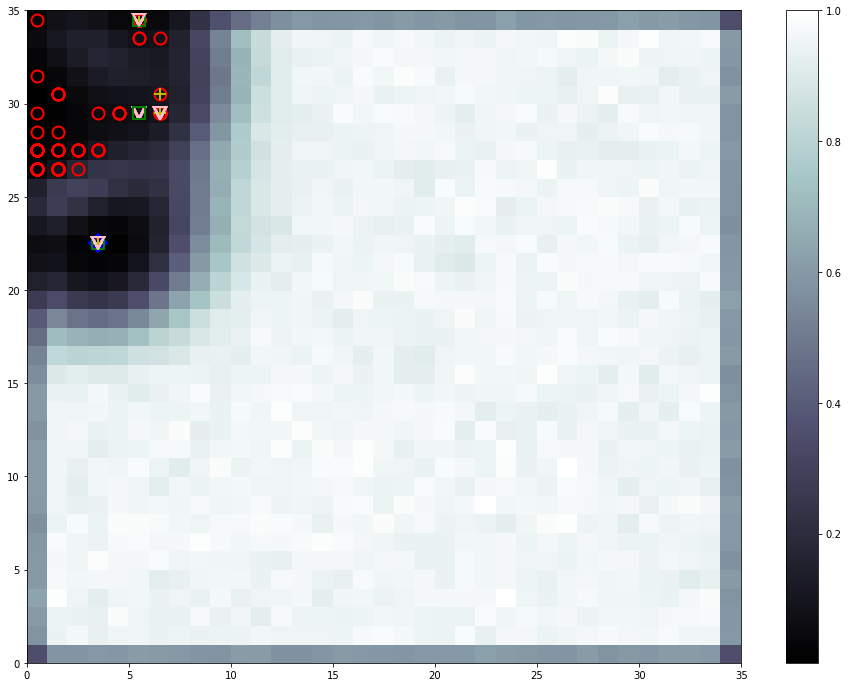

Number of feature:  24
{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e-02, 6.82474004e-05, 2.41595798e-02, ...,
        4.76101030e-01, 3.95947606e-03, 8.69515296e-01],
       [2.88563061e-02, 1.57691574e-04, 2.88269253e-02, ...,
        4.18548874e-01, 3.90994707e-03, 8.94358118e-01],
       ...,
       [2.34251610e-02, 7.04366109e-04, 2.34050645e-02, ...,
        2.73293549e-09, 8.96323185e-03, 9.84741705e-01],
       [2.34311481e-02, 9.34262693e-04, 2.34159891e-02, ...,
        2.91740770e-09, 8.96486503e-03, 9.84939173e-01],
       [2.34353999e-02, 1.16348606e-03, 2.34232322e-02, ...,
        1.39693366e-09, 8.96650609e-03, 9.85113200e-01]]), 'learning_rate': 3.474593566736243, 'sigma': 8.963433140334331, 'x': 46.5741870836718}
1.0267217432464428
{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],

{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e-02, 6.82474004e-05, 2.41595798e-02, ...,
        4.76101030e-01, 3.95947606e-03, 8.69515296e-01],
       [2.88563061e-02, 1.57691574e-04, 2.88269253e-02, ...,
        4.18548874e-01, 3.90994707e-03, 8.94358118e-01],
       ...,
       [2.34251610e-02, 7.04366109e-04, 2.34050645e-02, ...,
        2.73293549e-09, 8.96323185e-03, 9.84741705e-01],
       [2.34311481e-02, 9.34262693e-04, 2.34159891e-02, ...,
        2.91740770e-09, 8.96486503e-03, 9.84939173e-01],
       [2.34353999e-02, 1.16348606e-03, 2.34232322e-02, ...,
        1.39693366e-09, 8.96650609e-03, 9.85113200e-01]]), 'learning_rate': 0.12377962705497347, 'sigma': 6.1489782825117185, 'x': 41.77413729955015}
1.0244545741752509
{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798

{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e-02, 6.82474004e-05, 2.41595798e-02, ...,
        4.76101030e-01, 3.95947606e-03, 8.69515296e-01],
       [2.88563061e-02, 1.57691574e-04, 2.88269253e-02, ...,
        4.18548874e-01, 3.90994707e-03, 8.94358118e-01],
       ...,
       [2.34251610e-02, 7.04366109e-04, 2.34050645e-02, ...,
        2.73293549e-09, 8.96323185e-03, 9.84741705e-01],
       [2.34311481e-02, 9.34262693e-04, 2.34159891e-02, ...,
        2.91740770e-09, 8.96486503e-03, 9.84939173e-01],
       [2.34353999e-02, 1.16348606e-03, 2.34232322e-02, ...,
        1.39693366e-09, 8.96650609e-03, 9.85113200e-01]]), 'learning_rate': 1.9389774349417181, 'sigma': 7.0797409332943815, 'x': 45.637636800517136}
1.0016571365496767
{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798

{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e-02, 6.82474004e-05, 2.41595798e-02, ...,
        4.76101030e-01, 3.95947606e-03, 8.69515296e-01],
       [2.88563061e-02, 1.57691574e-04, 2.88269253e-02, ...,
        4.18548874e-01, 3.90994707e-03, 8.94358118e-01],
       ...,
       [2.34251610e-02, 7.04366109e-04, 2.34050645e-02, ...,
        2.73293549e-09, 8.96323185e-03, 9.84741705e-01],
       [2.34311481e-02, 9.34262693e-04, 2.34159891e-02, ...,
        2.91740770e-09, 8.96486503e-03, 9.84939173e-01],
       [2.34353999e-02, 1.16348606e-03, 2.34232322e-02, ...,
        1.39693366e-09, 8.96650609e-03, 9.85113200e-01]]), 'learning_rate': 2.21091691195646, 'sigma': 9.982186660424853, 'x': 48.1959222271698}
1.0232725552976474
{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e-02,

{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e-02, 6.82474004e-05, 2.41595798e-02, ...,
        4.76101030e-01, 3.95947606e-03, 8.69515296e-01],
       [2.88563061e-02, 1.57691574e-04, 2.88269253e-02, ...,
        4.18548874e-01, 3.90994707e-03, 8.94358118e-01],
       ...,
       [2.34251610e-02, 7.04366109e-04, 2.34050645e-02, ...,
        2.73293549e-09, 8.96323185e-03, 9.84741705e-01],
       [2.34311481e-02, 9.34262693e-04, 2.34159891e-02, ...,
        2.91740770e-09, 8.96486503e-03, 9.84939173e-01],
       [2.34353999e-02, 1.16348606e-03, 2.34232322e-02, ...,
        1.39693366e-09, 8.96650609e-03, 9.85113200e-01]]), 'learning_rate': 0.09762851867721486, 'sigma': 9.128137607891073, 'x': 46.60658038814738}
1.0229768048363028
{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e

{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e-02, 6.82474004e-05, 2.41595798e-02, ...,
        4.76101030e-01, 3.95947606e-03, 8.69515296e-01],
       [2.88563061e-02, 1.57691574e-04, 2.88269253e-02, ...,
        4.18548874e-01, 3.90994707e-03, 8.94358118e-01],
       ...,
       [2.34251610e-02, 7.04366109e-04, 2.34050645e-02, ...,
        2.73293549e-09, 8.96323185e-03, 9.84741705e-01],
       [2.34311481e-02, 9.34262693e-04, 2.34159891e-02, ...,
        2.91740770e-09, 8.96486503e-03, 9.84939173e-01],
       [2.34353999e-02, 1.16348606e-03, 2.34232322e-02, ...,
        1.39693366e-09, 8.96650609e-03, 9.85113200e-01]]), 'learning_rate': 0.3078484100434204, 'sigma': 7.605570657474543, 'x': 37.336145866497226}
0.9990591586400898
{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e

{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e-02, 6.82474004e-05, 2.41595798e-02, ...,
        4.76101030e-01, 3.95947606e-03, 8.69515296e-01],
       [2.88563061e-02, 1.57691574e-04, 2.88269253e-02, ...,
        4.18548874e-01, 3.90994707e-03, 8.94358118e-01],
       ...,
       [2.34251610e-02, 7.04366109e-04, 2.34050645e-02, ...,
        2.73293549e-09, 8.96323185e-03, 9.84741705e-01],
       [2.34311481e-02, 9.34262693e-04, 2.34159891e-02, ...,
        2.91740770e-09, 8.96486503e-03, 9.84939173e-01],
       [2.34353999e-02, 1.16348606e-03, 2.34232322e-02, ...,
        1.39693366e-09, 8.96650609e-03, 9.85113200e-01]]), 'learning_rate': 3.118705336685383, 'sigma': 7.461802634084984, 'x': 49.10187048655687}
1.0050915197892771
{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e-0

{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e-02, 6.82474004e-05, 2.41595798e-02, ...,
        4.76101030e-01, 3.95947606e-03, 8.69515296e-01],
       [2.88563061e-02, 1.57691574e-04, 2.88269253e-02, ...,
        4.18548874e-01, 3.90994707e-03, 8.94358118e-01],
       ...,
       [2.34251610e-02, 7.04366109e-04, 2.34050645e-02, ...,
        2.73293549e-09, 8.96323185e-03, 9.84741705e-01],
       [2.34311481e-02, 9.34262693e-04, 2.34159891e-02, ...,
        2.91740770e-09, 8.96486503e-03, 9.84939173e-01],
       [2.34353999e-02, 1.16348606e-03, 2.34232322e-02, ...,
        1.39693366e-09, 8.96650609e-03, 9.85113200e-01]]), 'learning_rate': 2.2827850375826584, 'sigma': 8.396812333513921, 'x': 45.4020071935146}
1.0084180391103066
{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e-0

{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e-02, 6.82474004e-05, 2.41595798e-02, ...,
        4.76101030e-01, 3.95947606e-03, 8.69515296e-01],
       [2.88563061e-02, 1.57691574e-04, 2.88269253e-02, ...,
        4.18548874e-01, 3.90994707e-03, 8.94358118e-01],
       ...,
       [2.34251610e-02, 7.04366109e-04, 2.34050645e-02, ...,
        2.73293549e-09, 8.96323185e-03, 9.84741705e-01],
       [2.34311481e-02, 9.34262693e-04, 2.34159891e-02, ...,
        2.91740770e-09, 8.96486503e-03, 9.84939173e-01],
       [2.34353999e-02, 1.16348606e-03, 2.34232322e-02, ...,
        1.39693366e-09, 8.96650609e-03, 9.85113200e-01]]), 'learning_rate': 4.867285445404223, 'sigma': 5.757547701729614, 'x': 28.263507942492307}
1.0247209287687011
{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e-

{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e-02, 6.82474004e-05, 2.41595798e-02, ...,
        4.76101030e-01, 3.95947606e-03, 8.69515296e-01],
       [2.88563061e-02, 1.57691574e-04, 2.88269253e-02, ...,
        4.18548874e-01, 3.90994707e-03, 8.94358118e-01],
       ...,
       [2.34251610e-02, 7.04366109e-04, 2.34050645e-02, ...,
        2.73293549e-09, 8.96323185e-03, 9.84741705e-01],
       [2.34311481e-02, 9.34262693e-04, 2.34159891e-02, ...,
        2.91740770e-09, 8.96486503e-03, 9.84939173e-01],
       [2.34353999e-02, 1.16348606e-03, 2.34232322e-02, ...,
        1.39693366e-09, 8.96650609e-03, 9.85113200e-01]]), 'learning_rate': 2.677687554607513, 'sigma': 9.470755279222892, 'x': 48.79952342274622}
1.0133193306213786
{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e-0

{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e-02, 6.82474004e-05, 2.41595798e-02, ...,
        4.76101030e-01, 3.95947606e-03, 8.69515296e-01],
       [2.88563061e-02, 1.57691574e-04, 2.88269253e-02, ...,
        4.18548874e-01, 3.90994707e-03, 8.94358118e-01],
       ...,
       [2.34251610e-02, 7.04366109e-04, 2.34050645e-02, ...,
        2.73293549e-09, 8.96323185e-03, 9.84741705e-01],
       [2.34311481e-02, 9.34262693e-04, 2.34159891e-02, ...,
        2.91740770e-09, 8.96486503e-03, 9.84939173e-01],
       [2.34353999e-02, 1.16348606e-03, 2.34232322e-02, ...,
        1.39693366e-09, 8.96650609e-03, 9.85113200e-01]]), 'learning_rate': 1.1244528718949625, 'sigma': 8.212827804599964, 'x': 34.48319484085699}
1.0135485932436976
{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e-

{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e-02, 6.82474004e-05, 2.41595798e-02, ...,
        4.76101030e-01, 3.95947606e-03, 8.69515296e-01],
       [2.88563061e-02, 1.57691574e-04, 2.88269253e-02, ...,
        4.18548874e-01, 3.90994707e-03, 8.94358118e-01],
       ...,
       [2.34251610e-02, 7.04366109e-04, 2.34050645e-02, ...,
        2.73293549e-09, 8.96323185e-03, 9.84741705e-01],
       [2.34311481e-02, 9.34262693e-04, 2.34159891e-02, ...,
        2.91740770e-09, 8.96486503e-03, 9.84939173e-01],
       [2.34353999e-02, 1.16348606e-03, 2.34232322e-02, ...,
        1.39693366e-09, 8.96650609e-03, 9.85113200e-01]]), 'learning_rate': 1.6146290686856086, 'sigma': 5.776561892001595, 'x': 49.30196835334125}
0.9933476382548848
{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e-

{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e-02, 6.82474004e-05, 2.41595798e-02, ...,
        4.76101030e-01, 3.95947606e-03, 8.69515296e-01],
       [2.88563061e-02, 1.57691574e-04, 2.88269253e-02, ...,
        4.18548874e-01, 3.90994707e-03, 8.94358118e-01],
       ...,
       [2.34251610e-02, 7.04366109e-04, 2.34050645e-02, ...,
        2.73293549e-09, 8.96323185e-03, 9.84741705e-01],
       [2.34311481e-02, 9.34262693e-04, 2.34159891e-02, ...,
        2.91740770e-09, 8.96486503e-03, 9.84939173e-01],
       [2.34353999e-02, 1.16348606e-03, 2.34232322e-02, ...,
        1.39693366e-09, 8.96650609e-03, 9.85113200e-01]]), 'learning_rate': 1.4745341526972437, 'sigma': 5.077974761836963, 'x': 47.14287204534866}
1.0234668915210066
{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e-

{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e-02, 6.82474004e-05, 2.41595798e-02, ...,
        4.76101030e-01, 3.95947606e-03, 8.69515296e-01],
       [2.88563061e-02, 1.57691574e-04, 2.88269253e-02, ...,
        4.18548874e-01, 3.90994707e-03, 8.94358118e-01],
       ...,
       [2.34251610e-02, 7.04366109e-04, 2.34050645e-02, ...,
        2.73293549e-09, 8.96323185e-03, 9.84741705e-01],
       [2.34311481e-02, 9.34262693e-04, 2.34159891e-02, ...,
        2.91740770e-09, 8.96486503e-03, 9.84939173e-01],
       [2.34353999e-02, 1.16348606e-03, 2.34232322e-02, ...,
        1.39693366e-09, 8.96650609e-03, 9.85113200e-01]]), 'learning_rate': 0.26271806643778484, 'sigma': 5.279066083606498, 'x': 45.27423721366291}
1.0243725977892344
{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e

{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e-02, 6.82474004e-05, 2.41595798e-02, ...,
        4.76101030e-01, 3.95947606e-03, 8.69515296e-01],
       [2.88563061e-02, 1.57691574e-04, 2.88269253e-02, ...,
        4.18548874e-01, 3.90994707e-03, 8.94358118e-01],
       ...,
       [2.34251610e-02, 7.04366109e-04, 2.34050645e-02, ...,
        2.73293549e-09, 8.96323185e-03, 9.84741705e-01],
       [2.34311481e-02, 9.34262693e-04, 2.34159891e-02, ...,
        2.91740770e-09, 8.96486503e-03, 9.84939173e-01],
       [2.34353999e-02, 1.16348606e-03, 2.34232322e-02, ...,
        1.39693366e-09, 8.96650609e-03, 9.85113200e-01]]), 'learning_rate': 1.721096734543027, 'sigma': 5.527952451383281, 'x': 44.28325073723}
1.0271202521722047
{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e-02, 

{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e-02, 6.82474004e-05, 2.41595798e-02, ...,
        4.76101030e-01, 3.95947606e-03, 8.69515296e-01],
       [2.88563061e-02, 1.57691574e-04, 2.88269253e-02, ...,
        4.18548874e-01, 3.90994707e-03, 8.94358118e-01],
       ...,
       [2.34251610e-02, 7.04366109e-04, 2.34050645e-02, ...,
        2.73293549e-09, 8.96323185e-03, 9.84741705e-01],
       [2.34311481e-02, 9.34262693e-04, 2.34159891e-02, ...,
        2.91740770e-09, 8.96486503e-03, 9.84939173e-01],
       [2.34353999e-02, 1.16348606e-03, 2.34232322e-02, ...,
        1.39693366e-09, 8.96650609e-03, 9.85113200e-01]]), 'learning_rate': 0.548225776297024, 'sigma': 7.08217631383133, 'x': 46.052254006339574}
1.0046533287397663
{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e-0

{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e-02, 6.82474004e-05, 2.41595798e-02, ...,
        4.76101030e-01, 3.95947606e-03, 8.69515296e-01],
       [2.88563061e-02, 1.57691574e-04, 2.88269253e-02, ...,
        4.18548874e-01, 3.90994707e-03, 8.94358118e-01],
       ...,
       [2.34251610e-02, 7.04366109e-04, 2.34050645e-02, ...,
        2.73293549e-09, 8.96323185e-03, 9.84741705e-01],
       [2.34311481e-02, 9.34262693e-04, 2.34159891e-02, ...,
        2.91740770e-09, 8.96486503e-03, 9.84939173e-01],
       [2.34353999e-02, 1.16348606e-03, 2.34232322e-02, ...,
        1.39693366e-09, 8.96650609e-03, 9.85113200e-01]]), 'learning_rate': 1.6407905716863778, 'sigma': 5.341308689980015, 'x': 47.55925316940235}
0.993522518471518
{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e-0

{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e-02, 6.82474004e-05, 2.41595798e-02, ...,
        4.76101030e-01, 3.95947606e-03, 8.69515296e-01],
       [2.88563061e-02, 1.57691574e-04, 2.88269253e-02, ...,
        4.18548874e-01, 3.90994707e-03, 8.94358118e-01],
       ...,
       [2.34251610e-02, 7.04366109e-04, 2.34050645e-02, ...,
        2.73293549e-09, 8.96323185e-03, 9.84741705e-01],
       [2.34311481e-02, 9.34262693e-04, 2.34159891e-02, ...,
        2.91740770e-09, 8.96486503e-03, 9.84939173e-01],
       [2.34353999e-02, 1.16348606e-03, 2.34232322e-02, ...,
        1.39693366e-09, 8.96650609e-03, 9.85113200e-01]]), 'learning_rate': 0.912504698478515, 'sigma': 6.656844056696809, 'x': 49.49144291672098}
0.9854799489197277
{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e-0

{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e-02, 6.82474004e-05, 2.41595798e-02, ...,
        4.76101030e-01, 3.95947606e-03, 8.69515296e-01],
       [2.88563061e-02, 1.57691574e-04, 2.88269253e-02, ...,
        4.18548874e-01, 3.90994707e-03, 8.94358118e-01],
       ...,
       [2.34251610e-02, 7.04366109e-04, 2.34050645e-02, ...,
        2.73293549e-09, 8.96323185e-03, 9.84741705e-01],
       [2.34311481e-02, 9.34262693e-04, 2.34159891e-02, ...,
        2.91740770e-09, 8.96486503e-03, 9.84939173e-01],
       [2.34353999e-02, 1.16348606e-03, 2.34232322e-02, ...,
        1.39693366e-09, 8.96650609e-03, 9.85113200e-01]]), 'learning_rate': 3.317561612398121, 'sigma': 6.064794425699641, 'x': 21.270710540303593}
1.0560329079638548
{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e-

{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e-02, 6.82474004e-05, 2.41595798e-02, ...,
        4.76101030e-01, 3.95947606e-03, 8.69515296e-01],
       [2.88563061e-02, 1.57691574e-04, 2.88269253e-02, ...,
        4.18548874e-01, 3.90994707e-03, 8.94358118e-01],
       ...,
       [2.34251610e-02, 7.04366109e-04, 2.34050645e-02, ...,
        2.73293549e-09, 8.96323185e-03, 9.84741705e-01],
       [2.34311481e-02, 9.34262693e-04, 2.34159891e-02, ...,
        2.91740770e-09, 8.96486503e-03, 9.84939173e-01],
       [2.34353999e-02, 1.16348606e-03, 2.34232322e-02, ...,
        1.39693366e-09, 8.96650609e-03, 9.85113200e-01]]), 'learning_rate': 3.459554770737263, 'sigma': 6.58538733873167, 'x': 22.593318824822603}
1.0408193609166347
{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e-0

{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e-02, 6.82474004e-05, 2.41595798e-02, ...,
        4.76101030e-01, 3.95947606e-03, 8.69515296e-01],
       [2.88563061e-02, 1.57691574e-04, 2.88269253e-02, ...,
        4.18548874e-01, 3.90994707e-03, 8.94358118e-01],
       ...,
       [2.34251610e-02, 7.04366109e-04, 2.34050645e-02, ...,
        2.73293549e-09, 8.96323185e-03, 9.84741705e-01],
       [2.34311481e-02, 9.34262693e-04, 2.34159891e-02, ...,
        2.91740770e-09, 8.96486503e-03, 9.84939173e-01],
       [2.34353999e-02, 1.16348606e-03, 2.34232322e-02, ...,
        1.39693366e-09, 8.96650609e-03, 9.85113200e-01]]), 'learning_rate': 2.413418093857358, 'sigma': 5.316877085015953, 'x': 43.48166391122804}
1.0204970260235229
{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e-0

{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e-02, 6.82474004e-05, 2.41595798e-02, ...,
        4.76101030e-01, 3.95947606e-03, 8.69515296e-01],
       [2.88563061e-02, 1.57691574e-04, 2.88269253e-02, ...,
        4.18548874e-01, 3.90994707e-03, 8.94358118e-01],
       ...,
       [2.34251610e-02, 7.04366109e-04, 2.34050645e-02, ...,
        2.73293549e-09, 8.96323185e-03, 9.84741705e-01],
       [2.34311481e-02, 9.34262693e-04, 2.34159891e-02, ...,
        2.91740770e-09, 8.96486503e-03, 9.84939173e-01],
       [2.34353999e-02, 1.16348606e-03, 2.34232322e-02, ...,
        1.39693366e-09, 8.96650609e-03, 9.85113200e-01]]), 'learning_rate': 1.4885376926256055, 'sigma': 5.006882208462806, 'x': 43.97127588373349}
1.0225376815706801
{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e-

{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e-02, 6.82474004e-05, 2.41595798e-02, ...,
        4.76101030e-01, 3.95947606e-03, 8.69515296e-01],
       [2.88563061e-02, 1.57691574e-04, 2.88269253e-02, ...,
        4.18548874e-01, 3.90994707e-03, 8.94358118e-01],
       ...,
       [2.34251610e-02, 7.04366109e-04, 2.34050645e-02, ...,
        2.73293549e-09, 8.96323185e-03, 9.84741705e-01],
       [2.34311481e-02, 9.34262693e-04, 2.34159891e-02, ...,
        2.91740770e-09, 8.96486503e-03, 9.84939173e-01],
       [2.34353999e-02, 1.16348606e-03, 2.34232322e-02, ...,
        1.39693366e-09, 8.96650609e-03, 9.85113200e-01]]), 'learning_rate': 1.4144698206305837, 'sigma': 5.538354001045043, 'x': 43.02457032245526}
1.0165451548942595
{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e-

{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e-02, 6.82474004e-05, 2.41595798e-02, ...,
        4.76101030e-01, 3.95947606e-03, 8.69515296e-01],
       [2.88563061e-02, 1.57691574e-04, 2.88269253e-02, ...,
        4.18548874e-01, 3.90994707e-03, 8.94358118e-01],
       ...,
       [2.34251610e-02, 7.04366109e-04, 2.34050645e-02, ...,
        2.73293549e-09, 8.96323185e-03, 9.84741705e-01],
       [2.34311481e-02, 9.34262693e-04, 2.34159891e-02, ...,
        2.91740770e-09, 8.96486503e-03, 9.84939173e-01],
       [2.34353999e-02, 1.16348606e-03, 2.34232322e-02, ...,
        1.39693366e-09, 8.96650609e-03, 9.85113200e-01]]), 'learning_rate': 0.3556510320791495, 'sigma': 5.623780241126048, 'x': 45.03373845255173}
1.0373329977795727
{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e-

{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e-02, 6.82474004e-05, 2.41595798e-02, ...,
        4.76101030e-01, 3.95947606e-03, 8.69515296e-01],
       [2.88563061e-02, 1.57691574e-04, 2.88269253e-02, ...,
        4.18548874e-01, 3.90994707e-03, 8.94358118e-01],
       ...,
       [2.34251610e-02, 7.04366109e-04, 2.34050645e-02, ...,
        2.73293549e-09, 8.96323185e-03, 9.84741705e-01],
       [2.34311481e-02, 9.34262693e-04, 2.34159891e-02, ...,
        2.91740770e-09, 8.96486503e-03, 9.84939173e-01],
       [2.34353999e-02, 1.16348606e-03, 2.34232322e-02, ...,
        1.39693366e-09, 8.96650609e-03, 9.85113200e-01]]), 'learning_rate': 3.055359782485367, 'sigma': 6.868881658944799, 'x': 37.5294237557696}
1.0263147775224966
{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e-02

{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e-02, 6.82474004e-05, 2.41595798e-02, ...,
        4.76101030e-01, 3.95947606e-03, 8.69515296e-01],
       [2.88563061e-02, 1.57691574e-04, 2.88269253e-02, ...,
        4.18548874e-01, 3.90994707e-03, 8.94358118e-01],
       ...,
       [2.34251610e-02, 7.04366109e-04, 2.34050645e-02, ...,
        2.73293549e-09, 8.96323185e-03, 9.84741705e-01],
       [2.34311481e-02, 9.34262693e-04, 2.34159891e-02, ...,
        2.91740770e-09, 8.96486503e-03, 9.84939173e-01],
       [2.34353999e-02, 1.16348606e-03, 2.34232322e-02, ...,
        1.39693366e-09, 8.96650609e-03, 9.85113200e-01]]), 'learning_rate': 2.9668457059847313, 'sigma': 5.979271341156278, 'x': 46.69409296598815}
1.0188509637398173
{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e-

{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e-02, 6.82474004e-05, 2.41595798e-02, ...,
        4.76101030e-01, 3.95947606e-03, 8.69515296e-01],
       [2.88563061e-02, 1.57691574e-04, 2.88269253e-02, ...,
        4.18548874e-01, 3.90994707e-03, 8.94358118e-01],
       ...,
       [2.34251610e-02, 7.04366109e-04, 2.34050645e-02, ...,
        2.73293549e-09, 8.96323185e-03, 9.84741705e-01],
       [2.34311481e-02, 9.34262693e-04, 2.34159891e-02, ...,
        2.91740770e-09, 8.96486503e-03, 9.84939173e-01],
       [2.34353999e-02, 1.16348606e-03, 2.34232322e-02, ...,
        1.39693366e-09, 8.96650609e-03, 9.85113200e-01]]), 'learning_rate': 3.1520563543146927, 'sigma': 5.174310566955501, 'x': 48.65717743480728}
1.002133549873004
{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e-0

{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e-02, 6.82474004e-05, 2.41595798e-02, ...,
        4.76101030e-01, 3.95947606e-03, 8.69515296e-01],
       [2.88563061e-02, 1.57691574e-04, 2.88269253e-02, ...,
        4.18548874e-01, 3.90994707e-03, 8.94358118e-01],
       ...,
       [2.34251610e-02, 7.04366109e-04, 2.34050645e-02, ...,
        2.73293549e-09, 8.96323185e-03, 9.84741705e-01],
       [2.34311481e-02, 9.34262693e-04, 2.34159891e-02, ...,
        2.91740770e-09, 8.96486503e-03, 9.84939173e-01],
       [2.34353999e-02, 1.16348606e-03, 2.34232322e-02, ...,
        1.39693366e-09, 8.96650609e-03, 9.85113200e-01]]), 'learning_rate': 2.2967560968006824, 'sigma': 7.106969170685341, 'x': 41.2726925020733}
1.0085804543571775
{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e-0

{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e-02, 6.82474004e-05, 2.41595798e-02, ...,
        4.76101030e-01, 3.95947606e-03, 8.69515296e-01],
       [2.88563061e-02, 1.57691574e-04, 2.88269253e-02, ...,
        4.18548874e-01, 3.90994707e-03, 8.94358118e-01],
       ...,
       [2.34251610e-02, 7.04366109e-04, 2.34050645e-02, ...,
        2.73293549e-09, 8.96323185e-03, 9.84741705e-01],
       [2.34311481e-02, 9.34262693e-04, 2.34159891e-02, ...,
        2.91740770e-09, 8.96486503e-03, 9.84939173e-01],
       [2.34353999e-02, 1.16348606e-03, 2.34232322e-02, ...,
        1.39693366e-09, 8.96650609e-03, 9.85113200e-01]]), 'learning_rate': 1.6729496517558042, 'sigma': 6.449696791123229, 'x': 47.807630921939996}
1.0234381607122063
{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e

{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e-02, 6.82474004e-05, 2.41595798e-02, ...,
        4.76101030e-01, 3.95947606e-03, 8.69515296e-01],
       [2.88563061e-02, 1.57691574e-04, 2.88269253e-02, ...,
        4.18548874e-01, 3.90994707e-03, 8.94358118e-01],
       ...,
       [2.34251610e-02, 7.04366109e-04, 2.34050645e-02, ...,
        2.73293549e-09, 8.96323185e-03, 9.84741705e-01],
       [2.34311481e-02, 9.34262693e-04, 2.34159891e-02, ...,
        2.91740770e-09, 8.96486503e-03, 9.84939173e-01],
       [2.34353999e-02, 1.16348606e-03, 2.34232322e-02, ...,
        1.39693366e-09, 8.96650609e-03, 9.85113200e-01]]), 'learning_rate': 2.4651113941471903, 'sigma': 6.242754986996185, 'x': 49.964880872845086}
1.0309435836492344
{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e

{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e-02, 6.82474004e-05, 2.41595798e-02, ...,
        4.76101030e-01, 3.95947606e-03, 8.69515296e-01],
       [2.88563061e-02, 1.57691574e-04, 2.88269253e-02, ...,
        4.18548874e-01, 3.90994707e-03, 8.94358118e-01],
       ...,
       [2.34251610e-02, 7.04366109e-04, 2.34050645e-02, ...,
        2.73293549e-09, 8.96323185e-03, 9.84741705e-01],
       [2.34311481e-02, 9.34262693e-04, 2.34159891e-02, ...,
        2.91740770e-09, 8.96486503e-03, 9.84939173e-01],
       [2.34353999e-02, 1.16348606e-03, 2.34232322e-02, ...,
        1.39693366e-09, 8.96650609e-03, 9.85113200e-01]]), 'learning_rate': 3.8980827365273907, 'sigma': 5.687841298954262, 'x': 46.07762142825573}
0.9805650541866211
{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e-

{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e-02, 6.82474004e-05, 2.41595798e-02, ...,
        4.76101030e-01, 3.95947606e-03, 8.69515296e-01],
       [2.88563061e-02, 1.57691574e-04, 2.88269253e-02, ...,
        4.18548874e-01, 3.90994707e-03, 8.94358118e-01],
       ...,
       [2.34251610e-02, 7.04366109e-04, 2.34050645e-02, ...,
        2.73293549e-09, 8.96323185e-03, 9.84741705e-01],
       [2.34311481e-02, 9.34262693e-04, 2.34159891e-02, ...,
        2.91740770e-09, 8.96486503e-03, 9.84939173e-01],
       [2.34353999e-02, 1.16348606e-03, 2.34232322e-02, ...,
        1.39693366e-09, 8.96650609e-03, 9.85113200e-01]]), 'learning_rate': 2.6110264999133377, 'sigma': 5.640184520441891, 'x': 45.468532205056945}
1.0117200800318589
{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e

{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e-02, 6.82474004e-05, 2.41595798e-02, ...,
        4.76101030e-01, 3.95947606e-03, 8.69515296e-01],
       [2.88563061e-02, 1.57691574e-04, 2.88269253e-02, ...,
        4.18548874e-01, 3.90994707e-03, 8.94358118e-01],
       ...,
       [2.34251610e-02, 7.04366109e-04, 2.34050645e-02, ...,
        2.73293549e-09, 8.96323185e-03, 9.84741705e-01],
       [2.34311481e-02, 9.34262693e-04, 2.34159891e-02, ...,
        2.91740770e-09, 8.96486503e-03, 9.84939173e-01],
       [2.34353999e-02, 1.16348606e-03, 2.34232322e-02, ...,
        1.39693366e-09, 8.96650609e-03, 9.85113200e-01]]), 'learning_rate': 1.453220079084181, 'sigma': 5.684753904736845, 'x': 41.75142383712403}
1.0120962965353202
{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e-0

{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e-02, 6.82474004e-05, 2.41595798e-02, ...,
        4.76101030e-01, 3.95947606e-03, 8.69515296e-01],
       [2.88563061e-02, 1.57691574e-04, 2.88269253e-02, ...,
        4.18548874e-01, 3.90994707e-03, 8.94358118e-01],
       ...,
       [2.34251610e-02, 7.04366109e-04, 2.34050645e-02, ...,
        2.73293549e-09, 8.96323185e-03, 9.84741705e-01],
       [2.34311481e-02, 9.34262693e-04, 2.34159891e-02, ...,
        2.91740770e-09, 8.96486503e-03, 9.84939173e-01],
       [2.34353999e-02, 1.16348606e-03, 2.34232322e-02, ...,
        1.39693366e-09, 8.96650609e-03, 9.85113200e-01]]), 'learning_rate': 2.4850798437047477, 'sigma': 5.043637966162465, 'x': 48.56042849790992}
1.0107332684760688
{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e-

{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e-02, 6.82474004e-05, 2.41595798e-02, ...,
        4.76101030e-01, 3.95947606e-03, 8.69515296e-01],
       [2.88563061e-02, 1.57691574e-04, 2.88269253e-02, ...,
        4.18548874e-01, 3.90994707e-03, 8.94358118e-01],
       ...,
       [2.34251610e-02, 7.04366109e-04, 2.34050645e-02, ...,
        2.73293549e-09, 8.96323185e-03, 9.84741705e-01],
       [2.34311481e-02, 9.34262693e-04, 2.34159891e-02, ...,
        2.91740770e-09, 8.96486503e-03, 9.84939173e-01],
       [2.34353999e-02, 1.16348606e-03, 2.34232322e-02, ...,
        1.39693366e-09, 8.96650609e-03, 9.85113200e-01]]), 'learning_rate': 0.3507482212214803, 'sigma': 6.034348554220966, 'x': 49.9687393291331}
1.0110179925951421
{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e-0

{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e-02, 6.82474004e-05, 2.41595798e-02, ...,
        4.76101030e-01, 3.95947606e-03, 8.69515296e-01],
       [2.88563061e-02, 1.57691574e-04, 2.88269253e-02, ...,
        4.18548874e-01, 3.90994707e-03, 8.94358118e-01],
       ...,
       [2.34251610e-02, 7.04366109e-04, 2.34050645e-02, ...,
        2.73293549e-09, 8.96323185e-03, 9.84741705e-01],
       [2.34311481e-02, 9.34262693e-04, 2.34159891e-02, ...,
        2.91740770e-09, 8.96486503e-03, 9.84939173e-01],
       [2.34353999e-02, 1.16348606e-03, 2.34232322e-02, ...,
        1.39693366e-09, 8.96650609e-03, 9.85113200e-01]]), 'learning_rate': 0.6334052492635376, 'sigma': 5.613779326323002, 'x': 42.6658524220951}
1.007462666421824
{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e-02

{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e-02, 6.82474004e-05, 2.41595798e-02, ...,
        4.76101030e-01, 3.95947606e-03, 8.69515296e-01],
       [2.88563061e-02, 1.57691574e-04, 2.88269253e-02, ...,
        4.18548874e-01, 3.90994707e-03, 8.94358118e-01],
       ...,
       [2.34251610e-02, 7.04366109e-04, 2.34050645e-02, ...,
        2.73293549e-09, 8.96323185e-03, 9.84741705e-01],
       [2.34311481e-02, 9.34262693e-04, 2.34159891e-02, ...,
        2.91740770e-09, 8.96486503e-03, 9.84939173e-01],
       [2.34353999e-02, 1.16348606e-03, 2.34232322e-02, ...,
        1.39693366e-09, 8.96650609e-03, 9.85113200e-01]]), 'learning_rate': 0.8811193710933629, 'sigma': 8.266814065751973, 'x': 40.28519169240356}
0.9990810164434759
{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e-

{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e-02, 6.82474004e-05, 2.41595798e-02, ...,
        4.76101030e-01, 3.95947606e-03, 8.69515296e-01],
       [2.88563061e-02, 1.57691574e-04, 2.88269253e-02, ...,
        4.18548874e-01, 3.90994707e-03, 8.94358118e-01],
       ...,
       [2.34251610e-02, 7.04366109e-04, 2.34050645e-02, ...,
        2.73293549e-09, 8.96323185e-03, 9.84741705e-01],
       [2.34311481e-02, 9.34262693e-04, 2.34159891e-02, ...,
        2.91740770e-09, 8.96486503e-03, 9.84939173e-01],
       [2.34353999e-02, 1.16348606e-03, 2.34232322e-02, ...,
        1.39693366e-09, 8.96650609e-03, 9.85113200e-01]]), 'learning_rate': 1.0660390432055782, 'sigma': 5.985856938881823, 'x': 43.37031218741389}
1.007282445160701
{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e-0

{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e-02, 6.82474004e-05, 2.41595798e-02, ...,
        4.76101030e-01, 3.95947606e-03, 8.69515296e-01],
       [2.88563061e-02, 1.57691574e-04, 2.88269253e-02, ...,
        4.18548874e-01, 3.90994707e-03, 8.94358118e-01],
       ...,
       [2.34251610e-02, 7.04366109e-04, 2.34050645e-02, ...,
        2.73293549e-09, 8.96323185e-03, 9.84741705e-01],
       [2.34311481e-02, 9.34262693e-04, 2.34159891e-02, ...,
        2.91740770e-09, 8.96486503e-03, 9.84939173e-01],
       [2.34353999e-02, 1.16348606e-03, 2.34232322e-02, ...,
        1.39693366e-09, 8.96650609e-03, 9.85113200e-01]]), 'learning_rate': 0.7323338707965752, 'sigma': 5.151225985417848, 'x': 44.69794225806807}
1.018531935862185
{'data_benign': array([[1.78212781e-08, 2.97021301e-10, 1.78212781e-08, ...,
        0.00000000e+00, 4.47213595e-01, 0.00000000e+00],
       [2.41595798e-0

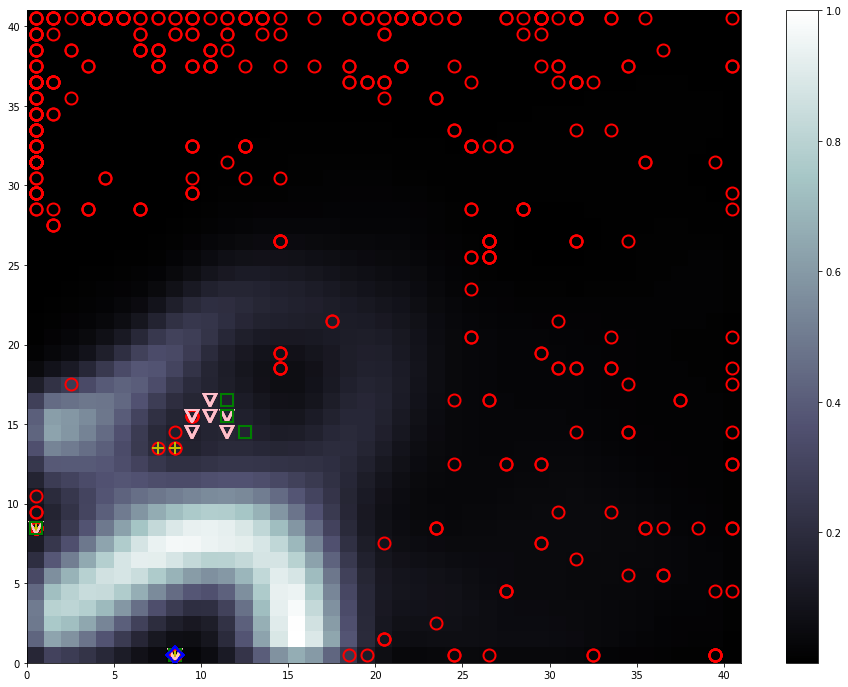

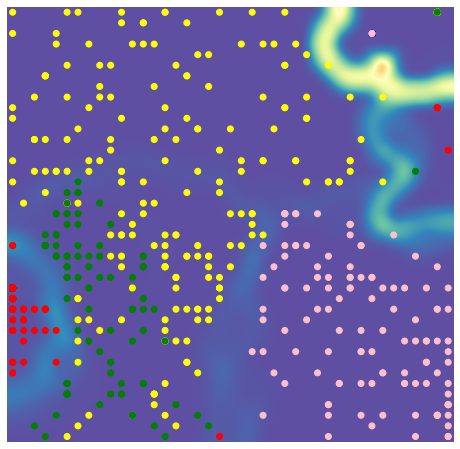

/home/ladin/Projects/research/botnet-traffic-analysis/som_anomaly_detection/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]


sd_benign: 0.03539278577032927, mean_benign: 0.007742434677265527, lim_benign: 0.11392079198825333, pct_benign: 0.2783096637826446


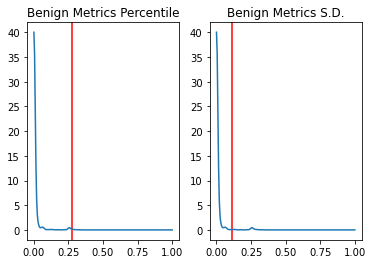

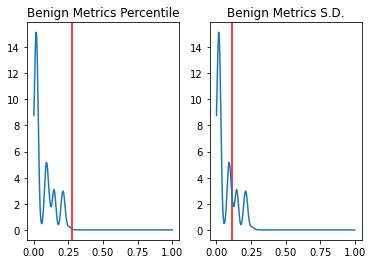

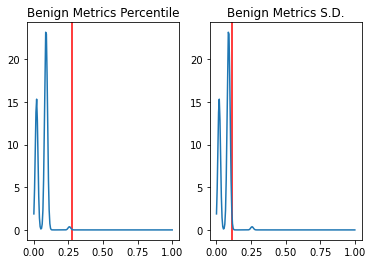

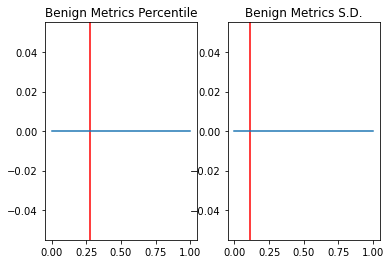

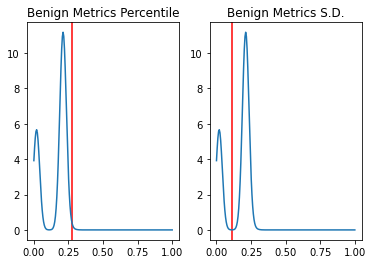

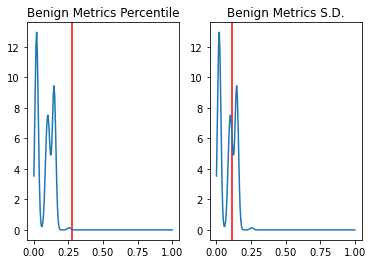

Anomaly detection
benign
Determined:  2.0 % as anomaly
all alnomalies
Determined:  23.033333333333335 % as anomaly
ack
Determined:  0.8999999999999999 % as anomaly
scan
Determined:  0.0 % as anomaly
syn
Determined:  67.80000000000001 % as anomaly
udp
Determined:  34.300000000000004 % as anomaly


In [4]:
main(choose_folder=nbaiot_1K_data_path, choose_index=1)

(10000, 115) (10000, 115) (10000, 115) (10000, 115) (20000, 115)


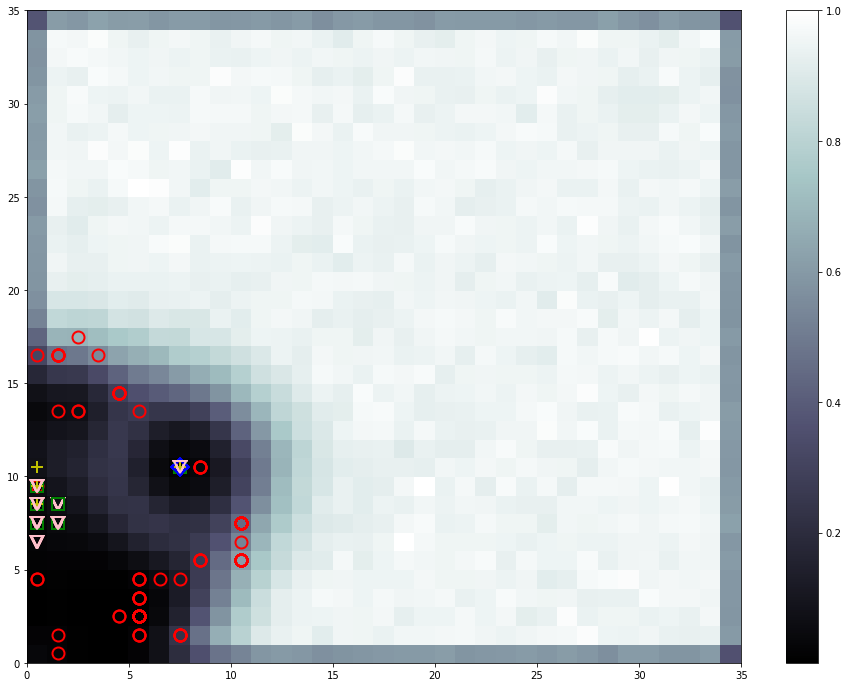

Number of feature:  25
{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 2.41595798e-02, 6.82474004e-05, ...,
        3.95947606e-03, 8.69515296e-01, 2.34950340e-02],
       [2.86509183e-03, 2.88416364e-02, 1.57691574e-04, ...,
        3.90994707e-03, 8.94358118e-01, 2.78351415e-02],
       ...,
       [4.07486849e-03, 1.03222378e-01, 4.61287454e-03, ...,
        1.27337025e-02, 7.84885465e-02, 1.00632377e-01],
       [5.30578475e-07, 5.67763845e-02, 1.13890946e-03, ...,
        1.11553024e-02, 7.09889726e-02, 5.67666998e-02],
       [0.00000000e+00, 9.80933098e-02, 1.00095216e-03, ...,
        1.29662108e-02, 8.35483724e-02, 9.80933098e-02]]), 'learning_rate': 3.760969433180829, 'sigma': 9.096047990103024, 'x': 36.863533026175354}
1.0118755105349755
{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08

{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 2.41595798e-02, 6.82474004e-05, ...,
        3.95947606e-03, 8.69515296e-01, 2.34950340e-02],
       [2.86509183e-03, 2.88416364e-02, 1.57691574e-04, ...,
        3.90994707e-03, 8.94358118e-01, 2.78351415e-02],
       ...,
       [4.07486849e-03, 1.03222378e-01, 4.61287454e-03, ...,
        1.27337025e-02, 7.84885465e-02, 1.00632377e-01],
       [5.30578475e-07, 5.67763845e-02, 1.13890946e-03, ...,
        1.11553024e-02, 7.09889726e-02, 5.67666998e-02],
       [0.00000000e+00, 9.80933098e-02, 1.00095216e-03, ...,
        1.29662108e-02, 8.35483724e-02, 9.80933098e-02]]), 'learning_rate': 4.430670007232731, 'sigma': 8.087990849920608, 'x': 35.60222358770056}
1.0186588218011905
{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+0

{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 2.41595798e-02, 6.82474004e-05, ...,
        3.95947606e-03, 8.69515296e-01, 2.34950340e-02],
       [2.86509183e-03, 2.88416364e-02, 1.57691574e-04, ...,
        3.90994707e-03, 8.94358118e-01, 2.78351415e-02],
       ...,
       [4.07486849e-03, 1.03222378e-01, 4.61287454e-03, ...,
        1.27337025e-02, 7.84885465e-02, 1.00632377e-01],
       [5.30578475e-07, 5.67763845e-02, 1.13890946e-03, ...,
        1.11553024e-02, 7.09889726e-02, 5.67666998e-02],
       [0.00000000e+00, 9.80933098e-02, 1.00095216e-03, ...,
        1.29662108e-02, 8.35483724e-02, 9.80933098e-02]]), 'learning_rate': 1.0353412450548212, 'sigma': 6.691396897765809, 'x': 47.344910777128916}
1.0226430831739652
{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e

{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 2.41595798e-02, 6.82474004e-05, ...,
        3.95947606e-03, 8.69515296e-01, 2.34950340e-02],
       [2.86509183e-03, 2.88416364e-02, 1.57691574e-04, ...,
        3.90994707e-03, 8.94358118e-01, 2.78351415e-02],
       ...,
       [4.07486849e-03, 1.03222378e-01, 4.61287454e-03, ...,
        1.27337025e-02, 7.84885465e-02, 1.00632377e-01],
       [5.30578475e-07, 5.67763845e-02, 1.13890946e-03, ...,
        1.11553024e-02, 7.09889726e-02, 5.67666998e-02],
       [0.00000000e+00, 9.80933098e-02, 1.00095216e-03, ...,
        1.29662108e-02, 8.35483724e-02, 9.80933098e-02]]), 'learning_rate': 1.6478882831907806, 'sigma': 5.54310498510636, 'x': 44.63261068870091}
1.0091069006220226
{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+0

{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 2.41595798e-02, 6.82474004e-05, ...,
        3.95947606e-03, 8.69515296e-01, 2.34950340e-02],
       [2.86509183e-03, 2.88416364e-02, 1.57691574e-04, ...,
        3.90994707e-03, 8.94358118e-01, 2.78351415e-02],
       ...,
       [4.07486849e-03, 1.03222378e-01, 4.61287454e-03, ...,
        1.27337025e-02, 7.84885465e-02, 1.00632377e-01],
       [5.30578475e-07, 5.67763845e-02, 1.13890946e-03, ...,
        1.11553024e-02, 7.09889726e-02, 5.67666998e-02],
       [0.00000000e+00, 9.80933098e-02, 1.00095216e-03, ...,
        1.29662108e-02, 8.35483724e-02, 9.80933098e-02]]), 'learning_rate': 0.2457886359671682, 'sigma': 6.878359729473874, 'x': 42.73570891741442}
1.0253512251989352
{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+

{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 2.41595798e-02, 6.82474004e-05, ...,
        3.95947606e-03, 8.69515296e-01, 2.34950340e-02],
       [2.86509183e-03, 2.88416364e-02, 1.57691574e-04, ...,
        3.90994707e-03, 8.94358118e-01, 2.78351415e-02],
       ...,
       [4.07486849e-03, 1.03222378e-01, 4.61287454e-03, ...,
        1.27337025e-02, 7.84885465e-02, 1.00632377e-01],
       [5.30578475e-07, 5.67763845e-02, 1.13890946e-03, ...,
        1.11553024e-02, 7.09889726e-02, 5.67666998e-02],
       [0.00000000e+00, 9.80933098e-02, 1.00095216e-03, ...,
        1.29662108e-02, 8.35483724e-02, 9.80933098e-02]]), 'learning_rate': 1.0931715416026366, 'sigma': 5.017393295627306, 'x': 45.33945178387221}
1.0236091358126966
{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+

{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 2.41595798e-02, 6.82474004e-05, ...,
        3.95947606e-03, 8.69515296e-01, 2.34950340e-02],
       [2.86509183e-03, 2.88416364e-02, 1.57691574e-04, ...,
        3.90994707e-03, 8.94358118e-01, 2.78351415e-02],
       ...,
       [4.07486849e-03, 1.03222378e-01, 4.61287454e-03, ...,
        1.27337025e-02, 7.84885465e-02, 1.00632377e-01],
       [5.30578475e-07, 5.67763845e-02, 1.13890946e-03, ...,
        1.11553024e-02, 7.09889726e-02, 5.67666998e-02],
       [0.00000000e+00, 9.80933098e-02, 1.00095216e-03, ...,
        1.29662108e-02, 8.35483724e-02, 9.80933098e-02]]), 'learning_rate': 1.2609834837748448, 'sigma': 6.0924658459036305, 'x': 43.85526567126759}
1.0095057690231126
{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e

{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 2.41595798e-02, 6.82474004e-05, ...,
        3.95947606e-03, 8.69515296e-01, 2.34950340e-02],
       [2.86509183e-03, 2.88416364e-02, 1.57691574e-04, ...,
        3.90994707e-03, 8.94358118e-01, 2.78351415e-02],
       ...,
       [4.07486849e-03, 1.03222378e-01, 4.61287454e-03, ...,
        1.27337025e-02, 7.84885465e-02, 1.00632377e-01],
       [5.30578475e-07, 5.67763845e-02, 1.13890946e-03, ...,
        1.11553024e-02, 7.09889726e-02, 5.67666998e-02],
       [0.00000000e+00, 9.80933098e-02, 1.00095216e-03, ...,
        1.29662108e-02, 8.35483724e-02, 9.80933098e-02]]), 'learning_rate': 0.4193182480716996, 'sigma': 7.10146688877036, 'x': 40.59296423458488}
1.0243531696254635
{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+0

{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 2.41595798e-02, 6.82474004e-05, ...,
        3.95947606e-03, 8.69515296e-01, 2.34950340e-02],
       [2.86509183e-03, 2.88416364e-02, 1.57691574e-04, ...,
        3.90994707e-03, 8.94358118e-01, 2.78351415e-02],
       ...,
       [4.07486849e-03, 1.03222378e-01, 4.61287454e-03, ...,
        1.27337025e-02, 7.84885465e-02, 1.00632377e-01],
       [5.30578475e-07, 5.67763845e-02, 1.13890946e-03, ...,
        1.11553024e-02, 7.09889726e-02, 5.67666998e-02],
       [0.00000000e+00, 9.80933098e-02, 1.00095216e-03, ...,
        1.29662108e-02, 8.35483724e-02, 9.80933098e-02]]), 'learning_rate': 0.7976370254118814, 'sigma': 7.669133357609239, 'x': 41.81360186486121}
0.9885120209821597
{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+

{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 2.41595798e-02, 6.82474004e-05, ...,
        3.95947606e-03, 8.69515296e-01, 2.34950340e-02],
       [2.86509183e-03, 2.88416364e-02, 1.57691574e-04, ...,
        3.90994707e-03, 8.94358118e-01, 2.78351415e-02],
       ...,
       [4.07486849e-03, 1.03222378e-01, 4.61287454e-03, ...,
        1.27337025e-02, 7.84885465e-02, 1.00632377e-01],
       [5.30578475e-07, 5.67763845e-02, 1.13890946e-03, ...,
        1.11553024e-02, 7.09889726e-02, 5.67666998e-02],
       [0.00000000e+00, 9.80933098e-02, 1.00095216e-03, ...,
        1.29662108e-02, 8.35483724e-02, 9.80933098e-02]]), 'learning_rate': 1.3969167661787103, 'sigma': 6.361208948496909, 'x': 47.24889127786426}
1.0186852631922856
{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+

{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 2.41595798e-02, 6.82474004e-05, ...,
        3.95947606e-03, 8.69515296e-01, 2.34950340e-02],
       [2.86509183e-03, 2.88416364e-02, 1.57691574e-04, ...,
        3.90994707e-03, 8.94358118e-01, 2.78351415e-02],
       ...,
       [4.07486849e-03, 1.03222378e-01, 4.61287454e-03, ...,
        1.27337025e-02, 7.84885465e-02, 1.00632377e-01],
       [5.30578475e-07, 5.67763845e-02, 1.13890946e-03, ...,
        1.11553024e-02, 7.09889726e-02, 5.67666998e-02],
       [0.00000000e+00, 9.80933098e-02, 1.00095216e-03, ...,
        1.29662108e-02, 8.35483724e-02, 9.80933098e-02]]), 'learning_rate': 1.7123470299724808, 'sigma': 8.03716445859568, 'x': 33.51758108531573}
1.0065988106209758
{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+0

{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 2.41595798e-02, 6.82474004e-05, ...,
        3.95947606e-03, 8.69515296e-01, 2.34950340e-02],
       [2.86509183e-03, 2.88416364e-02, 1.57691574e-04, ...,
        3.90994707e-03, 8.94358118e-01, 2.78351415e-02],
       ...,
       [4.07486849e-03, 1.03222378e-01, 4.61287454e-03, ...,
        1.27337025e-02, 7.84885465e-02, 1.00632377e-01],
       [5.30578475e-07, 5.67763845e-02, 1.13890946e-03, ...,
        1.11553024e-02, 7.09889726e-02, 5.67666998e-02],
       [0.00000000e+00, 9.80933098e-02, 1.00095216e-03, ...,
        1.29662108e-02, 8.35483724e-02, 9.80933098e-02]]), 'learning_rate': 0.8454865589149736, 'sigma': 5.110253748907147, 'x': 41.686324798308625}
1.00161345907423
{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+0

{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 2.41595798e-02, 6.82474004e-05, ...,
        3.95947606e-03, 8.69515296e-01, 2.34950340e-02],
       [2.86509183e-03, 2.88416364e-02, 1.57691574e-04, ...,
        3.90994707e-03, 8.94358118e-01, 2.78351415e-02],
       ...,
       [4.07486849e-03, 1.03222378e-01, 4.61287454e-03, ...,
        1.27337025e-02, 7.84885465e-02, 1.00632377e-01],
       [5.30578475e-07, 5.67763845e-02, 1.13890946e-03, ...,
        1.11553024e-02, 7.09889726e-02, 5.67666998e-02],
       [0.00000000e+00, 9.80933098e-02, 1.00095216e-03, ...,
        1.29662108e-02, 8.35483724e-02, 9.80933098e-02]]), 'learning_rate': 1.2924905984430994, 'sigma': 5.9109001367387375, 'x': 45.11322655450826}
1.0306683033512978
{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e

{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 2.41595798e-02, 6.82474004e-05, ...,
        3.95947606e-03, 8.69515296e-01, 2.34950340e-02],
       [2.86509183e-03, 2.88416364e-02, 1.57691574e-04, ...,
        3.90994707e-03, 8.94358118e-01, 2.78351415e-02],
       ...,
       [4.07486849e-03, 1.03222378e-01, 4.61287454e-03, ...,
        1.27337025e-02, 7.84885465e-02, 1.00632377e-01],
       [5.30578475e-07, 5.67763845e-02, 1.13890946e-03, ...,
        1.11553024e-02, 7.09889726e-02, 5.67666998e-02],
       [0.00000000e+00, 9.80933098e-02, 1.00095216e-03, ...,
        1.29662108e-02, 8.35483724e-02, 9.80933098e-02]]), 'learning_rate': 0.7131105296042896, 'sigma': 5.725339126822973, 'x': 42.44014185821475}
0.9905147528612815
{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+

{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 2.41595798e-02, 6.82474004e-05, ...,
        3.95947606e-03, 8.69515296e-01, 2.34950340e-02],
       [2.86509183e-03, 2.88416364e-02, 1.57691574e-04, ...,
        3.90994707e-03, 8.94358118e-01, 2.78351415e-02],
       ...,
       [4.07486849e-03, 1.03222378e-01, 4.61287454e-03, ...,
        1.27337025e-02, 7.84885465e-02, 1.00632377e-01],
       [5.30578475e-07, 5.67763845e-02, 1.13890946e-03, ...,
        1.11553024e-02, 7.09889726e-02, 5.67666998e-02],
       [0.00000000e+00, 9.80933098e-02, 1.00095216e-03, ...,
        1.29662108e-02, 8.35483724e-02, 9.80933098e-02]]), 'learning_rate': 2.3903599033030964, 'sigma': 6.563169096221064, 'x': 48.069811104091684}
0.9972206077581096
{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e

{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 2.41595798e-02, 6.82474004e-05, ...,
        3.95947606e-03, 8.69515296e-01, 2.34950340e-02],
       [2.86509183e-03, 2.88416364e-02, 1.57691574e-04, ...,
        3.90994707e-03, 8.94358118e-01, 2.78351415e-02],
       ...,
       [4.07486849e-03, 1.03222378e-01, 4.61287454e-03, ...,
        1.27337025e-02, 7.84885465e-02, 1.00632377e-01],
       [5.30578475e-07, 5.67763845e-02, 1.13890946e-03, ...,
        1.11553024e-02, 7.09889726e-02, 5.67666998e-02],
       [0.00000000e+00, 9.80933098e-02, 1.00095216e-03, ...,
        1.29662108e-02, 8.35483724e-02, 9.80933098e-02]]), 'learning_rate': 1.2839293215809202, 'sigma': 5.975286671514712, 'x': 37.48298142574396}
1.023074225009878
{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+0

{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 2.41595798e-02, 6.82474004e-05, ...,
        3.95947606e-03, 8.69515296e-01, 2.34950340e-02],
       [2.86509183e-03, 2.88416364e-02, 1.57691574e-04, ...,
        3.90994707e-03, 8.94358118e-01, 2.78351415e-02],
       ...,
       [4.07486849e-03, 1.03222378e-01, 4.61287454e-03, ...,
        1.27337025e-02, 7.84885465e-02, 1.00632377e-01],
       [5.30578475e-07, 5.67763845e-02, 1.13890946e-03, ...,
        1.11553024e-02, 7.09889726e-02, 5.67666998e-02],
       [0.00000000e+00, 9.80933098e-02, 1.00095216e-03, ...,
        1.29662108e-02, 8.35483724e-02, 9.80933098e-02]]), 'learning_rate': 4.972791062852409, 'sigma': 5.099753068929008, 'x': 37.2052066856574}
1.0348811632230235
{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00

{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 2.41595798e-02, 6.82474004e-05, ...,
        3.95947606e-03, 8.69515296e-01, 2.34950340e-02],
       [2.86509183e-03, 2.88416364e-02, 1.57691574e-04, ...,
        3.90994707e-03, 8.94358118e-01, 2.78351415e-02],
       ...,
       [4.07486849e-03, 1.03222378e-01, 4.61287454e-03, ...,
        1.27337025e-02, 7.84885465e-02, 1.00632377e-01],
       [5.30578475e-07, 5.67763845e-02, 1.13890946e-03, ...,
        1.11553024e-02, 7.09889726e-02, 5.67666998e-02],
       [0.00000000e+00, 9.80933098e-02, 1.00095216e-03, ...,
        1.29662108e-02, 8.35483724e-02, 9.80933098e-02]]), 'learning_rate': 1.5317782484247673, 'sigma': 9.719866544486804, 'x': 36.5921831473559}
1.0212576706496328
{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+0

{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 2.41595798e-02, 6.82474004e-05, ...,
        3.95947606e-03, 8.69515296e-01, 2.34950340e-02],
       [2.86509183e-03, 2.88416364e-02, 1.57691574e-04, ...,
        3.90994707e-03, 8.94358118e-01, 2.78351415e-02],
       ...,
       [4.07486849e-03, 1.03222378e-01, 4.61287454e-03, ...,
        1.27337025e-02, 7.84885465e-02, 1.00632377e-01],
       [5.30578475e-07, 5.67763845e-02, 1.13890946e-03, ...,
        1.11553024e-02, 7.09889726e-02, 5.67666998e-02],
       [0.00000000e+00, 9.80933098e-02, 1.00095216e-03, ...,
        1.29662108e-02, 8.35483724e-02, 9.80933098e-02]]), 'learning_rate': 3.857535084823369, 'sigma': 6.026177829878253, 'x': 36.94876896680068}
1.022273141970384
{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00

{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 2.41595798e-02, 6.82474004e-05, ...,
        3.95947606e-03, 8.69515296e-01, 2.34950340e-02],
       [2.86509183e-03, 2.88416364e-02, 1.57691574e-04, ...,
        3.90994707e-03, 8.94358118e-01, 2.78351415e-02],
       ...,
       [4.07486849e-03, 1.03222378e-01, 4.61287454e-03, ...,
        1.27337025e-02, 7.84885465e-02, 1.00632377e-01],
       [5.30578475e-07, 5.67763845e-02, 1.13890946e-03, ...,
        1.11553024e-02, 7.09889726e-02, 5.67666998e-02],
       [0.00000000e+00, 9.80933098e-02, 1.00095216e-03, ...,
        1.29662108e-02, 8.35483724e-02, 9.80933098e-02]]), 'learning_rate': 0.7344727018878288, 'sigma': 9.023097958671396, 'x': 44.170080251934124}
1.0242782432433597
{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e

{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 2.41595798e-02, 6.82474004e-05, ...,
        3.95947606e-03, 8.69515296e-01, 2.34950340e-02],
       [2.86509183e-03, 2.88416364e-02, 1.57691574e-04, ...,
        3.90994707e-03, 8.94358118e-01, 2.78351415e-02],
       ...,
       [4.07486849e-03, 1.03222378e-01, 4.61287454e-03, ...,
        1.27337025e-02, 7.84885465e-02, 1.00632377e-01],
       [5.30578475e-07, 5.67763845e-02, 1.13890946e-03, ...,
        1.11553024e-02, 7.09889726e-02, 5.67666998e-02],
       [0.00000000e+00, 9.80933098e-02, 1.00095216e-03, ...,
        1.29662108e-02, 8.35483724e-02, 9.80933098e-02]]), 'learning_rate': 2.38467955909798, 'sigma': 9.912882691234033, 'x': 48.65639029618045}
1.0148936967622748
{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00

{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 2.41595798e-02, 6.82474004e-05, ...,
        3.95947606e-03, 8.69515296e-01, 2.34950340e-02],
       [2.86509183e-03, 2.88416364e-02, 1.57691574e-04, ...,
        3.90994707e-03, 8.94358118e-01, 2.78351415e-02],
       ...,
       [4.07486849e-03, 1.03222378e-01, 4.61287454e-03, ...,
        1.27337025e-02, 7.84885465e-02, 1.00632377e-01],
       [5.30578475e-07, 5.67763845e-02, 1.13890946e-03, ...,
        1.11553024e-02, 7.09889726e-02, 5.67666998e-02],
       [0.00000000e+00, 9.80933098e-02, 1.00095216e-03, ...,
        1.29662108e-02, 8.35483724e-02, 9.80933098e-02]]), 'learning_rate': 2.0422159792337706, 'sigma': 9.740855497443242, 'x': 46.8049129347462}
1.0100830163015468
{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+0

{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 2.41595798e-02, 6.82474004e-05, ...,
        3.95947606e-03, 8.69515296e-01, 2.34950340e-02],
       [2.86509183e-03, 2.88416364e-02, 1.57691574e-04, ...,
        3.90994707e-03, 8.94358118e-01, 2.78351415e-02],
       ...,
       [4.07486849e-03, 1.03222378e-01, 4.61287454e-03, ...,
        1.27337025e-02, 7.84885465e-02, 1.00632377e-01],
       [5.30578475e-07, 5.67763845e-02, 1.13890946e-03, ...,
        1.11553024e-02, 7.09889726e-02, 5.67666998e-02],
       [0.00000000e+00, 9.80933098e-02, 1.00095216e-03, ...,
        1.29662108e-02, 8.35483724e-02, 9.80933098e-02]]), 'learning_rate': 2.4509527827811866, 'sigma': 9.385622369723972, 'x': 48.16423319496837}
0.9937404219814208
{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+

{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 2.41595798e-02, 6.82474004e-05, ...,
        3.95947606e-03, 8.69515296e-01, 2.34950340e-02],
       [2.86509183e-03, 2.88416364e-02, 1.57691574e-04, ...,
        3.90994707e-03, 8.94358118e-01, 2.78351415e-02],
       ...,
       [4.07486849e-03, 1.03222378e-01, 4.61287454e-03, ...,
        1.27337025e-02, 7.84885465e-02, 1.00632377e-01],
       [5.30578475e-07, 5.67763845e-02, 1.13890946e-03, ...,
        1.11553024e-02, 7.09889726e-02, 5.67666998e-02],
       [0.00000000e+00, 9.80933098e-02, 1.00095216e-03, ...,
        1.29662108e-02, 8.35483724e-02, 9.80933098e-02]]), 'learning_rate': 1.7781734915892766, 'sigma': 9.215678745089544, 'x': 48.09311036671225}
1.0197487898520508
{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+

{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 2.41595798e-02, 6.82474004e-05, ...,
        3.95947606e-03, 8.69515296e-01, 2.34950340e-02],
       [2.86509183e-03, 2.88416364e-02, 1.57691574e-04, ...,
        3.90994707e-03, 8.94358118e-01, 2.78351415e-02],
       ...,
       [4.07486849e-03, 1.03222378e-01, 4.61287454e-03, ...,
        1.27337025e-02, 7.84885465e-02, 1.00632377e-01],
       [5.30578475e-07, 5.67763845e-02, 1.13890946e-03, ...,
        1.11553024e-02, 7.09889726e-02, 5.67666998e-02],
       [0.00000000e+00, 9.80933098e-02, 1.00095216e-03, ...,
        1.29662108e-02, 8.35483724e-02, 9.80933098e-02]]), 'learning_rate': 0.838240544072331, 'sigma': 8.243930592839702, 'x': 49.9283861268124}
0.981870924493582
{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00,

{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 2.41595798e-02, 6.82474004e-05, ...,
        3.95947606e-03, 8.69515296e-01, 2.34950340e-02],
       [2.86509183e-03, 2.88416364e-02, 1.57691574e-04, ...,
        3.90994707e-03, 8.94358118e-01, 2.78351415e-02],
       ...,
       [4.07486849e-03, 1.03222378e-01, 4.61287454e-03, ...,
        1.27337025e-02, 7.84885465e-02, 1.00632377e-01],
       [5.30578475e-07, 5.67763845e-02, 1.13890946e-03, ...,
        1.11553024e-02, 7.09889726e-02, 5.67666998e-02],
       [0.00000000e+00, 9.80933098e-02, 1.00095216e-03, ...,
        1.29662108e-02, 8.35483724e-02, 9.80933098e-02]]), 'learning_rate': 1.0027620498192507, 'sigma': 8.761037744432693, 'x': 43.3556345683244}
1.0176231731429315
{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+0

{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 2.41595798e-02, 6.82474004e-05, ...,
        3.95947606e-03, 8.69515296e-01, 2.34950340e-02],
       [2.86509183e-03, 2.88416364e-02, 1.57691574e-04, ...,
        3.90994707e-03, 8.94358118e-01, 2.78351415e-02],
       ...,
       [4.07486849e-03, 1.03222378e-01, 4.61287454e-03, ...,
        1.27337025e-02, 7.84885465e-02, 1.00632377e-01],
       [5.30578475e-07, 5.67763845e-02, 1.13890946e-03, ...,
        1.11553024e-02, 7.09889726e-02, 5.67666998e-02],
       [0.00000000e+00, 9.80933098e-02, 1.00095216e-03, ...,
        1.29662108e-02, 8.35483724e-02, 9.80933098e-02]]), 'learning_rate': 1.0550321583076405, 'sigma': 9.75789794452946, 'x': 45.63390139120362}
1.0162761274553158
{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+0

{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 2.41595798e-02, 6.82474004e-05, ...,
        3.95947606e-03, 8.69515296e-01, 2.34950340e-02],
       [2.86509183e-03, 2.88416364e-02, 1.57691574e-04, ...,
        3.90994707e-03, 8.94358118e-01, 2.78351415e-02],
       ...,
       [4.07486849e-03, 1.03222378e-01, 4.61287454e-03, ...,
        1.27337025e-02, 7.84885465e-02, 1.00632377e-01],
       [5.30578475e-07, 5.67763845e-02, 1.13890946e-03, ...,
        1.11553024e-02, 7.09889726e-02, 5.67666998e-02],
       [0.00000000e+00, 9.80933098e-02, 1.00095216e-03, ...,
        1.29662108e-02, 8.35483724e-02, 9.80933098e-02]]), 'learning_rate': 0.35595357991410137, 'sigma': 7.652066330857427, 'x': 44.55670824919038}
1.0052487301066027
{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e

{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 2.41595798e-02, 6.82474004e-05, ...,
        3.95947606e-03, 8.69515296e-01, 2.34950340e-02],
       [2.86509183e-03, 2.88416364e-02, 1.57691574e-04, ...,
        3.90994707e-03, 8.94358118e-01, 2.78351415e-02],
       ...,
       [4.07486849e-03, 1.03222378e-01, 4.61287454e-03, ...,
        1.27337025e-02, 7.84885465e-02, 1.00632377e-01],
       [5.30578475e-07, 5.67763845e-02, 1.13890946e-03, ...,
        1.11553024e-02, 7.09889726e-02, 5.67666998e-02],
       [0.00000000e+00, 9.80933098e-02, 1.00095216e-03, ...,
        1.29662108e-02, 8.35483724e-02, 9.80933098e-02]]), 'learning_rate': 0.05019080589914188, 'sigma': 8.169367846779572, 'x': 43.228649732169956}
1.0227021865178416
{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000

{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 2.41595798e-02, 6.82474004e-05, ...,
        3.95947606e-03, 8.69515296e-01, 2.34950340e-02],
       [2.86509183e-03, 2.88416364e-02, 1.57691574e-04, ...,
        3.90994707e-03, 8.94358118e-01, 2.78351415e-02],
       ...,
       [4.07486849e-03, 1.03222378e-01, 4.61287454e-03, ...,
        1.27337025e-02, 7.84885465e-02, 1.00632377e-01],
       [5.30578475e-07, 5.67763845e-02, 1.13890946e-03, ...,
        1.11553024e-02, 7.09889726e-02, 5.67666998e-02],
       [0.00000000e+00, 9.80933098e-02, 1.00095216e-03, ...,
        1.29662108e-02, 8.35483724e-02, 9.80933098e-02]]), 'learning_rate': 1.0208462688021418, 'sigma': 8.273653967002572, 'x': 49.82364118934873}
1.0226924991278015
{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+

{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 2.41595798e-02, 6.82474004e-05, ...,
        3.95947606e-03, 8.69515296e-01, 2.34950340e-02],
       [2.86509183e-03, 2.88416364e-02, 1.57691574e-04, ...,
        3.90994707e-03, 8.94358118e-01, 2.78351415e-02],
       ...,
       [4.07486849e-03, 1.03222378e-01, 4.61287454e-03, ...,
        1.27337025e-02, 7.84885465e-02, 1.00632377e-01],
       [5.30578475e-07, 5.67763845e-02, 1.13890946e-03, ...,
        1.11553024e-02, 7.09889726e-02, 5.67666998e-02],
       [0.00000000e+00, 9.80933098e-02, 1.00095216e-03, ...,
        1.29662108e-02, 8.35483724e-02, 9.80933098e-02]]), 'learning_rate': 1.1840152528932142, 'sigma': 8.715597708774435, 'x': 44.989093329817365}
1.0081682375150194
{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e

{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 2.41595798e-02, 6.82474004e-05, ...,
        3.95947606e-03, 8.69515296e-01, 2.34950340e-02],
       [2.86509183e-03, 2.88416364e-02, 1.57691574e-04, ...,
        3.90994707e-03, 8.94358118e-01, 2.78351415e-02],
       ...,
       [4.07486849e-03, 1.03222378e-01, 4.61287454e-03, ...,
        1.27337025e-02, 7.84885465e-02, 1.00632377e-01],
       [5.30578475e-07, 5.67763845e-02, 1.13890946e-03, ...,
        1.11553024e-02, 7.09889726e-02, 5.67666998e-02],
       [0.00000000e+00, 9.80933098e-02, 1.00095216e-03, ...,
        1.29662108e-02, 8.35483724e-02, 9.80933098e-02]]), 'learning_rate': 0.3618872948927532, 'sigma': 6.955918338999739, 'x': 44.52463150688239}
1.0230098067210291
{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+

{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 2.41595798e-02, 6.82474004e-05, ...,
        3.95947606e-03, 8.69515296e-01, 2.34950340e-02],
       [2.86509183e-03, 2.88416364e-02, 1.57691574e-04, ...,
        3.90994707e-03, 8.94358118e-01, 2.78351415e-02],
       ...,
       [4.07486849e-03, 1.03222378e-01, 4.61287454e-03, ...,
        1.27337025e-02, 7.84885465e-02, 1.00632377e-01],
       [5.30578475e-07, 5.67763845e-02, 1.13890946e-03, ...,
        1.11553024e-02, 7.09889726e-02, 5.67666998e-02],
       [0.00000000e+00, 9.80933098e-02, 1.00095216e-03, ...,
        1.29662108e-02, 8.35483724e-02, 9.80933098e-02]]), 'learning_rate': 3.7112538359036336, 'sigma': 6.747169828693911, 'x': 43.15286169625538}
1.0409670235315276
{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+

{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 2.41595798e-02, 6.82474004e-05, ...,
        3.95947606e-03, 8.69515296e-01, 2.34950340e-02],
       [2.86509183e-03, 2.88416364e-02, 1.57691574e-04, ...,
        3.90994707e-03, 8.94358118e-01, 2.78351415e-02],
       ...,
       [4.07486849e-03, 1.03222378e-01, 4.61287454e-03, ...,
        1.27337025e-02, 7.84885465e-02, 1.00632377e-01],
       [5.30578475e-07, 5.67763845e-02, 1.13890946e-03, ...,
        1.11553024e-02, 7.09889726e-02, 5.67666998e-02],
       [0.00000000e+00, 9.80933098e-02, 1.00095216e-03, ...,
        1.29662108e-02, 8.35483724e-02, 9.80933098e-02]]), 'learning_rate': 0.9415632342383962, 'sigma': 8.794480347615588, 'x': 49.499540086484096}
0.9969475947807274
{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e

{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 2.41595798e-02, 6.82474004e-05, ...,
        3.95947606e-03, 8.69515296e-01, 2.34950340e-02],
       [2.86509183e-03, 2.88416364e-02, 1.57691574e-04, ...,
        3.90994707e-03, 8.94358118e-01, 2.78351415e-02],
       ...,
       [4.07486849e-03, 1.03222378e-01, 4.61287454e-03, ...,
        1.27337025e-02, 7.84885465e-02, 1.00632377e-01],
       [5.30578475e-07, 5.67763845e-02, 1.13890946e-03, ...,
        1.11553024e-02, 7.09889726e-02, 5.67666998e-02],
       [0.00000000e+00, 9.80933098e-02, 1.00095216e-03, ...,
        1.29662108e-02, 8.35483724e-02, 9.80933098e-02]]), 'learning_rate': 0.8248941643794896, 'sigma': 9.038601046246349, 'x': 45.74490956644063}
1.0151619752995875
{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+

{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 2.41595798e-02, 6.82474004e-05, ...,
        3.95947606e-03, 8.69515296e-01, 2.34950340e-02],
       [2.86509183e-03, 2.88416364e-02, 1.57691574e-04, ...,
        3.90994707e-03, 8.94358118e-01, 2.78351415e-02],
       ...,
       [4.07486849e-03, 1.03222378e-01, 4.61287454e-03, ...,
        1.27337025e-02, 7.84885465e-02, 1.00632377e-01],
       [5.30578475e-07, 5.67763845e-02, 1.13890946e-03, ...,
        1.11553024e-02, 7.09889726e-02, 5.67666998e-02],
       [0.00000000e+00, 9.80933098e-02, 1.00095216e-03, ...,
        1.29662108e-02, 8.35483724e-02, 9.80933098e-02]]), 'learning_rate': 0.48158511024460965, 'sigma': 8.52963639869446, 'x': 49.65106666039312}
1.0020216449363262
{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+

{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 2.41595798e-02, 6.82474004e-05, ...,
        3.95947606e-03, 8.69515296e-01, 2.34950340e-02],
       [2.86509183e-03, 2.88416364e-02, 1.57691574e-04, ...,
        3.90994707e-03, 8.94358118e-01, 2.78351415e-02],
       ...,
       [4.07486849e-03, 1.03222378e-01, 4.61287454e-03, ...,
        1.27337025e-02, 7.84885465e-02, 1.00632377e-01],
       [5.30578475e-07, 5.67763845e-02, 1.13890946e-03, ...,
        1.11553024e-02, 7.09889726e-02, 5.67666998e-02],
       [0.00000000e+00, 9.80933098e-02, 1.00095216e-03, ...,
        1.29662108e-02, 8.35483724e-02, 9.80933098e-02]]), 'learning_rate': 0.1616441365248163, 'sigma': 7.600702508662529, 'x': 42.751245534788545}
1.0309570647541981
{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e

{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 2.41595798e-02, 6.82474004e-05, ...,
        3.95947606e-03, 8.69515296e-01, 2.34950340e-02],
       [2.86509183e-03, 2.88416364e-02, 1.57691574e-04, ...,
        3.90994707e-03, 8.94358118e-01, 2.78351415e-02],
       ...,
       [4.07486849e-03, 1.03222378e-01, 4.61287454e-03, ...,
        1.27337025e-02, 7.84885465e-02, 1.00632377e-01],
       [5.30578475e-07, 5.67763845e-02, 1.13890946e-03, ...,
        1.11553024e-02, 7.09889726e-02, 5.67666998e-02],
       [0.00000000e+00, 9.80933098e-02, 1.00095216e-03, ...,
        1.29662108e-02, 8.35483724e-02, 9.80933098e-02]]), 'learning_rate': 0.12081699545518587, 'sigma': 7.568395885486179, 'x': 20.05342358453281}
1.0518773652173663
{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e

{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 2.41595798e-02, 6.82474004e-05, ...,
        3.95947606e-03, 8.69515296e-01, 2.34950340e-02],
       [2.86509183e-03, 2.88416364e-02, 1.57691574e-04, ...,
        3.90994707e-03, 8.94358118e-01, 2.78351415e-02],
       ...,
       [4.07486849e-03, 1.03222378e-01, 4.61287454e-03, ...,
        1.27337025e-02, 7.84885465e-02, 1.00632377e-01],
       [5.30578475e-07, 5.67763845e-02, 1.13890946e-03, ...,
        1.11553024e-02, 7.09889726e-02, 5.67666998e-02],
       [0.00000000e+00, 9.80933098e-02, 1.00095216e-03, ...,
        1.29662108e-02, 8.35483724e-02, 9.80933098e-02]]), 'learning_rate': 1.4660508068619988, 'sigma': 7.811241683111364, 'x': 39.657035957348555}
1.0124843792672187
{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e

{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 2.41595798e-02, 6.82474004e-05, ...,
        3.95947606e-03, 8.69515296e-01, 2.34950340e-02],
       [2.86509183e-03, 2.88416364e-02, 1.57691574e-04, ...,
        3.90994707e-03, 8.94358118e-01, 2.78351415e-02],
       ...,
       [4.07486849e-03, 1.03222378e-01, 4.61287454e-03, ...,
        1.27337025e-02, 7.84885465e-02, 1.00632377e-01],
       [5.30578475e-07, 5.67763845e-02, 1.13890946e-03, ...,
        1.11553024e-02, 7.09889726e-02, 5.67666998e-02],
       [0.00000000e+00, 9.80933098e-02, 1.00095216e-03, ...,
        1.29662108e-02, 8.35483724e-02, 9.80933098e-02]]), 'learning_rate': 0.590629037714709, 'sigma': 6.220202577565496, 'x': 45.15997003308829}
1.0370074847711321
{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+0

{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 2.41595798e-02, 6.82474004e-05, ...,
        3.95947606e-03, 8.69515296e-01, 2.34950340e-02],
       [2.86509183e-03, 2.88416364e-02, 1.57691574e-04, ...,
        3.90994707e-03, 8.94358118e-01, 2.78351415e-02],
       ...,
       [4.07486849e-03, 1.03222378e-01, 4.61287454e-03, ...,
        1.27337025e-02, 7.84885465e-02, 1.00632377e-01],
       [5.30578475e-07, 5.67763845e-02, 1.13890946e-03, ...,
        1.11553024e-02, 7.09889726e-02, 5.67666998e-02],
       [0.00000000e+00, 9.80933098e-02, 1.00095216e-03, ...,
        1.29662108e-02, 8.35483724e-02, 9.80933098e-02]]), 'learning_rate': 0.412437134749935, 'sigma': 7.8923327644527905, 'x': 48.10070987290212}
1.0108257123024216
{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+

{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 2.41595798e-02, 6.82474004e-05, ...,
        3.95947606e-03, 8.69515296e-01, 2.34950340e-02],
       [2.86509183e-03, 2.88416364e-02, 1.57691574e-04, ...,
        3.90994707e-03, 8.94358118e-01, 2.78351415e-02],
       ...,
       [4.07486849e-03, 1.03222378e-01, 4.61287454e-03, ...,
        1.27337025e-02, 7.84885465e-02, 1.00632377e-01],
       [5.30578475e-07, 5.67763845e-02, 1.13890946e-03, ...,
        1.11553024e-02, 7.09889726e-02, 5.67666998e-02],
       [0.00000000e+00, 9.80933098e-02, 1.00095216e-03, ...,
        1.29662108e-02, 8.35483724e-02, 9.80933098e-02]]), 'learning_rate': 0.5386878918554522, 'sigma': 7.118203565066573, 'x': 45.275299502168984}
1.0082306517260662
{'data_benign': array([[0.00000000e+00, 1.78212781e-08, 2.97021301e-10, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e

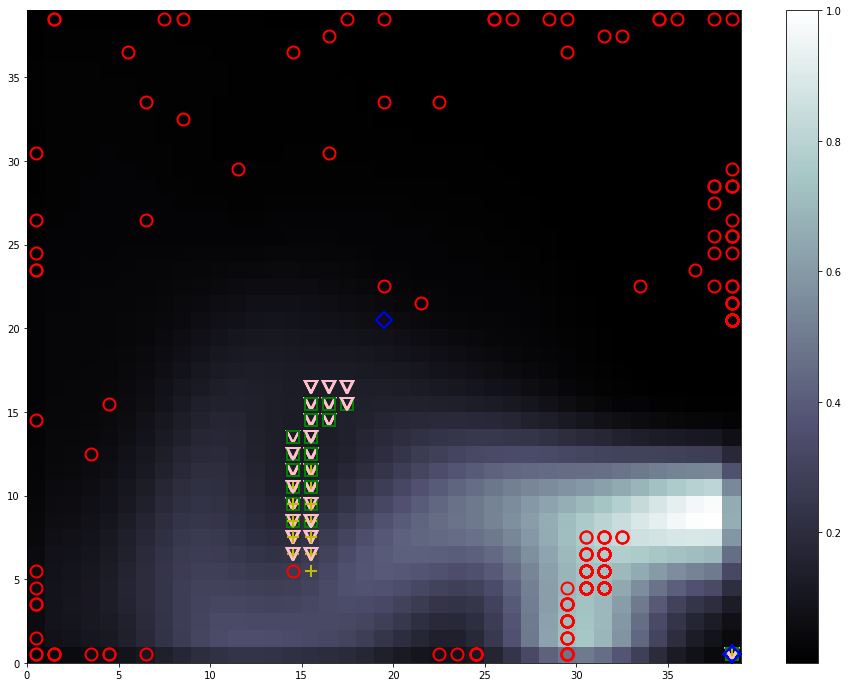

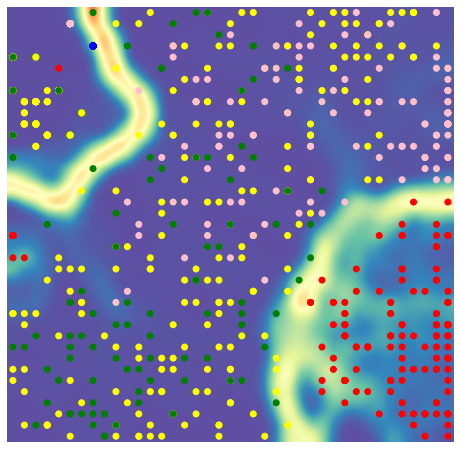

/home/ladin/Projects/research/botnet-traffic-analysis/som_anomaly_detection/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]


sd_benign: 0.06636805920922534, mean_benign: 0.05613399080464185, lim_benign: 0.25523816843231784, pct_benign: 0.625301782710518


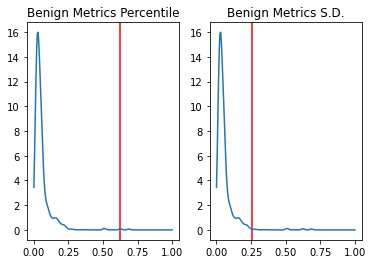

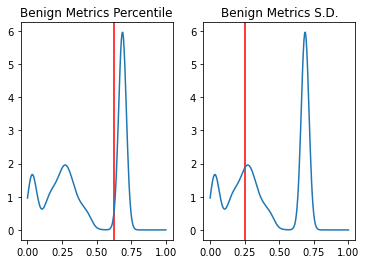

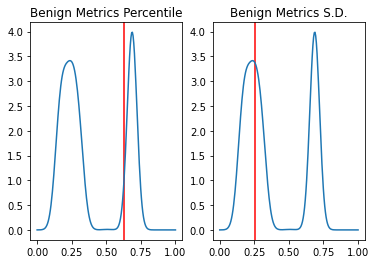

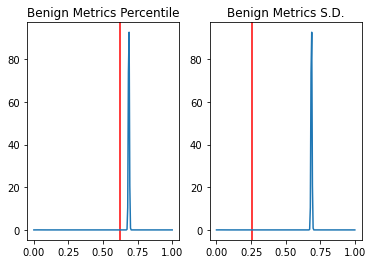

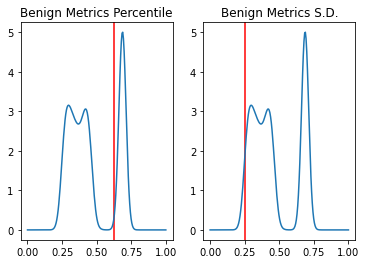

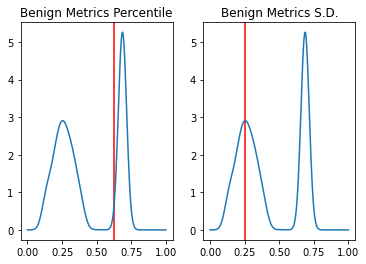

Anomaly detection
benign
Determined:  1.1400000000000001 % as anomaly
all alnomalies
Determined:  66.96666666666667 % as anomaly
ack
Determined:  58.919999999999995 % as anomaly
scan
Determined:  99.87 % as anomaly
syn
Determined:  98.11999999999999 % as anomaly
udp
Determined:  70.545 % as anomaly


In [5]:
main(choose_folder=nbaiot_10K_data_path, choose_index=1)

(20000, 115) (20000, 115) (20000, 115) (20000, 115) (40000, 115)


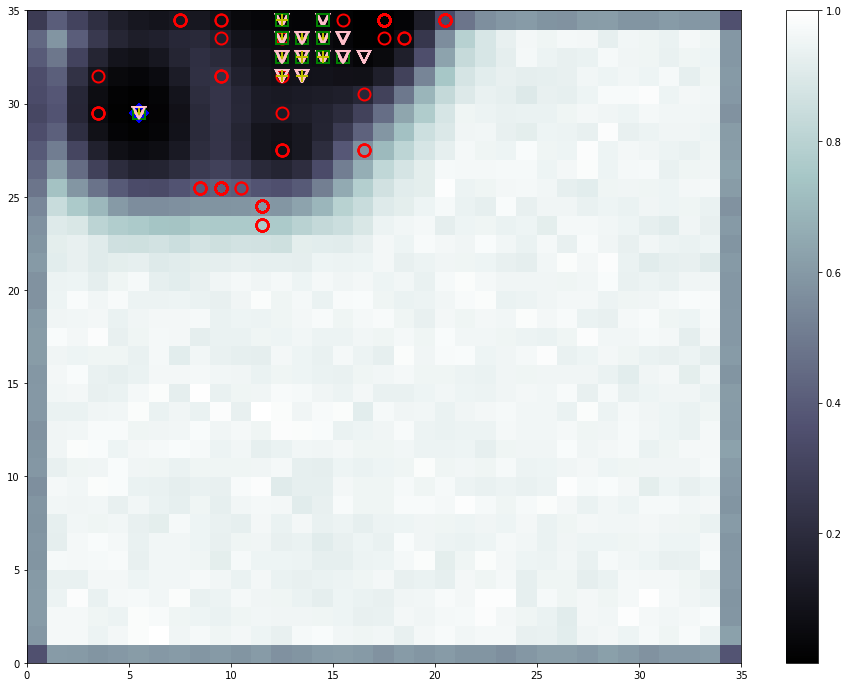

Number of feature:  26
{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 6.82474004e-05, 2.41595798e-02, ...,
        3.95947606e-03, 8.69515296e-01, 2.41595537e-02],
       [2.87586987e-03, 1.57691574e-04, 2.88269253e-02, ...,
        3.90994707e-03, 8.94358118e-01, 2.88416142e-02],
       ...,
       [1.82665609e-12, 3.28337693e-12, 2.40829443e-10, ...,
        7.56673219e-10, 1.00000000e+00, 2.43436754e-10],
       [9.61127640e-13, 5.66999766e-12, 2.41926922e-10, ...,
        7.56769334e-10, 1.00000000e+00, 2.43436754e-10],
       [6.51911344e-13, 8.05645167e-12, 2.42374193e-10, ...,
        7.56674866e-10, 1.00000000e+00, 2.43436754e-10]]), 'learning_rate': 4.6145532211270215, 'sigma': 5.664808788359548, 'x': 41.11590776946451}
1.0233455220052985
{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08

{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 6.82474004e-05, 2.41595798e-02, ...,
        3.95947606e-03, 8.69515296e-01, 2.41595537e-02],
       [2.87586987e-03, 1.57691574e-04, 2.88269253e-02, ...,
        3.90994707e-03, 8.94358118e-01, 2.88416142e-02],
       ...,
       [1.82665609e-12, 3.28337693e-12, 2.40829443e-10, ...,
        7.56673219e-10, 1.00000000e+00, 2.43436754e-10],
       [9.61127640e-13, 5.66999766e-12, 2.41926922e-10, ...,
        7.56769334e-10, 1.00000000e+00, 2.43436754e-10],
       [6.51911344e-13, 8.05645167e-12, 2.42374193e-10, ...,
        7.56674866e-10, 1.00000000e+00, 2.43436754e-10]]), 'learning_rate': 0.31176747025203955, 'sigma': 5.161214800827966, 'x': 22.612846596214418}
1.0389451614451892
{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000

{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 6.82474004e-05, 2.41595798e-02, ...,
        3.95947606e-03, 8.69515296e-01, 2.41595537e-02],
       [2.87586987e-03, 1.57691574e-04, 2.88269253e-02, ...,
        3.90994707e-03, 8.94358118e-01, 2.88416142e-02],
       ...,
       [1.82665609e-12, 3.28337693e-12, 2.40829443e-10, ...,
        7.56673219e-10, 1.00000000e+00, 2.43436754e-10],
       [9.61127640e-13, 5.66999766e-12, 2.41926922e-10, ...,
        7.56769334e-10, 1.00000000e+00, 2.43436754e-10],
       [6.51911344e-13, 8.05645167e-12, 2.42374193e-10, ...,
        7.56674866e-10, 1.00000000e+00, 2.43436754e-10]]), 'learning_rate': 2.345026380134871, 'sigma': 6.492491061029, 'x': 27.65797292041011}
1.0468574872956526
{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 

{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 6.82474004e-05, 2.41595798e-02, ...,
        3.95947606e-03, 8.69515296e-01, 2.41595537e-02],
       [2.87586987e-03, 1.57691574e-04, 2.88269253e-02, ...,
        3.90994707e-03, 8.94358118e-01, 2.88416142e-02],
       ...,
       [1.82665609e-12, 3.28337693e-12, 2.40829443e-10, ...,
        7.56673219e-10, 1.00000000e+00, 2.43436754e-10],
       [9.61127640e-13, 5.66999766e-12, 2.41926922e-10, ...,
        7.56769334e-10, 1.00000000e+00, 2.43436754e-10],
       [6.51911344e-13, 8.05645167e-12, 2.42374193e-10, ...,
        7.56674866e-10, 1.00000000e+00, 2.43436754e-10]]), 'learning_rate': 2.7694726788210637, 'sigma': 8.366552919122258, 'x': 25.82109418512913}
1.059421322064545
{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+0

{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 6.82474004e-05, 2.41595798e-02, ...,
        3.95947606e-03, 8.69515296e-01, 2.41595537e-02],
       [2.87586987e-03, 1.57691574e-04, 2.88269253e-02, ...,
        3.90994707e-03, 8.94358118e-01, 2.88416142e-02],
       ...,
       [1.82665609e-12, 3.28337693e-12, 2.40829443e-10, ...,
        7.56673219e-10, 1.00000000e+00, 2.43436754e-10],
       [9.61127640e-13, 5.66999766e-12, 2.41926922e-10, ...,
        7.56769334e-10, 1.00000000e+00, 2.43436754e-10],
       [6.51911344e-13, 8.05645167e-12, 2.42374193e-10, ...,
        7.56674866e-10, 1.00000000e+00, 2.43436754e-10]]), 'learning_rate': 4.784815735799769, 'sigma': 5.880410765269984, 'x': 22.780389530824067}
1.063475865245175
{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+0

{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 6.82474004e-05, 2.41595798e-02, ...,
        3.95947606e-03, 8.69515296e-01, 2.41595537e-02],
       [2.87586987e-03, 1.57691574e-04, 2.88269253e-02, ...,
        3.90994707e-03, 8.94358118e-01, 2.88416142e-02],
       ...,
       [1.82665609e-12, 3.28337693e-12, 2.40829443e-10, ...,
        7.56673219e-10, 1.00000000e+00, 2.43436754e-10],
       [9.61127640e-13, 5.66999766e-12, 2.41926922e-10, ...,
        7.56769334e-10, 1.00000000e+00, 2.43436754e-10],
       [6.51911344e-13, 8.05645167e-12, 2.42374193e-10, ...,
        7.56674866e-10, 1.00000000e+00, 2.43436754e-10]]), 'learning_rate': 3.28022277462676, 'sigma': 7.766673059415117, 'x': 40.93824056584767}
1.0306895930764626
{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00

{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 6.82474004e-05, 2.41595798e-02, ...,
        3.95947606e-03, 8.69515296e-01, 2.41595537e-02],
       [2.87586987e-03, 1.57691574e-04, 2.88269253e-02, ...,
        3.90994707e-03, 8.94358118e-01, 2.88416142e-02],
       ...,
       [1.82665609e-12, 3.28337693e-12, 2.40829443e-10, ...,
        7.56673219e-10, 1.00000000e+00, 2.43436754e-10],
       [9.61127640e-13, 5.66999766e-12, 2.41926922e-10, ...,
        7.56769334e-10, 1.00000000e+00, 2.43436754e-10],
       [6.51911344e-13, 8.05645167e-12, 2.42374193e-10, ...,
        7.56674866e-10, 1.00000000e+00, 2.43436754e-10]]), 'learning_rate': 3.6265786071397623, 'sigma': 7.439468913041162, 'x': 42.118509644132594}
1.0225825996943936
{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e

{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 6.82474004e-05, 2.41595798e-02, ...,
        3.95947606e-03, 8.69515296e-01, 2.41595537e-02],
       [2.87586987e-03, 1.57691574e-04, 2.88269253e-02, ...,
        3.90994707e-03, 8.94358118e-01, 2.88416142e-02],
       ...,
       [1.82665609e-12, 3.28337693e-12, 2.40829443e-10, ...,
        7.56673219e-10, 1.00000000e+00, 2.43436754e-10],
       [9.61127640e-13, 5.66999766e-12, 2.41926922e-10, ...,
        7.56769334e-10, 1.00000000e+00, 2.43436754e-10],
       [6.51911344e-13, 8.05645167e-12, 2.42374193e-10, ...,
        7.56674866e-10, 1.00000000e+00, 2.43436754e-10]]), 'learning_rate': 4.700736502947488, 'sigma': 7.674126650922163, 'x': 27.95606989280598}
1.0660122348053478
{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+0

{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 6.82474004e-05, 2.41595798e-02, ...,
        3.95947606e-03, 8.69515296e-01, 2.41595537e-02],
       [2.87586987e-03, 1.57691574e-04, 2.88269253e-02, ...,
        3.90994707e-03, 8.94358118e-01, 2.88416142e-02],
       ...,
       [1.82665609e-12, 3.28337693e-12, 2.40829443e-10, ...,
        7.56673219e-10, 1.00000000e+00, 2.43436754e-10],
       [9.61127640e-13, 5.66999766e-12, 2.41926922e-10, ...,
        7.56769334e-10, 1.00000000e+00, 2.43436754e-10],
       [6.51911344e-13, 8.05645167e-12, 2.42374193e-10, ...,
        7.56674866e-10, 1.00000000e+00, 2.43436754e-10]]), 'learning_rate': 3.6490661542329046, 'sigma': 5.258214523188653, 'x': 33.054453238516295}
1.0271852904714844
{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e

{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 6.82474004e-05, 2.41595798e-02, ...,
        3.95947606e-03, 8.69515296e-01, 2.41595537e-02],
       [2.87586987e-03, 1.57691574e-04, 2.88269253e-02, ...,
        3.90994707e-03, 8.94358118e-01, 2.88416142e-02],
       ...,
       [1.82665609e-12, 3.28337693e-12, 2.40829443e-10, ...,
        7.56673219e-10, 1.00000000e+00, 2.43436754e-10],
       [9.61127640e-13, 5.66999766e-12, 2.41926922e-10, ...,
        7.56769334e-10, 1.00000000e+00, 2.43436754e-10],
       [6.51911344e-13, 8.05645167e-12, 2.42374193e-10, ...,
        7.56674866e-10, 1.00000000e+00, 2.43436754e-10]]), 'learning_rate': 3.8244838756676534, 'sigma': 9.034923117836238, 'x': 36.56888018559215}
1.0299478801116135
{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+

{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 6.82474004e-05, 2.41595798e-02, ...,
        3.95947606e-03, 8.69515296e-01, 2.41595537e-02],
       [2.87586987e-03, 1.57691574e-04, 2.88269253e-02, ...,
        3.90994707e-03, 8.94358118e-01, 2.88416142e-02],
       ...,
       [1.82665609e-12, 3.28337693e-12, 2.40829443e-10, ...,
        7.56673219e-10, 1.00000000e+00, 2.43436754e-10],
       [9.61127640e-13, 5.66999766e-12, 2.41926922e-10, ...,
        7.56769334e-10, 1.00000000e+00, 2.43436754e-10],
       [6.51911344e-13, 8.05645167e-12, 2.42374193e-10, ...,
        7.56674866e-10, 1.00000000e+00, 2.43436754e-10]]), 'learning_rate': 1.8685838114068924, 'sigma': 6.66396159675013, 'x': 44.29914264639591}
1.0289768111785162
{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+0

{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 6.82474004e-05, 2.41595798e-02, ...,
        3.95947606e-03, 8.69515296e-01, 2.41595537e-02],
       [2.87586987e-03, 1.57691574e-04, 2.88269253e-02, ...,
        3.90994707e-03, 8.94358118e-01, 2.88416142e-02],
       ...,
       [1.82665609e-12, 3.28337693e-12, 2.40829443e-10, ...,
        7.56673219e-10, 1.00000000e+00, 2.43436754e-10],
       [9.61127640e-13, 5.66999766e-12, 2.41926922e-10, ...,
        7.56769334e-10, 1.00000000e+00, 2.43436754e-10],
       [6.51911344e-13, 8.05645167e-12, 2.42374193e-10, ...,
        7.56674866e-10, 1.00000000e+00, 2.43436754e-10]]), 'learning_rate': 2.840808180162263, 'sigma': 9.605857197796661, 'x': 30.997333632602853}
1.030552509663221
{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+0

{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 6.82474004e-05, 2.41595798e-02, ...,
        3.95947606e-03, 8.69515296e-01, 2.41595537e-02],
       [2.87586987e-03, 1.57691574e-04, 2.88269253e-02, ...,
        3.90994707e-03, 8.94358118e-01, 2.88416142e-02],
       ...,
       [1.82665609e-12, 3.28337693e-12, 2.40829443e-10, ...,
        7.56673219e-10, 1.00000000e+00, 2.43436754e-10],
       [9.61127640e-13, 5.66999766e-12, 2.41926922e-10, ...,
        7.56769334e-10, 1.00000000e+00, 2.43436754e-10],
       [6.51911344e-13, 8.05645167e-12, 2.42374193e-10, ...,
        7.56674866e-10, 1.00000000e+00, 2.43436754e-10]]), 'learning_rate': 4.634206966801659, 'sigma': 5.833403253070697, 'x': 32.663844221009306}
1.0110165053539957
{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+

{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 6.82474004e-05, 2.41595798e-02, ...,
        3.95947606e-03, 8.69515296e-01, 2.41595537e-02],
       [2.87586987e-03, 1.57691574e-04, 2.88269253e-02, ...,
        3.90994707e-03, 8.94358118e-01, 2.88416142e-02],
       ...,
       [1.82665609e-12, 3.28337693e-12, 2.40829443e-10, ...,
        7.56673219e-10, 1.00000000e+00, 2.43436754e-10],
       [9.61127640e-13, 5.66999766e-12, 2.41926922e-10, ...,
        7.56769334e-10, 1.00000000e+00, 2.43436754e-10],
       [6.51911344e-13, 8.05645167e-12, 2.42374193e-10, ...,
        7.56674866e-10, 1.00000000e+00, 2.43436754e-10]]), 'learning_rate': 2.7102517257043277, 'sigma': 5.96320850720287, 'x': 43.865048950819784}
1.0345572000572645
{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+

{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 6.82474004e-05, 2.41595798e-02, ...,
        3.95947606e-03, 8.69515296e-01, 2.41595537e-02],
       [2.87586987e-03, 1.57691574e-04, 2.88269253e-02, ...,
        3.90994707e-03, 8.94358118e-01, 2.88416142e-02],
       ...,
       [1.82665609e-12, 3.28337693e-12, 2.40829443e-10, ...,
        7.56673219e-10, 1.00000000e+00, 2.43436754e-10],
       [9.61127640e-13, 5.66999766e-12, 2.41926922e-10, ...,
        7.56769334e-10, 1.00000000e+00, 2.43436754e-10],
       [6.51911344e-13, 8.05645167e-12, 2.42374193e-10, ...,
        7.56674866e-10, 1.00000000e+00, 2.43436754e-10]]), 'learning_rate': 3.577727664100709, 'sigma': 8.927343730156235, 'x': 42.706639483452484}
1.0095943137430796
{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+

{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 6.82474004e-05, 2.41595798e-02, ...,
        3.95947606e-03, 8.69515296e-01, 2.41595537e-02],
       [2.87586987e-03, 1.57691574e-04, 2.88269253e-02, ...,
        3.90994707e-03, 8.94358118e-01, 2.88416142e-02],
       ...,
       [1.82665609e-12, 3.28337693e-12, 2.40829443e-10, ...,
        7.56673219e-10, 1.00000000e+00, 2.43436754e-10],
       [9.61127640e-13, 5.66999766e-12, 2.41926922e-10, ...,
        7.56769334e-10, 1.00000000e+00, 2.43436754e-10],
       [6.51911344e-13, 8.05645167e-12, 2.42374193e-10, ...,
        7.56674866e-10, 1.00000000e+00, 2.43436754e-10]]), 'learning_rate': 2.2334568502829732, 'sigma': 7.455635688258306, 'x': 32.83481403370139}
1.0264057069079247
{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+

{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 6.82474004e-05, 2.41595798e-02, ...,
        3.95947606e-03, 8.69515296e-01, 2.41595537e-02],
       [2.87586987e-03, 1.57691574e-04, 2.88269253e-02, ...,
        3.90994707e-03, 8.94358118e-01, 2.88416142e-02],
       ...,
       [1.82665609e-12, 3.28337693e-12, 2.40829443e-10, ...,
        7.56673219e-10, 1.00000000e+00, 2.43436754e-10],
       [9.61127640e-13, 5.66999766e-12, 2.41926922e-10, ...,
        7.56769334e-10, 1.00000000e+00, 2.43436754e-10],
       [6.51911344e-13, 8.05645167e-12, 2.42374193e-10, ...,
        7.56674866e-10, 1.00000000e+00, 2.43436754e-10]]), 'learning_rate': 2.3705102615930134, 'sigma': 6.7695503102488335, 'x': 29.39364820346161}
1.040822246678036
{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+

{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 6.82474004e-05, 2.41595798e-02, ...,
        3.95947606e-03, 8.69515296e-01, 2.41595537e-02],
       [2.87586987e-03, 1.57691574e-04, 2.88269253e-02, ...,
        3.90994707e-03, 8.94358118e-01, 2.88416142e-02],
       ...,
       [1.82665609e-12, 3.28337693e-12, 2.40829443e-10, ...,
        7.56673219e-10, 1.00000000e+00, 2.43436754e-10],
       [9.61127640e-13, 5.66999766e-12, 2.41926922e-10, ...,
        7.56769334e-10, 1.00000000e+00, 2.43436754e-10],
       [6.51911344e-13, 8.05645167e-12, 2.42374193e-10, ...,
        7.56674866e-10, 1.00000000e+00, 2.43436754e-10]]), 'learning_rate': 3.426042977569922, 'sigma': 9.646689187063261, 'x': 40.26300245775944}
1.0351688079857777
{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+0

{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 6.82474004e-05, 2.41595798e-02, ...,
        3.95947606e-03, 8.69515296e-01, 2.41595537e-02],
       [2.87586987e-03, 1.57691574e-04, 2.88269253e-02, ...,
        3.90994707e-03, 8.94358118e-01, 2.88416142e-02],
       ...,
       [1.82665609e-12, 3.28337693e-12, 2.40829443e-10, ...,
        7.56673219e-10, 1.00000000e+00, 2.43436754e-10],
       [9.61127640e-13, 5.66999766e-12, 2.41926922e-10, ...,
        7.56769334e-10, 1.00000000e+00, 2.43436754e-10],
       [6.51911344e-13, 8.05645167e-12, 2.42374193e-10, ...,
        7.56674866e-10, 1.00000000e+00, 2.43436754e-10]]), 'learning_rate': 3.584820420018586, 'sigma': 5.392811592416306, 'x': 34.5225371935716}
1.0199793589777149
{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00

{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 6.82474004e-05, 2.41595798e-02, ...,
        3.95947606e-03, 8.69515296e-01, 2.41595537e-02],
       [2.87586987e-03, 1.57691574e-04, 2.88269253e-02, ...,
        3.90994707e-03, 8.94358118e-01, 2.88416142e-02],
       ...,
       [1.82665609e-12, 3.28337693e-12, 2.40829443e-10, ...,
        7.56673219e-10, 1.00000000e+00, 2.43436754e-10],
       [9.61127640e-13, 5.66999766e-12, 2.41926922e-10, ...,
        7.56769334e-10, 1.00000000e+00, 2.43436754e-10],
       [6.51911344e-13, 8.05645167e-12, 2.42374193e-10, ...,
        7.56674866e-10, 1.00000000e+00, 2.43436754e-10]]), 'learning_rate': 3.8791049732959366, 'sigma': 5.60084042637979, 'x': 27.148865835194027}
1.0421424598500537
{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+

{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 6.82474004e-05, 2.41595798e-02, ...,
        3.95947606e-03, 8.69515296e-01, 2.41595537e-02],
       [2.87586987e-03, 1.57691574e-04, 2.88269253e-02, ...,
        3.90994707e-03, 8.94358118e-01, 2.88416142e-02],
       ...,
       [1.82665609e-12, 3.28337693e-12, 2.40829443e-10, ...,
        7.56673219e-10, 1.00000000e+00, 2.43436754e-10],
       [9.61127640e-13, 5.66999766e-12, 2.41926922e-10, ...,
        7.56769334e-10, 1.00000000e+00, 2.43436754e-10],
       [6.51911344e-13, 8.05645167e-12, 2.42374193e-10, ...,
        7.56674866e-10, 1.00000000e+00, 2.43436754e-10]]), 'learning_rate': 1.674445939390532, 'sigma': 6.712955080892695, 'x': 29.765335634526593}
1.052240023849797
{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+0

{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 6.82474004e-05, 2.41595798e-02, ...,
        3.95947606e-03, 8.69515296e-01, 2.41595537e-02],
       [2.87586987e-03, 1.57691574e-04, 2.88269253e-02, ...,
        3.90994707e-03, 8.94358118e-01, 2.88416142e-02],
       ...,
       [1.82665609e-12, 3.28337693e-12, 2.40829443e-10, ...,
        7.56673219e-10, 1.00000000e+00, 2.43436754e-10],
       [9.61127640e-13, 5.66999766e-12, 2.41926922e-10, ...,
        7.56769334e-10, 1.00000000e+00, 2.43436754e-10],
       [6.51911344e-13, 8.05645167e-12, 2.42374193e-10, ...,
        7.56674866e-10, 1.00000000e+00, 2.43436754e-10]]), 'learning_rate': 1.4302032016298196, 'sigma': 6.379309070089698, 'x': 38.69290461496493}
1.0407872832256353
{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+

{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 6.82474004e-05, 2.41595798e-02, ...,
        3.95947606e-03, 8.69515296e-01, 2.41595537e-02],
       [2.87586987e-03, 1.57691574e-04, 2.88269253e-02, ...,
        3.90994707e-03, 8.94358118e-01, 2.88416142e-02],
       ...,
       [1.82665609e-12, 3.28337693e-12, 2.40829443e-10, ...,
        7.56673219e-10, 1.00000000e+00, 2.43436754e-10],
       [9.61127640e-13, 5.66999766e-12, 2.41926922e-10, ...,
        7.56769334e-10, 1.00000000e+00, 2.43436754e-10],
       [6.51911344e-13, 8.05645167e-12, 2.42374193e-10, ...,
        7.56674866e-10, 1.00000000e+00, 2.43436754e-10]]), 'learning_rate': 2.898991023797742, 'sigma': 8.312882454355057, 'x': 35.014281719131105}
1.05573202919405
{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00

{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 6.82474004e-05, 2.41595798e-02, ...,
        3.95947606e-03, 8.69515296e-01, 2.41595537e-02],
       [2.87586987e-03, 1.57691574e-04, 2.88269253e-02, ...,
        3.90994707e-03, 8.94358118e-01, 2.88416142e-02],
       ...,
       [1.82665609e-12, 3.28337693e-12, 2.40829443e-10, ...,
        7.56673219e-10, 1.00000000e+00, 2.43436754e-10],
       [9.61127640e-13, 5.66999766e-12, 2.41926922e-10, ...,
        7.56769334e-10, 1.00000000e+00, 2.43436754e-10],
       [6.51911344e-13, 8.05645167e-12, 2.42374193e-10, ...,
        7.56674866e-10, 1.00000000e+00, 2.43436754e-10]]), 'learning_rate': 4.091337141442331, 'sigma': 8.77987817153506, 'x': 40.03654837107422}
1.0352138734281202
{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00

{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 6.82474004e-05, 2.41595798e-02, ...,
        3.95947606e-03, 8.69515296e-01, 2.41595537e-02],
       [2.87586987e-03, 1.57691574e-04, 2.88269253e-02, ...,
        3.90994707e-03, 8.94358118e-01, 2.88416142e-02],
       ...,
       [1.82665609e-12, 3.28337693e-12, 2.40829443e-10, ...,
        7.56673219e-10, 1.00000000e+00, 2.43436754e-10],
       [9.61127640e-13, 5.66999766e-12, 2.41926922e-10, ...,
        7.56769334e-10, 1.00000000e+00, 2.43436754e-10],
       [6.51911344e-13, 8.05645167e-12, 2.42374193e-10, ...,
        7.56674866e-10, 1.00000000e+00, 2.43436754e-10]]), 'learning_rate': 3.9980883465317447, 'sigma': 8.607941047943298, 'x': 33.85348658154331}
0.9997586189527972
{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+

{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 6.82474004e-05, 2.41595798e-02, ...,
        3.95947606e-03, 8.69515296e-01, 2.41595537e-02],
       [2.87586987e-03, 1.57691574e-04, 2.88269253e-02, ...,
        3.90994707e-03, 8.94358118e-01, 2.88416142e-02],
       ...,
       [1.82665609e-12, 3.28337693e-12, 2.40829443e-10, ...,
        7.56673219e-10, 1.00000000e+00, 2.43436754e-10],
       [9.61127640e-13, 5.66999766e-12, 2.41926922e-10, ...,
        7.56769334e-10, 1.00000000e+00, 2.43436754e-10],
       [6.51911344e-13, 8.05645167e-12, 2.42374193e-10, ...,
        7.56674866e-10, 1.00000000e+00, 2.43436754e-10]]), 'learning_rate': 3.6544636690073555, 'sigma': 5.5899417921192045, 'x': 39.88597125587606}
1.0265222012351665
{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e

{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 6.82474004e-05, 2.41595798e-02, ...,
        3.95947606e-03, 8.69515296e-01, 2.41595537e-02],
       [2.87586987e-03, 1.57691574e-04, 2.88269253e-02, ...,
        3.90994707e-03, 8.94358118e-01, 2.88416142e-02],
       ...,
       [1.82665609e-12, 3.28337693e-12, 2.40829443e-10, ...,
        7.56673219e-10, 1.00000000e+00, 2.43436754e-10],
       [9.61127640e-13, 5.66999766e-12, 2.41926922e-10, ...,
        7.56769334e-10, 1.00000000e+00, 2.43436754e-10],
       [6.51911344e-13, 8.05645167e-12, 2.42374193e-10, ...,
        7.56674866e-10, 1.00000000e+00, 2.43436754e-10]]), 'learning_rate': 4.618084619209462, 'sigma': 9.101805990122081, 'x': 36.14342496613132}
1.036742170451498
{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00

{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 6.82474004e-05, 2.41595798e-02, ...,
        3.95947606e-03, 8.69515296e-01, 2.41595537e-02],
       [2.87586987e-03, 1.57691574e-04, 2.88269253e-02, ...,
        3.90994707e-03, 8.94358118e-01, 2.88416142e-02],
       ...,
       [1.82665609e-12, 3.28337693e-12, 2.40829443e-10, ...,
        7.56673219e-10, 1.00000000e+00, 2.43436754e-10],
       [9.61127640e-13, 5.66999766e-12, 2.41926922e-10, ...,
        7.56769334e-10, 1.00000000e+00, 2.43436754e-10],
       [6.51911344e-13, 8.05645167e-12, 2.42374193e-10, ...,
        7.56674866e-10, 1.00000000e+00, 2.43436754e-10]]), 'learning_rate': 3.0139668582944634, 'sigma': 7.6578606601694235, 'x': 33.977984340634734}
1.038936751112775
{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e

{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 6.82474004e-05, 2.41595798e-02, ...,
        3.95947606e-03, 8.69515296e-01, 2.41595537e-02],
       [2.87586987e-03, 1.57691574e-04, 2.88269253e-02, ...,
        3.90994707e-03, 8.94358118e-01, 2.88416142e-02],
       ...,
       [1.82665609e-12, 3.28337693e-12, 2.40829443e-10, ...,
        7.56673219e-10, 1.00000000e+00, 2.43436754e-10],
       [9.61127640e-13, 5.66999766e-12, 2.41926922e-10, ...,
        7.56769334e-10, 1.00000000e+00, 2.43436754e-10],
       [6.51911344e-13, 8.05645167e-12, 2.42374193e-10, ...,
        7.56674866e-10, 1.00000000e+00, 2.43436754e-10]]), 'learning_rate': 4.66639685943949, 'sigma': 5.287921259434085, 'x': 49.913429618698494}
0.9938844617208246
{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+0

{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 6.82474004e-05, 2.41595798e-02, ...,
        3.95947606e-03, 8.69515296e-01, 2.41595537e-02],
       [2.87586987e-03, 1.57691574e-04, 2.88269253e-02, ...,
        3.90994707e-03, 8.94358118e-01, 2.88416142e-02],
       ...,
       [1.82665609e-12, 3.28337693e-12, 2.40829443e-10, ...,
        7.56673219e-10, 1.00000000e+00, 2.43436754e-10],
       [9.61127640e-13, 5.66999766e-12, 2.41926922e-10, ...,
        7.56769334e-10, 1.00000000e+00, 2.43436754e-10],
       [6.51911344e-13, 8.05645167e-12, 2.42374193e-10, ...,
        7.56674866e-10, 1.00000000e+00, 2.43436754e-10]]), 'learning_rate': 4.391869933984437, 'sigma': 5.156257080060359, 'x': 22.856830741736793}
1.0377269038554817
{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+

{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 6.82474004e-05, 2.41595798e-02, ...,
        3.95947606e-03, 8.69515296e-01, 2.41595537e-02],
       [2.87586987e-03, 1.57691574e-04, 2.88269253e-02, ...,
        3.90994707e-03, 8.94358118e-01, 2.88416142e-02],
       ...,
       [1.82665609e-12, 3.28337693e-12, 2.40829443e-10, ...,
        7.56673219e-10, 1.00000000e+00, 2.43436754e-10],
       [9.61127640e-13, 5.66999766e-12, 2.41926922e-10, ...,
        7.56769334e-10, 1.00000000e+00, 2.43436754e-10],
       [6.51911344e-13, 8.05645167e-12, 2.42374193e-10, ...,
        7.56674866e-10, 1.00000000e+00, 2.43436754e-10]]), 'learning_rate': 1.7682916380765754, 'sigma': 6.039997415606315, 'x': 47.999117748000266}
1.0082885942575757
{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e

{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 6.82474004e-05, 2.41595798e-02, ...,
        3.95947606e-03, 8.69515296e-01, 2.41595537e-02],
       [2.87586987e-03, 1.57691574e-04, 2.88269253e-02, ...,
        3.90994707e-03, 8.94358118e-01, 2.88416142e-02],
       ...,
       [1.82665609e-12, 3.28337693e-12, 2.40829443e-10, ...,
        7.56673219e-10, 1.00000000e+00, 2.43436754e-10],
       [9.61127640e-13, 5.66999766e-12, 2.41926922e-10, ...,
        7.56769334e-10, 1.00000000e+00, 2.43436754e-10],
       [6.51911344e-13, 8.05645167e-12, 2.42374193e-10, ...,
        7.56674866e-10, 1.00000000e+00, 2.43436754e-10]]), 'learning_rate': 2.29948378591871, 'sigma': 6.374222422787775, 'x': 24.05902846565725}
1.0298923760054073
{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00

{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 6.82474004e-05, 2.41595798e-02, ...,
        3.95947606e-03, 8.69515296e-01, 2.41595537e-02],
       [2.87586987e-03, 1.57691574e-04, 2.88269253e-02, ...,
        3.90994707e-03, 8.94358118e-01, 2.88416142e-02],
       ...,
       [1.82665609e-12, 3.28337693e-12, 2.40829443e-10, ...,
        7.56673219e-10, 1.00000000e+00, 2.43436754e-10],
       [9.61127640e-13, 5.66999766e-12, 2.41926922e-10, ...,
        7.56769334e-10, 1.00000000e+00, 2.43436754e-10],
       [6.51911344e-13, 8.05645167e-12, 2.42374193e-10, ...,
        7.56674866e-10, 1.00000000e+00, 2.43436754e-10]]), 'learning_rate': 1.7158885191789763, 'sigma': 5.461439267382671, 'x': 37.78362338450935}
1.0238157744011462
{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+

{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 6.82474004e-05, 2.41595798e-02, ...,
        3.95947606e-03, 8.69515296e-01, 2.41595537e-02],
       [2.87586987e-03, 1.57691574e-04, 2.88269253e-02, ...,
        3.90994707e-03, 8.94358118e-01, 2.88416142e-02],
       ...,
       [1.82665609e-12, 3.28337693e-12, 2.40829443e-10, ...,
        7.56673219e-10, 1.00000000e+00, 2.43436754e-10],
       [9.61127640e-13, 5.66999766e-12, 2.41926922e-10, ...,
        7.56769334e-10, 1.00000000e+00, 2.43436754e-10],
       [6.51911344e-13, 8.05645167e-12, 2.42374193e-10, ...,
        7.56674866e-10, 1.00000000e+00, 2.43436754e-10]]), 'learning_rate': 3.114902975606052, 'sigma': 6.739568883032545, 'x': 27.712478860132524}
1.0266989372275037
{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+

{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 6.82474004e-05, 2.41595798e-02, ...,
        3.95947606e-03, 8.69515296e-01, 2.41595537e-02],
       [2.87586987e-03, 1.57691574e-04, 2.88269253e-02, ...,
        3.90994707e-03, 8.94358118e-01, 2.88416142e-02],
       ...,
       [1.82665609e-12, 3.28337693e-12, 2.40829443e-10, ...,
        7.56673219e-10, 1.00000000e+00, 2.43436754e-10],
       [9.61127640e-13, 5.66999766e-12, 2.41926922e-10, ...,
        7.56769334e-10, 1.00000000e+00, 2.43436754e-10],
       [6.51911344e-13, 8.05645167e-12, 2.42374193e-10, ...,
        7.56674866e-10, 1.00000000e+00, 2.43436754e-10]]), 'learning_rate': 2.9025969894094117, 'sigma': 6.205880100281224, 'x': 31.82616432425714}
1.0285353988444972
{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+

{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 6.82474004e-05, 2.41595798e-02, ...,
        3.95947606e-03, 8.69515296e-01, 2.41595537e-02],
       [2.87586987e-03, 1.57691574e-04, 2.88269253e-02, ...,
        3.90994707e-03, 8.94358118e-01, 2.88416142e-02],
       ...,
       [1.82665609e-12, 3.28337693e-12, 2.40829443e-10, ...,
        7.56673219e-10, 1.00000000e+00, 2.43436754e-10],
       [9.61127640e-13, 5.66999766e-12, 2.41926922e-10, ...,
        7.56769334e-10, 1.00000000e+00, 2.43436754e-10],
       [6.51911344e-13, 8.05645167e-12, 2.42374193e-10, ...,
        7.56674866e-10, 1.00000000e+00, 2.43436754e-10]]), 'learning_rate': 4.759933938049096, 'sigma': 7.6458941689987645, 'x': 29.245073377841624}
1.0360428014354761
{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e

1.0010123557447332
{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 6.82474004e-05, 2.41595798e-02, ...,
        3.95947606e-03, 8.69515296e-01, 2.41595537e-02],
       [2.87586987e-03, 1.57691574e-04, 2.88269253e-02, ...,
        3.90994707e-03, 8.94358118e-01, 2.88416142e-02],
       ...,
       [1.82665609e-12, 3.28337693e-12, 2.40829443e-10, ...,
        7.56673219e-10, 1.00000000e+00, 2.43436754e-10],
       [9.61127640e-13, 5.66999766e-12, 2.41926922e-10, ...,
        7.56769334e-10, 1.00000000e+00, 2.43436754e-10],
       [6.51911344e-13, 8.05645167e-12, 2.42374193e-10, ...,
        7.56674866e-10, 1.00000000e+00, 2.43436754e-10]]), 'learning_rate': 4.998663321605226, 'sigma': 5.0112499400226485, 'x': 45.93938335518913}
1.0039962632392758
{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
 

{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 6.82474004e-05, 2.41595798e-02, ...,
        3.95947606e-03, 8.69515296e-01, 2.41595537e-02],
       [2.87586987e-03, 1.57691574e-04, 2.88269253e-02, ...,
        3.90994707e-03, 8.94358118e-01, 2.88416142e-02],
       ...,
       [1.82665609e-12, 3.28337693e-12, 2.40829443e-10, ...,
        7.56673219e-10, 1.00000000e+00, 2.43436754e-10],
       [9.61127640e-13, 5.66999766e-12, 2.41926922e-10, ...,
        7.56769334e-10, 1.00000000e+00, 2.43436754e-10],
       [6.51911344e-13, 8.05645167e-12, 2.42374193e-10, ...,
        7.56674866e-10, 1.00000000e+00, 2.43436754e-10]]), 'learning_rate': 4.990620999590389, 'sigma': 6.095464756768953, 'x': 49.99622188902785}
0.9860099988893868
{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+0

{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 6.82474004e-05, 2.41595798e-02, ...,
        3.95947606e-03, 8.69515296e-01, 2.41595537e-02],
       [2.87586987e-03, 1.57691574e-04, 2.88269253e-02, ...,
        3.90994707e-03, 8.94358118e-01, 2.88416142e-02],
       ...,
       [1.82665609e-12, 3.28337693e-12, 2.40829443e-10, ...,
        7.56673219e-10, 1.00000000e+00, 2.43436754e-10],
       [9.61127640e-13, 5.66999766e-12, 2.41926922e-10, ...,
        7.56769334e-10, 1.00000000e+00, 2.43436754e-10],
       [6.51911344e-13, 8.05645167e-12, 2.42374193e-10, ...,
        7.56674866e-10, 1.00000000e+00, 2.43436754e-10]]), 'learning_rate': 3.7362519443888935, 'sigma': 6.17401831629516, 'x': 35.119480861033644}
1.0310781017484167
{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+

{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 6.82474004e-05, 2.41595798e-02, ...,
        3.95947606e-03, 8.69515296e-01, 2.41595537e-02],
       [2.87586987e-03, 1.57691574e-04, 2.88269253e-02, ...,
        3.90994707e-03, 8.94358118e-01, 2.88416142e-02],
       ...,
       [1.82665609e-12, 3.28337693e-12, 2.40829443e-10, ...,
        7.56673219e-10, 1.00000000e+00, 2.43436754e-10],
       [9.61127640e-13, 5.66999766e-12, 2.41926922e-10, ...,
        7.56769334e-10, 1.00000000e+00, 2.43436754e-10],
       [6.51911344e-13, 8.05645167e-12, 2.42374193e-10, ...,
        7.56674866e-10, 1.00000000e+00, 2.43436754e-10]]), 'learning_rate': 4.17861695793675, 'sigma': 6.78763183083806, 'x': 33.800644066752135}
1.0064850392083078
{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00

{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 6.82474004e-05, 2.41595798e-02, ...,
        3.95947606e-03, 8.69515296e-01, 2.41595537e-02],
       [2.87586987e-03, 1.57691574e-04, 2.88269253e-02, ...,
        3.90994707e-03, 8.94358118e-01, 2.88416142e-02],
       ...,
       [1.82665609e-12, 3.28337693e-12, 2.40829443e-10, ...,
        7.56673219e-10, 1.00000000e+00, 2.43436754e-10],
       [9.61127640e-13, 5.66999766e-12, 2.41926922e-10, ...,
        7.56769334e-10, 1.00000000e+00, 2.43436754e-10],
       [6.51911344e-13, 8.05645167e-12, 2.42374193e-10, ...,
        7.56674866e-10, 1.00000000e+00, 2.43436754e-10]]), 'learning_rate': 4.020827027533247, 'sigma': 8.038072274308492, 'x': 43.01880173840175}
1.0255570839994734
{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+0

{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 6.82474004e-05, 2.41595798e-02, ...,
        3.95947606e-03, 8.69515296e-01, 2.41595537e-02],
       [2.87586987e-03, 1.57691574e-04, 2.88269253e-02, ...,
        3.90994707e-03, 8.94358118e-01, 2.88416142e-02],
       ...,
       [1.82665609e-12, 3.28337693e-12, 2.40829443e-10, ...,
        7.56673219e-10, 1.00000000e+00, 2.43436754e-10],
       [9.61127640e-13, 5.66999766e-12, 2.41926922e-10, ...,
        7.56769334e-10, 1.00000000e+00, 2.43436754e-10],
       [6.51911344e-13, 8.05645167e-12, 2.42374193e-10, ...,
        7.56674866e-10, 1.00000000e+00, 2.43436754e-10]]), 'learning_rate': 3.8296414284091425, 'sigma': 7.405735954474519, 'x': 27.018832967423375}
1.0405553658904236
{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e

{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 6.82474004e-05, 2.41595798e-02, ...,
        3.95947606e-03, 8.69515296e-01, 2.41595537e-02],
       [2.87586987e-03, 1.57691574e-04, 2.88269253e-02, ...,
        3.90994707e-03, 8.94358118e-01, 2.88416142e-02],
       ...,
       [1.82665609e-12, 3.28337693e-12, 2.40829443e-10, ...,
        7.56673219e-10, 1.00000000e+00, 2.43436754e-10],
       [9.61127640e-13, 5.66999766e-12, 2.41926922e-10, ...,
        7.56769334e-10, 1.00000000e+00, 2.43436754e-10],
       [6.51911344e-13, 8.05645167e-12, 2.42374193e-10, ...,
        7.56674866e-10, 1.00000000e+00, 2.43436754e-10]]), 'learning_rate': 3.7264220716919585, 'sigma': 6.837285210287766, 'x': 30.418695849956165}
1.0390321000140812
{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e

{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 6.82474004e-05, 2.41595798e-02, ...,
        3.95947606e-03, 8.69515296e-01, 2.41595537e-02],
       [2.87586987e-03, 1.57691574e-04, 2.88269253e-02, ...,
        3.90994707e-03, 8.94358118e-01, 2.88416142e-02],
       ...,
       [1.82665609e-12, 3.28337693e-12, 2.40829443e-10, ...,
        7.56673219e-10, 1.00000000e+00, 2.43436754e-10],
       [9.61127640e-13, 5.66999766e-12, 2.41926922e-10, ...,
        7.56769334e-10, 1.00000000e+00, 2.43436754e-10],
       [6.51911344e-13, 8.05645167e-12, 2.42374193e-10, ...,
        7.56674866e-10, 1.00000000e+00, 2.43436754e-10]]), 'learning_rate': 2.555089516198388, 'sigma': 6.565224477158527, 'x': 31.897241082774226}
1.0363828947059712
{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+

{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+00, 6.82474004e-05, 2.41595798e-02, ...,
        3.95947606e-03, 8.69515296e-01, 2.41595537e-02],
       [2.87586987e-03, 1.57691574e-04, 2.88269253e-02, ...,
        3.90994707e-03, 8.94358118e-01, 2.88416142e-02],
       ...,
       [1.82665609e-12, 3.28337693e-12, 2.40829443e-10, ...,
        7.56673219e-10, 1.00000000e+00, 2.43436754e-10],
       [9.61127640e-13, 5.66999766e-12, 2.41926922e-10, ...,
        7.56769334e-10, 1.00000000e+00, 2.43436754e-10],
       [6.51911344e-13, 8.05645167e-12, 2.42374193e-10, ...,
        7.56674866e-10, 1.00000000e+00, 2.43436754e-10]]), 'learning_rate': 4.640089050923015, 'sigma': 6.727176199665064, 'x': 36.03804745293256}
1.0401595876502838
{'data_benign': array([[0.00000000e+00, 2.97021301e-10, 1.78212781e-08, ...,
        4.47213595e-01, 0.00000000e+00, 1.78212781e-08],
       [0.00000000e+0

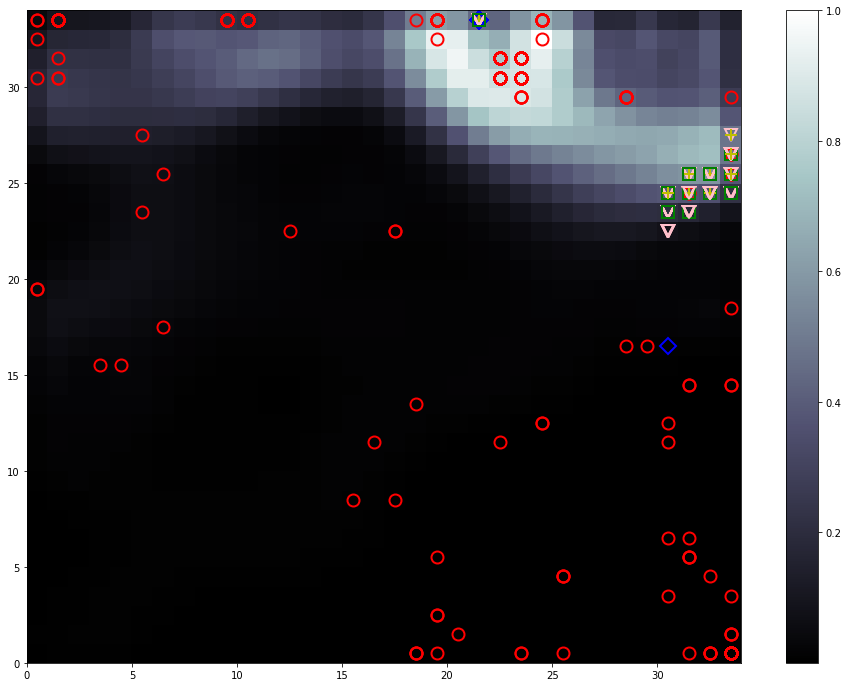

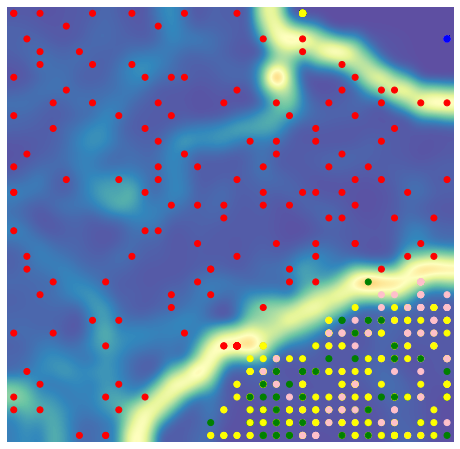

/home/ladin/Projects/research/botnet-traffic-analysis/som_anomaly_detection/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]


sd_benign: 0.0729908339938509, mean_benign: 0.06398703319028709, lim_benign: 0.2829595351718398, pct_benign: 0.5756611885147614


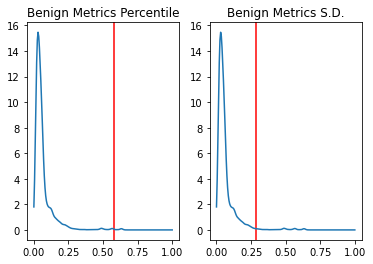

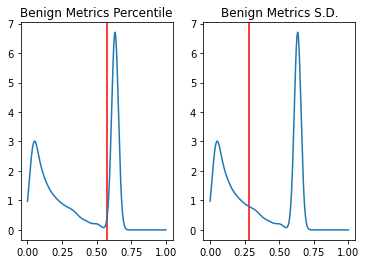

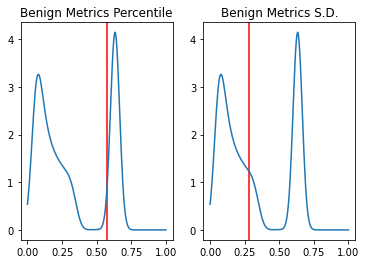

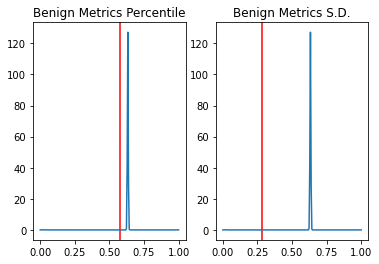

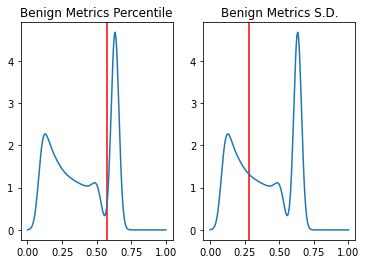

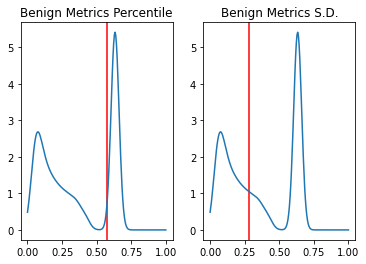

Anomaly detection
benign
Determined:  1.72 % as anomaly
all alnomalies
Determined:  51.3175 % as anomaly
ack
Determined:  42.175000000000004 % as anomaly
scan
Determined:  99.86500000000001 % as anomaly
syn
Determined:  61.23499999999999 % as anomaly
udp
Determined:  51.365 % as anomaly


In [6]:
main(choose_folder=nbaiot_20K_data_path, choose_index=1)

In [7]:
import pandas as pd

def other_main(choose_folder, choose_index):
    # select folder and device type to test
    # choose_folder = nbaiot_1K_data_path
    # choose_index = 1
    # get data
    df_benign, df_ack, df_scan, df_syn, df_udp = get_data_by_device_type(index=choose_index,
                                                                         choose_folder=choose_folder)
    print(df_benign.shape, df_ack.shape, df_scan.shape, df_syn.shape, df_udp.shape)
    # preprocess data
    # preprocess data
    df_benign['class'] = 0
    df_ack['class'] = 1
    df_scan['class'] = 2
    df_syn['class'] = 3
    df_udp['class'] = 4

    data_benign = df_benign.iloc[:, 0:-1].values # normalize(df_benign.iloc[:, 0:-1])
    data_ack = df_ack.iloc[:, 0:-1].values # normalize(df_ack.iloc[:, 0:-1])
    data_scan = df_scan.iloc[:, 0:-1].values # normalize(df_scan.iloc[:, 0:-1])
    data_syn = df_syn.iloc[:, 0:-1].values # normalize(df_syn.iloc[:, 0:-1])
    data_udp = df_udp.iloc[:, 0:-1].values # normalize(df_udp.iloc[:, 0:-1])

    target_benign = df_benign.iloc[:, -1].astype(int)
    target_ack = df_ack.iloc[:, -1].astype(int)
    target_scan = df_scan.iloc[:, -1].astype(int)
    target_syn = df_syn.iloc[:, -1].astype(int)
    target_udp = df_udp.iloc[:, -1].astype(int)

    # combine data
    data = np.vstack([data_benign, data_ack, data_scan, data_syn, data_udp])
    target = np.hstack([target_benign, target_ack, target_scan, target_syn, target_udp])

    data, target = resample(data, target)
#     data = resample(data)

    # creating and training SOM
    n = 5000
    x = int(1 / 2 * np.sqrt(n))
    som_og = minisom.MiniSom(x=x,
                             y=x,
                             input_len=data_benign.shape[1],
                             sigma=2,
                             learning_rate=0.5)
    som_og.train_random(data_benign, 100)
    # plot som
    plot_som(som_og, data[0:n, :], target[0:n])

    # Tree-based feature selection
    clf = ExtraTreesClassifier()
    clf.fit(data, target)

    sfm = SelectFromModel(clf, prefit=True)
    # transform data
    data_benign_new = sfm.transform(data_benign)
    data_ack_new = sfm.transform(data_ack)
    data_scan_new = sfm.transform(data_scan)
    data_syn_new = sfm.transform(data_syn)
    data_udp_new = sfm.transform(data_udp)
    data_new = sfm.transform(data)
    
    # normalize data
    data_benign_new = normalize(data_benign_new)
    data_ack_new = normalize(data_ack_new)
    data_scan_new = normalize(data_scan_new)
    data_syn_new = normalize(data_syn_new)
    data_udp_new = normalize(data_udp_new)
    data_new = normalize(data_new)
    
    #--------------------Region SOM---------------------------#
    
    print("Number of feature: ", data_new.shape[1])

    # get parameters
    space = {
        'sigma': hp.uniform('sigma', 5, 10),
        'learning_rate': hp.uniform('learning_rate', 0.05, 5),
        'x': hp.uniform('x', 20, 50),
        'data_benign': data_benign_new
    }
    trials = Trials()
    best = fmin(fn=som_fn,
                space=space,
                algo=tpe.suggest,
                max_evals=500,
                trials=trials,
                verbose=0)
    print('Best: {}'.format(best))
    som_turned = minisom.MiniSom(x=math.ceil(best['x']),
                                 y=math.ceil(best['x']),
                                 input_len=data_benign_new.shape[1],
                                 sigma=best['sigma'],
                                 learning_rate=best['learning_rate'])
    som_turned.train_random(data_benign_new, 1000, verbose=0)
    n = 10000
    plot_som(som_turned, data_new[0:n, :], target[0:n])

    # Somoclu
    som_somoclu = somoclu.Somoclu(n_columns=math.ceil(best['x']),
                                  n_rows=math.ceil(best['x']),
                                  std_coeff=best['sigma'])
    som_somoclu.train(data_new[0:1000, :],
                      scale0=0.2,
                      scaleN=0.02)
    colors = ['red', 'green', 'blue', 'pink', 'yellow']
    color_list = [colors[t] for t in target[0:1000]]
    som_somoclu.view_umatrix(bestmatches=True, bestmatchcolors=color_list)

    ## Anomalies detection ##
    training = data_benign_new
    evaluation = data_new

    # initialize our anomaly detector with some arbitrary parameters
    anomaly_detector = AnomalyDetection(shape=(10, 10),
                                        input_size=training.shape[1],
                                        learning_rate=8,
                                        learning_decay=0.001,
                                        initial_radius=2,
                                        radius_decay=0.001,
                                        min_number_per_bmu=0,
                                        number_of_neighbors=3)
    # fit the anomaly detector and apply to the evaluation data
    anomaly_detector.fit(training, 5000)
    # set limits
    benign_metrics = anomaly_detector.evaluate(data_benign_new)
    alpha = 3

    sd_benign = np.std(benign_metrics)
    mean_benign = np.mean(benign_metrics)
    lim_benign = mean_benign + alpha * sd_benign
    pct_benign = np.percentile(benign_metrics, 99.7)
    print("sd_benign: {}, mean_benign: {}, lim_benign: {}, pct_benign: {}".format(sd_benign, mean_benign, lim_benign, pct_benign))
    # Visualize benign metric
    visualizing_metric(metrics=benign_metrics, lim=lim_benign, pct=pct_benign)
    # Visualize all anomlies
    anomaly_metrics = anomaly_detector.evaluate(evaluation)
    visualizing_metric(metrics=anomaly_metrics, lim=lim_benign, pct=pct_benign)
    # Visualizing ack attack
    ack_metrics = anomaly_detector.evaluate(data_ack_new)
    visualizing_metric(metrics=ack_metrics, lim=lim_benign, pct=pct_benign)
    # Visualizing scan attack
    scan_metrics = anomaly_detector.evaluate(data_scan_new)
    visualizing_metric(metrics=scan_metrics, lim=lim_benign, pct=pct_benign)
    # Visualizing syn attack
    syn_metrics = anomaly_detector.evaluate(data_syn_new)
    visualizing_metric(metrics=syn_metrics, lim=lim_benign, pct=pct_benign)
    # Visualizing udp attack
    udp_metrics = anomaly_detector.evaluate(data_udp_new)
    visualizing_metric(metrics=udp_metrics, lim=lim_benign, pct=pct_benign)

    # Anomaly detection
    print("Anomaly detection")
    metrics = [benign_metrics, anomaly_metrics, ack_metrics, scan_metrics, syn_metrics, udp_metrics]
    metric_names = ['benign', 'all alnomalies', 'ack', 'scan', 'syn', 'udp']
    alpha = 3
    for metric, name in zip(metrics, metric_names):
        print(name)
        get_anomalies(benign_metrics, metric, alpha, False)

#     # Hyper parameters tuning

(1000, 115) (1000, 115) (1000, 115) (1000, 115) (2000, 115)


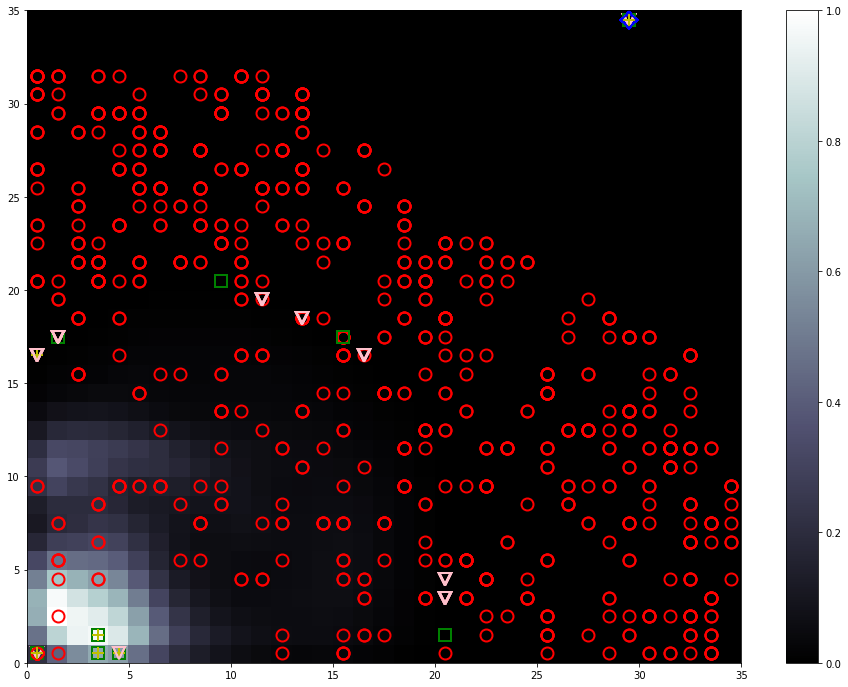

Number of feature:  33
{'data_benign': array([[1.99247946e-08, 1.99247946e-08, 0.00000000e+00, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.78476943e-01, 2.78476943e-01, 0.00000000e+00, ...,
        4.56391543e-02, 2.78476643e-01, 2.70817014e-01],
       [2.77218353e-01, 2.77077423e-01, 2.76280653e-02, ...,
        3.75622952e-02, 2.77077210e-01, 2.67408173e-01],
       ...,
       [1.79505662e-01, 1.79504956e-01, 2.83486257e-06, ...,
        6.86847304e-02, 2.53859346e-01, 2.53859346e-01],
       [1.81680697e-01, 1.81680161e-01, 2.15197226e-06, ...,
        6.95118700e-02, 2.56935309e-01, 2.56935309e-01],
       [1.83650961e-01, 1.83650528e-01, 1.73948971e-06, ...,
        7.02658144e-02, 2.59721683e-01, 2.59721683e-01]]), 'learning_rate': 1.6915729462593303, 'sigma': 7.9310444385938865, 'x': 23.37225047659382}
1.1282164340745107
{'data_benign': array([[1.99247946e-08, 1.99247946e-08, 0.00000000e+00, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-0

{'data_benign': array([[1.99247946e-08, 1.99247946e-08, 0.00000000e+00, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.78476943e-01, 2.78476943e-01, 0.00000000e+00, ...,
        4.56391543e-02, 2.78476643e-01, 2.70817014e-01],
       [2.77218353e-01, 2.77077423e-01, 2.76280653e-02, ...,
        3.75622952e-02, 2.77077210e-01, 2.67408173e-01],
       ...,
       [1.79505662e-01, 1.79504956e-01, 2.83486257e-06, ...,
        6.86847304e-02, 2.53859346e-01, 2.53859346e-01],
       [1.81680697e-01, 1.81680161e-01, 2.15197226e-06, ...,
        6.95118700e-02, 2.56935309e-01, 2.56935309e-01],
       [1.83650961e-01, 1.83650528e-01, 1.73948971e-06, ...,
        7.02658144e-02, 2.59721683e-01, 2.59721683e-01]]), 'learning_rate': 4.792702185225165, 'sigma': 8.317117138381146, 'x': 49.273608686255876}
1.0590067648177937
{'data_benign': array([[1.99247946e-08, 1.99247946e-08, 0.00000000e+00, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.78476943e-

{'data_benign': array([[1.99247946e-08, 1.99247946e-08, 0.00000000e+00, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.78476943e-01, 2.78476943e-01, 0.00000000e+00, ...,
        4.56391543e-02, 2.78476643e-01, 2.70817014e-01],
       [2.77218353e-01, 2.77077423e-01, 2.76280653e-02, ...,
        3.75622952e-02, 2.77077210e-01, 2.67408173e-01],
       ...,
       [1.79505662e-01, 1.79504956e-01, 2.83486257e-06, ...,
        6.86847304e-02, 2.53859346e-01, 2.53859346e-01],
       [1.81680697e-01, 1.81680161e-01, 2.15197226e-06, ...,
        6.95118700e-02, 2.56935309e-01, 2.56935309e-01],
       [1.83650961e-01, 1.83650528e-01, 1.73948971e-06, ...,
        7.02658144e-02, 2.59721683e-01, 2.59721683e-01]]), 'learning_rate': 3.6139865264531115, 'sigma': 7.739193032429048, 'x': 38.98183015304912}
1.1052942849084235
{'data_benign': array([[1.99247946e-08, 1.99247946e-08, 0.00000000e+00, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.78476943e-

{'data_benign': array([[1.99247946e-08, 1.99247946e-08, 0.00000000e+00, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.78476943e-01, 2.78476943e-01, 0.00000000e+00, ...,
        4.56391543e-02, 2.78476643e-01, 2.70817014e-01],
       [2.77218353e-01, 2.77077423e-01, 2.76280653e-02, ...,
        3.75622952e-02, 2.77077210e-01, 2.67408173e-01],
       ...,
       [1.79505662e-01, 1.79504956e-01, 2.83486257e-06, ...,
        6.86847304e-02, 2.53859346e-01, 2.53859346e-01],
       [1.81680697e-01, 1.81680161e-01, 2.15197226e-06, ...,
        6.95118700e-02, 2.56935309e-01, 2.56935309e-01],
       [1.83650961e-01, 1.83650528e-01, 1.73948971e-06, ...,
        7.02658144e-02, 2.59721683e-01, 2.59721683e-01]]), 'learning_rate': 3.3627662452593667, 'sigma': 8.778136565327811, 'x': 44.25602791759974}
1.0975735496839307
{'data_benign': array([[1.99247946e-08, 1.99247946e-08, 0.00000000e+00, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.78476943e-

{'data_benign': array([[1.99247946e-08, 1.99247946e-08, 0.00000000e+00, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.78476943e-01, 2.78476943e-01, 0.00000000e+00, ...,
        4.56391543e-02, 2.78476643e-01, 2.70817014e-01],
       [2.77218353e-01, 2.77077423e-01, 2.76280653e-02, ...,
        3.75622952e-02, 2.77077210e-01, 2.67408173e-01],
       ...,
       [1.79505662e-01, 1.79504956e-01, 2.83486257e-06, ...,
        6.86847304e-02, 2.53859346e-01, 2.53859346e-01],
       [1.81680697e-01, 1.81680161e-01, 2.15197226e-06, ...,
        6.95118700e-02, 2.56935309e-01, 2.56935309e-01],
       [1.83650961e-01, 1.83650528e-01, 1.73948971e-06, ...,
        7.02658144e-02, 2.59721683e-01, 2.59721683e-01]]), 'learning_rate': 0.05339015625819554, 'sigma': 5.866426486492187, 'x': 40.902509138983405}
1.0915881740755986
{'data_benign': array([[1.99247946e-08, 1.99247946e-08, 0.00000000e+00, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.78476943

{'data_benign': array([[1.99247946e-08, 1.99247946e-08, 0.00000000e+00, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.78476943e-01, 2.78476943e-01, 0.00000000e+00, ...,
        4.56391543e-02, 2.78476643e-01, 2.70817014e-01],
       [2.77218353e-01, 2.77077423e-01, 2.76280653e-02, ...,
        3.75622952e-02, 2.77077210e-01, 2.67408173e-01],
       ...,
       [1.79505662e-01, 1.79504956e-01, 2.83486257e-06, ...,
        6.86847304e-02, 2.53859346e-01, 2.53859346e-01],
       [1.81680697e-01, 1.81680161e-01, 2.15197226e-06, ...,
        6.95118700e-02, 2.56935309e-01, 2.56935309e-01],
       [1.83650961e-01, 1.83650528e-01, 1.73948971e-06, ...,
        7.02658144e-02, 2.59721683e-01, 2.59721683e-01]]), 'learning_rate': 3.440061035851415, 'sigma': 6.057679702197513, 'x': 48.591322287504184}
1.0508038162202447
{'data_benign': array([[1.99247946e-08, 1.99247946e-08, 0.00000000e+00, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.78476943e-

{'data_benign': array([[1.99247946e-08, 1.99247946e-08, 0.00000000e+00, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.78476943e-01, 2.78476943e-01, 0.00000000e+00, ...,
        4.56391543e-02, 2.78476643e-01, 2.70817014e-01],
       [2.77218353e-01, 2.77077423e-01, 2.76280653e-02, ...,
        3.75622952e-02, 2.77077210e-01, 2.67408173e-01],
       ...,
       [1.79505662e-01, 1.79504956e-01, 2.83486257e-06, ...,
        6.86847304e-02, 2.53859346e-01, 2.53859346e-01],
       [1.81680697e-01, 1.81680161e-01, 2.15197226e-06, ...,
        6.95118700e-02, 2.56935309e-01, 2.56935309e-01],
       [1.83650961e-01, 1.83650528e-01, 1.73948971e-06, ...,
        7.02658144e-02, 2.59721683e-01, 2.59721683e-01]]), 'learning_rate': 2.6922198847236434, 'sigma': 5.797178051731694, 'x': 43.43963942522649}
1.08369963442615
{'data_benign': array([[1.99247946e-08, 1.99247946e-08, 0.00000000e+00, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.78476943e-01

{'data_benign': array([[1.99247946e-08, 1.99247946e-08, 0.00000000e+00, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.78476943e-01, 2.78476943e-01, 0.00000000e+00, ...,
        4.56391543e-02, 2.78476643e-01, 2.70817014e-01],
       [2.77218353e-01, 2.77077423e-01, 2.76280653e-02, ...,
        3.75622952e-02, 2.77077210e-01, 2.67408173e-01],
       ...,
       [1.79505662e-01, 1.79504956e-01, 2.83486257e-06, ...,
        6.86847304e-02, 2.53859346e-01, 2.53859346e-01],
       [1.81680697e-01, 1.81680161e-01, 2.15197226e-06, ...,
        6.95118700e-02, 2.56935309e-01, 2.56935309e-01],
       [1.83650961e-01, 1.83650528e-01, 1.73948971e-06, ...,
        7.02658144e-02, 2.59721683e-01, 2.59721683e-01]]), 'learning_rate': 3.6474289205553823, 'sigma': 7.226481996327912, 'x': 45.503212456727724}
1.0940860840974551
{'data_benign': array([[1.99247946e-08, 1.99247946e-08, 0.00000000e+00, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.78476943e

{'data_benign': array([[1.99247946e-08, 1.99247946e-08, 0.00000000e+00, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.78476943e-01, 2.78476943e-01, 0.00000000e+00, ...,
        4.56391543e-02, 2.78476643e-01, 2.70817014e-01],
       [2.77218353e-01, 2.77077423e-01, 2.76280653e-02, ...,
        3.75622952e-02, 2.77077210e-01, 2.67408173e-01],
       ...,
       [1.79505662e-01, 1.79504956e-01, 2.83486257e-06, ...,
        6.86847304e-02, 2.53859346e-01, 2.53859346e-01],
       [1.81680697e-01, 1.81680161e-01, 2.15197226e-06, ...,
        6.95118700e-02, 2.56935309e-01, 2.56935309e-01],
       [1.83650961e-01, 1.83650528e-01, 1.73948971e-06, ...,
        7.02658144e-02, 2.59721683e-01, 2.59721683e-01]]), 'learning_rate': 1.4083900882255151, 'sigma': 7.0962436121872825, 'x': 45.32811406154561}
1.083438440631939
{'data_benign': array([[1.99247946e-08, 1.99247946e-08, 0.00000000e+00, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.78476943e-

{'data_benign': array([[1.99247946e-08, 1.99247946e-08, 0.00000000e+00, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.78476943e-01, 2.78476943e-01, 0.00000000e+00, ...,
        4.56391543e-02, 2.78476643e-01, 2.70817014e-01],
       [2.77218353e-01, 2.77077423e-01, 2.76280653e-02, ...,
        3.75622952e-02, 2.77077210e-01, 2.67408173e-01],
       ...,
       [1.79505662e-01, 1.79504956e-01, 2.83486257e-06, ...,
        6.86847304e-02, 2.53859346e-01, 2.53859346e-01],
       [1.81680697e-01, 1.81680161e-01, 2.15197226e-06, ...,
        6.95118700e-02, 2.56935309e-01, 2.56935309e-01],
       [1.83650961e-01, 1.83650528e-01, 1.73948971e-06, ...,
        7.02658144e-02, 2.59721683e-01, 2.59721683e-01]]), 'learning_rate': 3.1268752826638537, 'sigma': 7.4577085838332255, 'x': 36.80118237550144}
1.0697158182392656
{'data_benign': array([[1.99247946e-08, 1.99247946e-08, 0.00000000e+00, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.78476943e

{'data_benign': array([[1.99247946e-08, 1.99247946e-08, 0.00000000e+00, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.78476943e-01, 2.78476943e-01, 0.00000000e+00, ...,
        4.56391543e-02, 2.78476643e-01, 2.70817014e-01],
       [2.77218353e-01, 2.77077423e-01, 2.76280653e-02, ...,
        3.75622952e-02, 2.77077210e-01, 2.67408173e-01],
       ...,
       [1.79505662e-01, 1.79504956e-01, 2.83486257e-06, ...,
        6.86847304e-02, 2.53859346e-01, 2.53859346e-01],
       [1.81680697e-01, 1.81680161e-01, 2.15197226e-06, ...,
        6.95118700e-02, 2.56935309e-01, 2.56935309e-01],
       [1.83650961e-01, 1.83650528e-01, 1.73948971e-06, ...,
        7.02658144e-02, 2.59721683e-01, 2.59721683e-01]]), 'learning_rate': 3.919253685920018, 'sigma': 6.232432559973663, 'x': 47.18025552477711}
1.0666339606078126
{'data_benign': array([[1.99247946e-08, 1.99247946e-08, 0.00000000e+00, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.78476943e-0

{'data_benign': array([[1.99247946e-08, 1.99247946e-08, 0.00000000e+00, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.78476943e-01, 2.78476943e-01, 0.00000000e+00, ...,
        4.56391543e-02, 2.78476643e-01, 2.70817014e-01],
       [2.77218353e-01, 2.77077423e-01, 2.76280653e-02, ...,
        3.75622952e-02, 2.77077210e-01, 2.67408173e-01],
       ...,
       [1.79505662e-01, 1.79504956e-01, 2.83486257e-06, ...,
        6.86847304e-02, 2.53859346e-01, 2.53859346e-01],
       [1.81680697e-01, 1.81680161e-01, 2.15197226e-06, ...,
        6.95118700e-02, 2.56935309e-01, 2.56935309e-01],
       [1.83650961e-01, 1.83650528e-01, 1.73948971e-06, ...,
        7.02658144e-02, 2.59721683e-01, 2.59721683e-01]]), 'learning_rate': 3.6572855441011667, 'sigma': 8.33163933536783, 'x': 43.47313286486472}
1.084506347087114
{'data_benign': array([[1.99247946e-08, 1.99247946e-08, 0.00000000e+00, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.78476943e-01

{'data_benign': array([[1.99247946e-08, 1.99247946e-08, 0.00000000e+00, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.78476943e-01, 2.78476943e-01, 0.00000000e+00, ...,
        4.56391543e-02, 2.78476643e-01, 2.70817014e-01],
       [2.77218353e-01, 2.77077423e-01, 2.76280653e-02, ...,
        3.75622952e-02, 2.77077210e-01, 2.67408173e-01],
       ...,
       [1.79505662e-01, 1.79504956e-01, 2.83486257e-06, ...,
        6.86847304e-02, 2.53859346e-01, 2.53859346e-01],
       [1.81680697e-01, 1.81680161e-01, 2.15197226e-06, ...,
        6.95118700e-02, 2.56935309e-01, 2.56935309e-01],
       [1.83650961e-01, 1.83650528e-01, 1.73948971e-06, ...,
        7.02658144e-02, 2.59721683e-01, 2.59721683e-01]]), 'learning_rate': 3.4967603148812954, 'sigma': 9.085452016144822, 'x': 44.702177526915115}
1.0913818355920584
{'data_benign': array([[1.99247946e-08, 1.99247946e-08, 0.00000000e+00, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.78476943e

{'data_benign': array([[1.99247946e-08, 1.99247946e-08, 0.00000000e+00, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.78476943e-01, 2.78476943e-01, 0.00000000e+00, ...,
        4.56391543e-02, 2.78476643e-01, 2.70817014e-01],
       [2.77218353e-01, 2.77077423e-01, 2.76280653e-02, ...,
        3.75622952e-02, 2.77077210e-01, 2.67408173e-01],
       ...,
       [1.79505662e-01, 1.79504956e-01, 2.83486257e-06, ...,
        6.86847304e-02, 2.53859346e-01, 2.53859346e-01],
       [1.81680697e-01, 1.81680161e-01, 2.15197226e-06, ...,
        6.95118700e-02, 2.56935309e-01, 2.56935309e-01],
       [1.83650961e-01, 1.83650528e-01, 1.73948971e-06, ...,
        7.02658144e-02, 2.59721683e-01, 2.59721683e-01]]), 'learning_rate': 2.166009521492505, 'sigma': 6.036913000218101, 'x': 49.953043366667}
1.0542333671161557
{'data_benign': array([[1.99247946e-08, 1.99247946e-08, 0.00000000e+00, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.78476943e-01,

{'data_benign': array([[1.99247946e-08, 1.99247946e-08, 0.00000000e+00, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.78476943e-01, 2.78476943e-01, 0.00000000e+00, ...,
        4.56391543e-02, 2.78476643e-01, 2.70817014e-01],
       [2.77218353e-01, 2.77077423e-01, 2.76280653e-02, ...,
        3.75622952e-02, 2.77077210e-01, 2.67408173e-01],
       ...,
       [1.79505662e-01, 1.79504956e-01, 2.83486257e-06, ...,
        6.86847304e-02, 2.53859346e-01, 2.53859346e-01],
       [1.81680697e-01, 1.81680161e-01, 2.15197226e-06, ...,
        6.95118700e-02, 2.56935309e-01, 2.56935309e-01],
       [1.83650961e-01, 1.83650528e-01, 1.73948971e-06, ...,
        7.02658144e-02, 2.59721683e-01, 2.59721683e-01]]), 'learning_rate': 3.038155491286389, 'sigma': 8.992607471914313, 'x': 46.42851698398548}
1.087179819427471
{'data_benign': array([[1.99247946e-08, 1.99247946e-08, 0.00000000e+00, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.78476943e-01

{'data_benign': array([[1.99247946e-08, 1.99247946e-08, 0.00000000e+00, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.78476943e-01, 2.78476943e-01, 0.00000000e+00, ...,
        4.56391543e-02, 2.78476643e-01, 2.70817014e-01],
       [2.77218353e-01, 2.77077423e-01, 2.76280653e-02, ...,
        3.75622952e-02, 2.77077210e-01, 2.67408173e-01],
       ...,
       [1.79505662e-01, 1.79504956e-01, 2.83486257e-06, ...,
        6.86847304e-02, 2.53859346e-01, 2.53859346e-01],
       [1.81680697e-01, 1.81680161e-01, 2.15197226e-06, ...,
        6.95118700e-02, 2.56935309e-01, 2.56935309e-01],
       [1.83650961e-01, 1.83650528e-01, 1.73948971e-06, ...,
        7.02658144e-02, 2.59721683e-01, 2.59721683e-01]]), 'learning_rate': 3.1669078103213133, 'sigma': 8.350061106971864, 'x': 49.99730655377003}
1.0863401376075268
{'data_benign': array([[1.99247946e-08, 1.99247946e-08, 0.00000000e+00, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.78476943e-

{'data_benign': array([[1.99247946e-08, 1.99247946e-08, 0.00000000e+00, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.78476943e-01, 2.78476943e-01, 0.00000000e+00, ...,
        4.56391543e-02, 2.78476643e-01, 2.70817014e-01],
       [2.77218353e-01, 2.77077423e-01, 2.76280653e-02, ...,
        3.75622952e-02, 2.77077210e-01, 2.67408173e-01],
       ...,
       [1.79505662e-01, 1.79504956e-01, 2.83486257e-06, ...,
        6.86847304e-02, 2.53859346e-01, 2.53859346e-01],
       [1.81680697e-01, 1.81680161e-01, 2.15197226e-06, ...,
        6.95118700e-02, 2.56935309e-01, 2.56935309e-01],
       [1.83650961e-01, 1.83650528e-01, 1.73948971e-06, ...,
        7.02658144e-02, 2.59721683e-01, 2.59721683e-01]]), 'learning_rate': 3.4681889466954043, 'sigma': 7.594656176162509, 'x': 43.82383245682894}
1.0834349180145662
{'data_benign': array([[1.99247946e-08, 1.99247946e-08, 0.00000000e+00, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.78476943e-

{'data_benign': array([[1.99247946e-08, 1.99247946e-08, 0.00000000e+00, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.78476943e-01, 2.78476943e-01, 0.00000000e+00, ...,
        4.56391543e-02, 2.78476643e-01, 2.70817014e-01],
       [2.77218353e-01, 2.77077423e-01, 2.76280653e-02, ...,
        3.75622952e-02, 2.77077210e-01, 2.67408173e-01],
       ...,
       [1.79505662e-01, 1.79504956e-01, 2.83486257e-06, ...,
        6.86847304e-02, 2.53859346e-01, 2.53859346e-01],
       [1.81680697e-01, 1.81680161e-01, 2.15197226e-06, ...,
        6.95118700e-02, 2.56935309e-01, 2.56935309e-01],
       [1.83650961e-01, 1.83650528e-01, 1.73948971e-06, ...,
        7.02658144e-02, 2.59721683e-01, 2.59721683e-01]]), 'learning_rate': 0.4860845789052841, 'sigma': 5.6095023736954515, 'x': 49.69607166782537}
1.0743143071068717
{'data_benign': array([[1.99247946e-08, 1.99247946e-08, 0.00000000e+00, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.78476943e

{'data_benign': array([[1.99247946e-08, 1.99247946e-08, 0.00000000e+00, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.78476943e-01, 2.78476943e-01, 0.00000000e+00, ...,
        4.56391543e-02, 2.78476643e-01, 2.70817014e-01],
       [2.77218353e-01, 2.77077423e-01, 2.76280653e-02, ...,
        3.75622952e-02, 2.77077210e-01, 2.67408173e-01],
       ...,
       [1.79505662e-01, 1.79504956e-01, 2.83486257e-06, ...,
        6.86847304e-02, 2.53859346e-01, 2.53859346e-01],
       [1.81680697e-01, 1.81680161e-01, 2.15197226e-06, ...,
        6.95118700e-02, 2.56935309e-01, 2.56935309e-01],
       [1.83650961e-01, 1.83650528e-01, 1.73948971e-06, ...,
        7.02658144e-02, 2.59721683e-01, 2.59721683e-01]]), 'learning_rate': 3.816077631283356, 'sigma': 6.055568913383237, 'x': 49.37003258913151}
1.0902229928591582
{'data_benign': array([[1.99247946e-08, 1.99247946e-08, 0.00000000e+00, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.78476943e-0

{'data_benign': array([[1.99247946e-08, 1.99247946e-08, 0.00000000e+00, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.78476943e-01, 2.78476943e-01, 0.00000000e+00, ...,
        4.56391543e-02, 2.78476643e-01, 2.70817014e-01],
       [2.77218353e-01, 2.77077423e-01, 2.76280653e-02, ...,
        3.75622952e-02, 2.77077210e-01, 2.67408173e-01],
       ...,
       [1.79505662e-01, 1.79504956e-01, 2.83486257e-06, ...,
        6.86847304e-02, 2.53859346e-01, 2.53859346e-01],
       [1.81680697e-01, 1.81680161e-01, 2.15197226e-06, ...,
        6.95118700e-02, 2.56935309e-01, 2.56935309e-01],
       [1.83650961e-01, 1.83650528e-01, 1.73948971e-06, ...,
        7.02658144e-02, 2.59721683e-01, 2.59721683e-01]]), 'learning_rate': 3.563424665860437, 'sigma': 7.1957722800470565, 'x': 46.98737969177918}
1.098215713287231
{'data_benign': array([[1.99247946e-08, 1.99247946e-08, 0.00000000e+00, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.78476943e-0

{'data_benign': array([[1.99247946e-08, 1.99247946e-08, 0.00000000e+00, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.78476943e-01, 2.78476943e-01, 0.00000000e+00, ...,
        4.56391543e-02, 2.78476643e-01, 2.70817014e-01],
       [2.77218353e-01, 2.77077423e-01, 2.76280653e-02, ...,
        3.75622952e-02, 2.77077210e-01, 2.67408173e-01],
       ...,
       [1.79505662e-01, 1.79504956e-01, 2.83486257e-06, ...,
        6.86847304e-02, 2.53859346e-01, 2.53859346e-01],
       [1.81680697e-01, 1.81680161e-01, 2.15197226e-06, ...,
        6.95118700e-02, 2.56935309e-01, 2.56935309e-01],
       [1.83650961e-01, 1.83650528e-01, 1.73948971e-06, ...,
        7.02658144e-02, 2.59721683e-01, 2.59721683e-01]]), 'learning_rate': 1.8603650578830313, 'sigma': 6.188463504768911, 'x': 45.42009494632019}
1.096170459694864
{'data_benign': array([[1.99247946e-08, 1.99247946e-08, 0.00000000e+00, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.78476943e-0

{'data_benign': array([[1.99247946e-08, 1.99247946e-08, 0.00000000e+00, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.78476943e-01, 2.78476943e-01, 0.00000000e+00, ...,
        4.56391543e-02, 2.78476643e-01, 2.70817014e-01],
       [2.77218353e-01, 2.77077423e-01, 2.76280653e-02, ...,
        3.75622952e-02, 2.77077210e-01, 2.67408173e-01],
       ...,
       [1.79505662e-01, 1.79504956e-01, 2.83486257e-06, ...,
        6.86847304e-02, 2.53859346e-01, 2.53859346e-01],
       [1.81680697e-01, 1.81680161e-01, 2.15197226e-06, ...,
        6.95118700e-02, 2.56935309e-01, 2.56935309e-01],
       [1.83650961e-01, 1.83650528e-01, 1.73948971e-06, ...,
        7.02658144e-02, 2.59721683e-01, 2.59721683e-01]]), 'learning_rate': 3.924399795215686, 'sigma': 5.775425118135296, 'x': 33.737034398894494}
1.0993558340466312
{'data_benign': array([[1.99247946e-08, 1.99247946e-08, 0.00000000e+00, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.78476943e-

{'data_benign': array([[1.99247946e-08, 1.99247946e-08, 0.00000000e+00, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.78476943e-01, 2.78476943e-01, 0.00000000e+00, ...,
        4.56391543e-02, 2.78476643e-01, 2.70817014e-01],
       [2.77218353e-01, 2.77077423e-01, 2.76280653e-02, ...,
        3.75622952e-02, 2.77077210e-01, 2.67408173e-01],
       ...,
       [1.79505662e-01, 1.79504956e-01, 2.83486257e-06, ...,
        6.86847304e-02, 2.53859346e-01, 2.53859346e-01],
       [1.81680697e-01, 1.81680161e-01, 2.15197226e-06, ...,
        6.95118700e-02, 2.56935309e-01, 2.56935309e-01],
       [1.83650961e-01, 1.83650528e-01, 1.73948971e-06, ...,
        7.02658144e-02, 2.59721683e-01, 2.59721683e-01]]), 'learning_rate': 3.095866316406304, 'sigma': 6.696350930540858, 'x': 41.11569161740123}
1.0916397958095074
{'data_benign': array([[1.99247946e-08, 1.99247946e-08, 0.00000000e+00, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.78476943e-0

{'data_benign': array([[1.99247946e-08, 1.99247946e-08, 0.00000000e+00, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.78476943e-01, 2.78476943e-01, 0.00000000e+00, ...,
        4.56391543e-02, 2.78476643e-01, 2.70817014e-01],
       [2.77218353e-01, 2.77077423e-01, 2.76280653e-02, ...,
        3.75622952e-02, 2.77077210e-01, 2.67408173e-01],
       ...,
       [1.79505662e-01, 1.79504956e-01, 2.83486257e-06, ...,
        6.86847304e-02, 2.53859346e-01, 2.53859346e-01],
       [1.81680697e-01, 1.81680161e-01, 2.15197226e-06, ...,
        6.95118700e-02, 2.56935309e-01, 2.56935309e-01],
       [1.83650961e-01, 1.83650528e-01, 1.73948971e-06, ...,
        7.02658144e-02, 2.59721683e-01, 2.59721683e-01]]), 'learning_rate': 4.512884225818683, 'sigma': 6.946861341188699, 'x': 23.629338907549215}
1.1019116860751474
{'data_benign': array([[1.99247946e-08, 1.99247946e-08, 0.00000000e+00, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.78476943e-

{'data_benign': array([[1.99247946e-08, 1.99247946e-08, 0.00000000e+00, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.78476943e-01, 2.78476943e-01, 0.00000000e+00, ...,
        4.56391543e-02, 2.78476643e-01, 2.70817014e-01],
       [2.77218353e-01, 2.77077423e-01, 2.76280653e-02, ...,
        3.75622952e-02, 2.77077210e-01, 2.67408173e-01],
       ...,
       [1.79505662e-01, 1.79504956e-01, 2.83486257e-06, ...,
        6.86847304e-02, 2.53859346e-01, 2.53859346e-01],
       [1.81680697e-01, 1.81680161e-01, 2.15197226e-06, ...,
        6.95118700e-02, 2.56935309e-01, 2.56935309e-01],
       [1.83650961e-01, 1.83650528e-01, 1.73948971e-06, ...,
        7.02658144e-02, 2.59721683e-01, 2.59721683e-01]]), 'learning_rate': 4.025388059398138, 'sigma': 5.738379302113764, 'x': 45.28604554653312}
1.070028957239371
{'data_benign': array([[1.99247946e-08, 1.99247946e-08, 0.00000000e+00, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.78476943e-01

{'data_benign': array([[1.99247946e-08, 1.99247946e-08, 0.00000000e+00, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.78476943e-01, 2.78476943e-01, 0.00000000e+00, ...,
        4.56391543e-02, 2.78476643e-01, 2.70817014e-01],
       [2.77218353e-01, 2.77077423e-01, 2.76280653e-02, ...,
        3.75622952e-02, 2.77077210e-01, 2.67408173e-01],
       ...,
       [1.79505662e-01, 1.79504956e-01, 2.83486257e-06, ...,
        6.86847304e-02, 2.53859346e-01, 2.53859346e-01],
       [1.81680697e-01, 1.81680161e-01, 2.15197226e-06, ...,
        6.95118700e-02, 2.56935309e-01, 2.56935309e-01],
       [1.83650961e-01, 1.83650528e-01, 1.73948971e-06, ...,
        7.02658144e-02, 2.59721683e-01, 2.59721683e-01]]), 'learning_rate': 0.6663742750441983, 'sigma': 6.031155156700008, 'x': 49.95374337035786}
1.0699591262466783
{'data_benign': array([[1.99247946e-08, 1.99247946e-08, 0.00000000e+00, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.78476943e-

{'data_benign': array([[1.99247946e-08, 1.99247946e-08, 0.00000000e+00, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.78476943e-01, 2.78476943e-01, 0.00000000e+00, ...,
        4.56391543e-02, 2.78476643e-01, 2.70817014e-01],
       [2.77218353e-01, 2.77077423e-01, 2.76280653e-02, ...,
        3.75622952e-02, 2.77077210e-01, 2.67408173e-01],
       ...,
       [1.79505662e-01, 1.79504956e-01, 2.83486257e-06, ...,
        6.86847304e-02, 2.53859346e-01, 2.53859346e-01],
       [1.81680697e-01, 1.81680161e-01, 2.15197226e-06, ...,
        6.95118700e-02, 2.56935309e-01, 2.56935309e-01],
       [1.83650961e-01, 1.83650528e-01, 1.73948971e-06, ...,
        7.02658144e-02, 2.59721683e-01, 2.59721683e-01]]), 'learning_rate': 3.7619704667671785, 'sigma': 6.946266191616545, 'x': 20.53967312013912}
1.1289080694411702
{'data_benign': array([[1.99247946e-08, 1.99247946e-08, 0.00000000e+00, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.78476943e-

{'data_benign': array([[1.99247946e-08, 1.99247946e-08, 0.00000000e+00, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.78476943e-01, 2.78476943e-01, 0.00000000e+00, ...,
        4.56391543e-02, 2.78476643e-01, 2.70817014e-01],
       [2.77218353e-01, 2.77077423e-01, 2.76280653e-02, ...,
        3.75622952e-02, 2.77077210e-01, 2.67408173e-01],
       ...,
       [1.79505662e-01, 1.79504956e-01, 2.83486257e-06, ...,
        6.86847304e-02, 2.53859346e-01, 2.53859346e-01],
       [1.81680697e-01, 1.81680161e-01, 2.15197226e-06, ...,
        6.95118700e-02, 2.56935309e-01, 2.56935309e-01],
       [1.83650961e-01, 1.83650528e-01, 1.73948971e-06, ...,
        7.02658144e-02, 2.59721683e-01, 2.59721683e-01]]), 'learning_rate': 4.837877483893664, 'sigma': 6.200414061754578, 'x': 41.20550281555825}
1.082117129553186
{'data_benign': array([[1.99247946e-08, 1.99247946e-08, 0.00000000e+00, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.78476943e-01

{'data_benign': array([[1.99247946e-08, 1.99247946e-08, 0.00000000e+00, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.78476943e-01, 2.78476943e-01, 0.00000000e+00, ...,
        4.56391543e-02, 2.78476643e-01, 2.70817014e-01],
       [2.77218353e-01, 2.77077423e-01, 2.76280653e-02, ...,
        3.75622952e-02, 2.77077210e-01, 2.67408173e-01],
       ...,
       [1.79505662e-01, 1.79504956e-01, 2.83486257e-06, ...,
        6.86847304e-02, 2.53859346e-01, 2.53859346e-01],
       [1.81680697e-01, 1.81680161e-01, 2.15197226e-06, ...,
        6.95118700e-02, 2.56935309e-01, 2.56935309e-01],
       [1.83650961e-01, 1.83650528e-01, 1.73948971e-06, ...,
        7.02658144e-02, 2.59721683e-01, 2.59721683e-01]]), 'learning_rate': 3.755631300010451, 'sigma': 5.580129957033057, 'x': 42.962522842310555}
1.0891985856157451
{'data_benign': array([[1.99247946e-08, 1.99247946e-08, 0.00000000e+00, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.78476943e-

{'data_benign': array([[1.99247946e-08, 1.99247946e-08, 0.00000000e+00, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.78476943e-01, 2.78476943e-01, 0.00000000e+00, ...,
        4.56391543e-02, 2.78476643e-01, 2.70817014e-01],
       [2.77218353e-01, 2.77077423e-01, 2.76280653e-02, ...,
        3.75622952e-02, 2.77077210e-01, 2.67408173e-01],
       ...,
       [1.79505662e-01, 1.79504956e-01, 2.83486257e-06, ...,
        6.86847304e-02, 2.53859346e-01, 2.53859346e-01],
       [1.81680697e-01, 1.81680161e-01, 2.15197226e-06, ...,
        6.95118700e-02, 2.56935309e-01, 2.56935309e-01],
       [1.83650961e-01, 1.83650528e-01, 1.73948971e-06, ...,
        7.02658144e-02, 2.59721683e-01, 2.59721683e-01]]), 'learning_rate': 4.649994541840526, 'sigma': 6.221276877819455, 'x': 37.28583268076925}
1.1061433798483122
{'data_benign': array([[1.99247946e-08, 1.99247946e-08, 0.00000000e+00, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.78476943e-0

{'data_benign': array([[1.99247946e-08, 1.99247946e-08, 0.00000000e+00, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.78476943e-01, 2.78476943e-01, 0.00000000e+00, ...,
        4.56391543e-02, 2.78476643e-01, 2.70817014e-01],
       [2.77218353e-01, 2.77077423e-01, 2.76280653e-02, ...,
        3.75622952e-02, 2.77077210e-01, 2.67408173e-01],
       ...,
       [1.79505662e-01, 1.79504956e-01, 2.83486257e-06, ...,
        6.86847304e-02, 2.53859346e-01, 2.53859346e-01],
       [1.81680697e-01, 1.81680161e-01, 2.15197226e-06, ...,
        6.95118700e-02, 2.56935309e-01, 2.56935309e-01],
       [1.83650961e-01, 1.83650528e-01, 1.73948971e-06, ...,
        7.02658144e-02, 2.59721683e-01, 2.59721683e-01]]), 'learning_rate': 3.352568790397504, 'sigma': 5.241231557477317, 'x': 30.685822599748157}
1.0854402614858472
{'data_benign': array([[1.99247946e-08, 1.99247946e-08, 0.00000000e+00, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.78476943e-

{'data_benign': array([[1.99247946e-08, 1.99247946e-08, 0.00000000e+00, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.78476943e-01, 2.78476943e-01, 0.00000000e+00, ...,
        4.56391543e-02, 2.78476643e-01, 2.70817014e-01],
       [2.77218353e-01, 2.77077423e-01, 2.76280653e-02, ...,
        3.75622952e-02, 2.77077210e-01, 2.67408173e-01],
       ...,
       [1.79505662e-01, 1.79504956e-01, 2.83486257e-06, ...,
        6.86847304e-02, 2.53859346e-01, 2.53859346e-01],
       [1.81680697e-01, 1.81680161e-01, 2.15197226e-06, ...,
        6.95118700e-02, 2.56935309e-01, 2.56935309e-01],
       [1.83650961e-01, 1.83650528e-01, 1.73948971e-06, ...,
        7.02658144e-02, 2.59721683e-01, 2.59721683e-01]]), 'learning_rate': 2.8966074226693976, 'sigma': 7.924453074102304, 'x': 47.47960365178057}
1.0723834619039934
{'data_benign': array([[1.99247946e-08, 1.99247946e-08, 0.00000000e+00, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.78476943e-

{'data_benign': array([[1.99247946e-08, 1.99247946e-08, 0.00000000e+00, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.78476943e-01, 2.78476943e-01, 0.00000000e+00, ...,
        4.56391543e-02, 2.78476643e-01, 2.70817014e-01],
       [2.77218353e-01, 2.77077423e-01, 2.76280653e-02, ...,
        3.75622952e-02, 2.77077210e-01, 2.67408173e-01],
       ...,
       [1.79505662e-01, 1.79504956e-01, 2.83486257e-06, ...,
        6.86847304e-02, 2.53859346e-01, 2.53859346e-01],
       [1.81680697e-01, 1.81680161e-01, 2.15197226e-06, ...,
        6.95118700e-02, 2.56935309e-01, 2.56935309e-01],
       [1.83650961e-01, 1.83650528e-01, 1.73948971e-06, ...,
        7.02658144e-02, 2.59721683e-01, 2.59721683e-01]]), 'learning_rate': 4.462436624128894, 'sigma': 6.200932996998729, 'x': 39.36368401647651}
1.0759100686292644
{'data_benign': array([[1.99247946e-08, 1.99247946e-08, 0.00000000e+00, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.78476943e-0

{'data_benign': array([[1.99247946e-08, 1.99247946e-08, 0.00000000e+00, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.78476943e-01, 2.78476943e-01, 0.00000000e+00, ...,
        4.56391543e-02, 2.78476643e-01, 2.70817014e-01],
       [2.77218353e-01, 2.77077423e-01, 2.76280653e-02, ...,
        3.75622952e-02, 2.77077210e-01, 2.67408173e-01],
       ...,
       [1.79505662e-01, 1.79504956e-01, 2.83486257e-06, ...,
        6.86847304e-02, 2.53859346e-01, 2.53859346e-01],
       [1.81680697e-01, 1.81680161e-01, 2.15197226e-06, ...,
        6.95118700e-02, 2.56935309e-01, 2.56935309e-01],
       [1.83650961e-01, 1.83650528e-01, 1.73948971e-06, ...,
        7.02658144e-02, 2.59721683e-01, 2.59721683e-01]]), 'learning_rate': 4.7191517699926155, 'sigma': 6.81311228900729, 'x': 48.66741114867425}
1.084084232016656
{'data_benign': array([[1.99247946e-08, 1.99247946e-08, 0.00000000e+00, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.78476943e-01

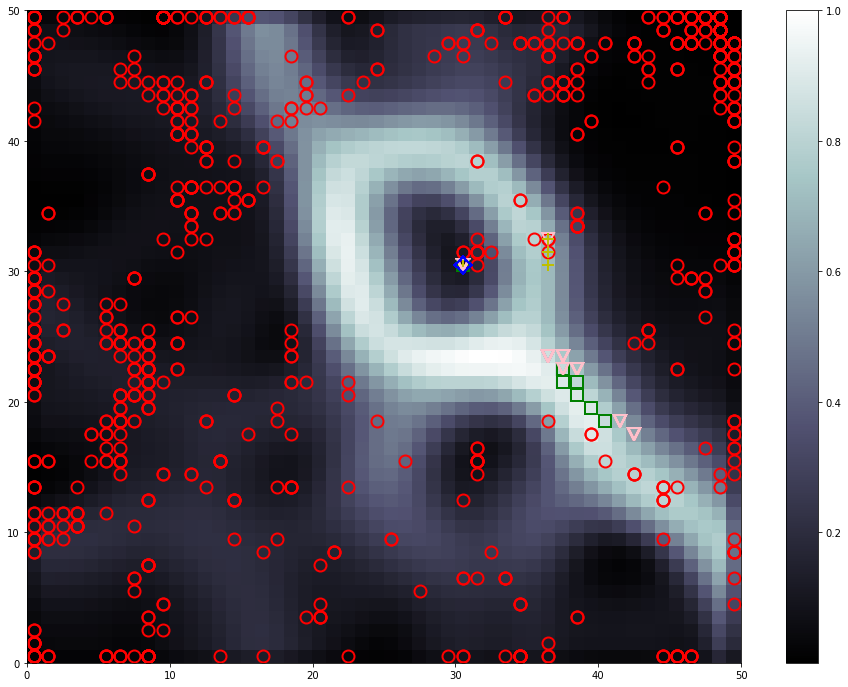

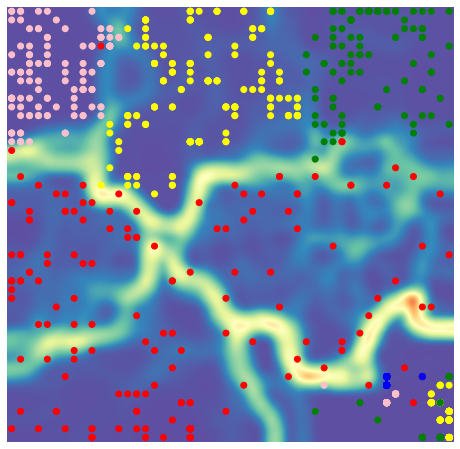

/home/ladin/Projects/research/botnet-traffic-analysis/som_anomaly_detection/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]


sd_benign: 0.06609634668789852, mean_benign: 0.060344845792149146, lim_benign: 0.2586338858558447, pct_benign: 0.37942508576228196


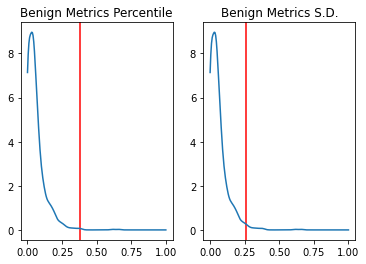

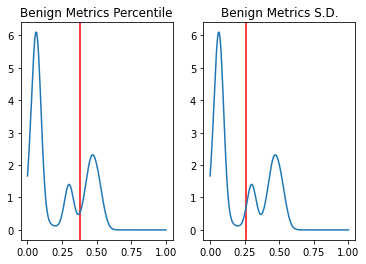

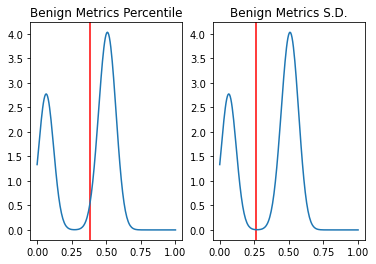

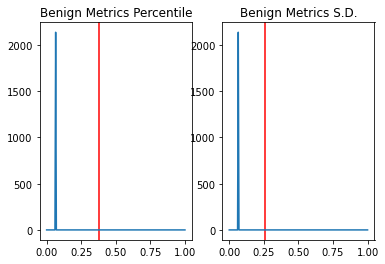

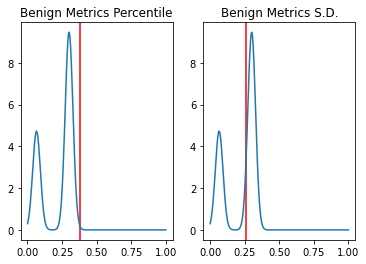

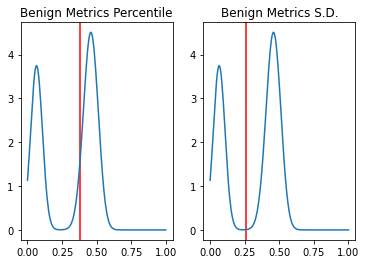

Anomaly detection
benign
Determined:  1.5 % as anomaly
all alnomalies
Determined:  41.91666666666667 % as anomaly
ack
Determined:  62.5 % as anomaly
scan
Determined:  0.0 % as anomaly
syn
Determined:  67.0 % as anomaly
udp
Determined:  60.3 % as anomaly


In [8]:
other_main(choose_folder=nbaiot_1K_data_path, choose_index=1)

(10000, 115) (10000, 115) (10000, 115) (10000, 115) (20000, 115)


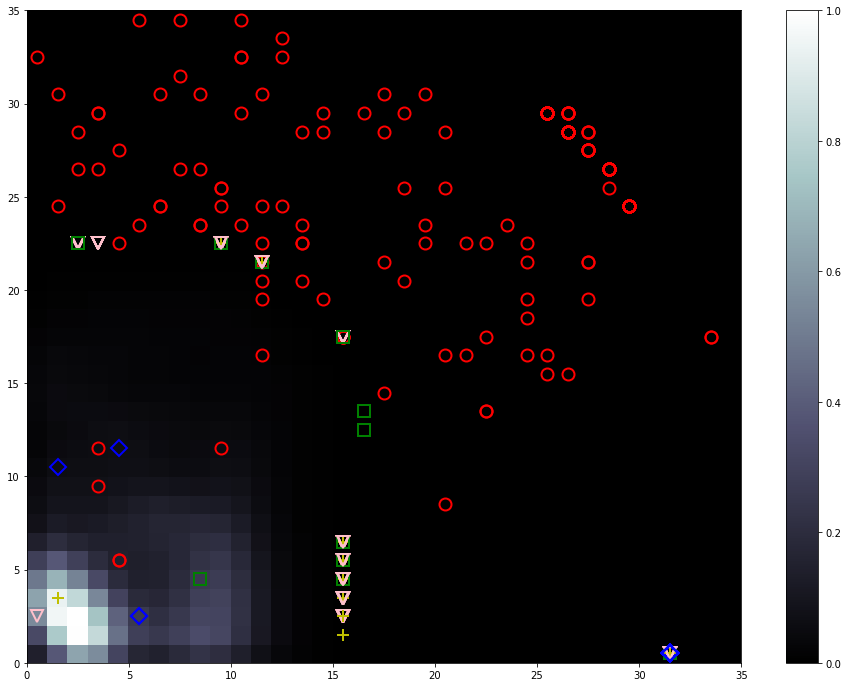

Number of feature:  37
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-04, 2.36581219e-01, 0.00000000e+00, ...,
        2.36581219e-01, 2.36334376e-01, 2.31648968e-01],
       [1.25078309e-03, 2.35667772e-01, 2.34990080e-02, ...,
        2.35787639e-01, 2.35365380e-01, 2.30266677e-01],
       ...,
       [4.37316884e-03, 1.62404883e-01, 6.02179314e-03, ...,
        2.23912300e-01, 1.58329905e-01, 2.23912300e-01],
       [1.30417369e-03, 7.82440010e-02, 5.41921987e-04, ...,
        1.10634853e-01, 7.82306545e-02, 1.10634853e-01],
       [1.53178138e-03, 1.50114575e-01, 0.00000000e+00, ...,
        2.12294068e-01, 1.50114575e-01, 2.12294068e-01]]), 'learning_rate': 2.28210656241811, 'sigma': 5.671952741985809, 'x': 31.304703895261127}
1.1296562645704098
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08]

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-04, 2.36581219e-01, 0.00000000e+00, ...,
        2.36581219e-01, 2.36334376e-01, 2.31648968e-01],
       [1.25078309e-03, 2.35667772e-01, 2.34990080e-02, ...,
        2.35787639e-01, 2.35365380e-01, 2.30266677e-01],
       ...,
       [4.37316884e-03, 1.62404883e-01, 6.02179314e-03, ...,
        2.23912300e-01, 1.58329905e-01, 2.23912300e-01],
       [1.30417369e-03, 7.82440010e-02, 5.41921987e-04, ...,
        1.10634853e-01, 7.82306545e-02, 1.10634853e-01],
       [1.53178138e-03, 1.50114575e-01, 0.00000000e+00, ...,
        2.12294068e-01, 1.50114575e-01, 2.12294068e-01]]), 'learning_rate': 3.3889452983083523, 'sigma': 7.484295543598919, 'x': 48.09705247769425}
1.1090709743083484
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-04, 2.36581219e-01, 0.00000000e+00, ...,
        2.36581219e-01, 2.36334376e-01, 2.31648968e-01],
       [1.25078309e-03, 2.35667772e-01, 2.34990080e-02, ...,
        2.35787639e-01, 2.35365380e-01, 2.30266677e-01],
       ...,
       [4.37316884e-03, 1.62404883e-01, 6.02179314e-03, ...,
        2.23912300e-01, 1.58329905e-01, 2.23912300e-01],
       [1.30417369e-03, 7.82440010e-02, 5.41921987e-04, ...,
        1.10634853e-01, 7.82306545e-02, 1.10634853e-01],
       [1.53178138e-03, 1.50114575e-01, 0.00000000e+00, ...,
        2.12294068e-01, 1.50114575e-01, 2.12294068e-01]]), 'learning_rate': 4.168796332848025, 'sigma': 9.528902020379915, 'x': 37.405617989302144}
1.1283641083968452
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-04, 2.36581219e-01, 0.00000000e+00, ...,
        2.36581219e-01, 2.36334376e-01, 2.31648968e-01],
       [1.25078309e-03, 2.35667772e-01, 2.34990080e-02, ...,
        2.35787639e-01, 2.35365380e-01, 2.30266677e-01],
       ...,
       [4.37316884e-03, 1.62404883e-01, 6.02179314e-03, ...,
        2.23912300e-01, 1.58329905e-01, 2.23912300e-01],
       [1.30417369e-03, 7.82440010e-02, 5.41921987e-04, ...,
        1.10634853e-01, 7.82306545e-02, 1.10634853e-01],
       [1.53178138e-03, 1.50114575e-01, 0.00000000e+00, ...,
        2.12294068e-01, 1.50114575e-01, 2.12294068e-01]]), 'learning_rate': 2.883527153799318, 'sigma': 9.520978017234443, 'x': 49.86244336281748}
1.1106235867992216
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-0

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-04, 2.36581219e-01, 0.00000000e+00, ...,
        2.36581219e-01, 2.36334376e-01, 2.31648968e-01],
       [1.25078309e-03, 2.35667772e-01, 2.34990080e-02, ...,
        2.35787639e-01, 2.35365380e-01, 2.30266677e-01],
       ...,
       [4.37316884e-03, 1.62404883e-01, 6.02179314e-03, ...,
        2.23912300e-01, 1.58329905e-01, 2.23912300e-01],
       [1.30417369e-03, 7.82440010e-02, 5.41921987e-04, ...,
        1.10634853e-01, 7.82306545e-02, 1.10634853e-01],
       [1.53178138e-03, 1.50114575e-01, 0.00000000e+00, ...,
        2.12294068e-01, 1.50114575e-01, 2.12294068e-01]]), 'learning_rate': 4.928147575172128, 'sigma': 9.756151541029386, 'x': 42.07542950675307}
1.0922348390908734
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-0

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-04, 2.36581219e-01, 0.00000000e+00, ...,
        2.36581219e-01, 2.36334376e-01, 2.31648968e-01],
       [1.25078309e-03, 2.35667772e-01, 2.34990080e-02, ...,
        2.35787639e-01, 2.35365380e-01, 2.30266677e-01],
       ...,
       [4.37316884e-03, 1.62404883e-01, 6.02179314e-03, ...,
        2.23912300e-01, 1.58329905e-01, 2.23912300e-01],
       [1.30417369e-03, 7.82440010e-02, 5.41921987e-04, ...,
        1.10634853e-01, 7.82306545e-02, 1.10634853e-01],
       [1.53178138e-03, 1.50114575e-01, 0.00000000e+00, ...,
        2.12294068e-01, 1.50114575e-01, 2.12294068e-01]]), 'learning_rate': 4.4422263095706915, 'sigma': 5.228872565314405, 'x': 43.13247822071623}
1.1160043506445754
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-04, 2.36581219e-01, 0.00000000e+00, ...,
        2.36581219e-01, 2.36334376e-01, 2.31648968e-01],
       [1.25078309e-03, 2.35667772e-01, 2.34990080e-02, ...,
        2.35787639e-01, 2.35365380e-01, 2.30266677e-01],
       ...,
       [4.37316884e-03, 1.62404883e-01, 6.02179314e-03, ...,
        2.23912300e-01, 1.58329905e-01, 2.23912300e-01],
       [1.30417369e-03, 7.82440010e-02, 5.41921987e-04, ...,
        1.10634853e-01, 7.82306545e-02, 1.10634853e-01],
       [1.53178138e-03, 1.50114575e-01, 0.00000000e+00, ...,
        2.12294068e-01, 1.50114575e-01, 2.12294068e-01]]), 'learning_rate': 4.60341809801542, 'sigma': 8.409720598420403, 'x': 48.38025213452763}
1.1246444455722837
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-04

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-04, 2.36581219e-01, 0.00000000e+00, ...,
        2.36581219e-01, 2.36334376e-01, 2.31648968e-01],
       [1.25078309e-03, 2.35667772e-01, 2.34990080e-02, ...,
        2.35787639e-01, 2.35365380e-01, 2.30266677e-01],
       ...,
       [4.37316884e-03, 1.62404883e-01, 6.02179314e-03, ...,
        2.23912300e-01, 1.58329905e-01, 2.23912300e-01],
       [1.30417369e-03, 7.82440010e-02, 5.41921987e-04, ...,
        1.10634853e-01, 7.82306545e-02, 1.10634853e-01],
       [1.53178138e-03, 1.50114575e-01, 0.00000000e+00, ...,
        2.12294068e-01, 1.50114575e-01, 2.12294068e-01]]), 'learning_rate': 3.4588220548121384, 'sigma': 8.772668046989653, 'x': 40.86420772005233}
1.1172908562652002
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-04, 2.36581219e-01, 0.00000000e+00, ...,
        2.36581219e-01, 2.36334376e-01, 2.31648968e-01],
       [1.25078309e-03, 2.35667772e-01, 2.34990080e-02, ...,
        2.35787639e-01, 2.35365380e-01, 2.30266677e-01],
       ...,
       [4.37316884e-03, 1.62404883e-01, 6.02179314e-03, ...,
        2.23912300e-01, 1.58329905e-01, 2.23912300e-01],
       [1.30417369e-03, 7.82440010e-02, 5.41921987e-04, ...,
        1.10634853e-01, 7.82306545e-02, 1.10634853e-01],
       [1.53178138e-03, 1.50114575e-01, 0.00000000e+00, ...,
        2.12294068e-01, 1.50114575e-01, 2.12294068e-01]]), 'learning_rate': 4.721158254878921, 'sigma': 6.953757698869963, 'x': 38.352493158311745}
1.1215388667003672
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-04, 2.36581219e-01, 0.00000000e+00, ...,
        2.36581219e-01, 2.36334376e-01, 2.31648968e-01],
       [1.25078309e-03, 2.35667772e-01, 2.34990080e-02, ...,
        2.35787639e-01, 2.35365380e-01, 2.30266677e-01],
       ...,
       [4.37316884e-03, 1.62404883e-01, 6.02179314e-03, ...,
        2.23912300e-01, 1.58329905e-01, 2.23912300e-01],
       [1.30417369e-03, 7.82440010e-02, 5.41921987e-04, ...,
        1.10634853e-01, 7.82306545e-02, 1.10634853e-01],
       [1.53178138e-03, 1.50114575e-01, 0.00000000e+00, ...,
        2.12294068e-01, 1.50114575e-01, 2.12294068e-01]]), 'learning_rate': 3.0041224662717125, 'sigma': 8.438220834516077, 'x': 48.52434576842861}
1.1095142537531997
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-04, 2.36581219e-01, 0.00000000e+00, ...,
        2.36581219e-01, 2.36334376e-01, 2.31648968e-01],
       [1.25078309e-03, 2.35667772e-01, 2.34990080e-02, ...,
        2.35787639e-01, 2.35365380e-01, 2.30266677e-01],
       ...,
       [4.37316884e-03, 1.62404883e-01, 6.02179314e-03, ...,
        2.23912300e-01, 1.58329905e-01, 2.23912300e-01],
       [1.30417369e-03, 7.82440010e-02, 5.41921987e-04, ...,
        1.10634853e-01, 7.82306545e-02, 1.10634853e-01],
       [1.53178138e-03, 1.50114575e-01, 0.00000000e+00, ...,
        2.12294068e-01, 1.50114575e-01, 2.12294068e-01]]), 'learning_rate': 2.770201250690107, 'sigma': 8.783845686042213, 'x': 42.65576936215542}
1.1180347113873224
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-0

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-04, 2.36581219e-01, 0.00000000e+00, ...,
        2.36581219e-01, 2.36334376e-01, 2.31648968e-01],
       [1.25078309e-03, 2.35667772e-01, 2.34990080e-02, ...,
        2.35787639e-01, 2.35365380e-01, 2.30266677e-01],
       ...,
       [4.37316884e-03, 1.62404883e-01, 6.02179314e-03, ...,
        2.23912300e-01, 1.58329905e-01, 2.23912300e-01],
       [1.30417369e-03, 7.82440010e-02, 5.41921987e-04, ...,
        1.10634853e-01, 7.82306545e-02, 1.10634853e-01],
       [1.53178138e-03, 1.50114575e-01, 0.00000000e+00, ...,
        2.12294068e-01, 1.50114575e-01, 2.12294068e-01]]), 'learning_rate': 0.6191730204785841, 'sigma': 9.360476090240132, 'x': 42.27892231506171}
1.1368875083521148
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-04, 2.36581219e-01, 0.00000000e+00, ...,
        2.36581219e-01, 2.36334376e-01, 2.31648968e-01],
       [1.25078309e-03, 2.35667772e-01, 2.34990080e-02, ...,
        2.35787639e-01, 2.35365380e-01, 2.30266677e-01],
       ...,
       [4.37316884e-03, 1.62404883e-01, 6.02179314e-03, ...,
        2.23912300e-01, 1.58329905e-01, 2.23912300e-01],
       [1.30417369e-03, 7.82440010e-02, 5.41921987e-04, ...,
        1.10634853e-01, 7.82306545e-02, 1.10634853e-01],
       [1.53178138e-03, 1.50114575e-01, 0.00000000e+00, ...,
        2.12294068e-01, 1.50114575e-01, 2.12294068e-01]]), 'learning_rate': 1.5466451723731311, 'sigma': 9.771155520580015, 'x': 47.838850975532395}
1.1227688832902576
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-04, 2.36581219e-01, 0.00000000e+00, ...,
        2.36581219e-01, 2.36334376e-01, 2.31648968e-01],
       [1.25078309e-03, 2.35667772e-01, 2.34990080e-02, ...,
        2.35787639e-01, 2.35365380e-01, 2.30266677e-01],
       ...,
       [4.37316884e-03, 1.62404883e-01, 6.02179314e-03, ...,
        2.23912300e-01, 1.58329905e-01, 2.23912300e-01],
       [1.30417369e-03, 7.82440010e-02, 5.41921987e-04, ...,
        1.10634853e-01, 7.82306545e-02, 1.10634853e-01],
       [1.53178138e-03, 1.50114575e-01, 0.00000000e+00, ...,
        2.12294068e-01, 1.50114575e-01, 2.12294068e-01]]), 'learning_rate': 1.4961055715243032, 'sigma': 9.367345619404844, 'x': 43.099319270311774}
1.1137781678244867
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-04, 2.36581219e-01, 0.00000000e+00, ...,
        2.36581219e-01, 2.36334376e-01, 2.31648968e-01],
       [1.25078309e-03, 2.35667772e-01, 2.34990080e-02, ...,
        2.35787639e-01, 2.35365380e-01, 2.30266677e-01],
       ...,
       [4.37316884e-03, 1.62404883e-01, 6.02179314e-03, ...,
        2.23912300e-01, 1.58329905e-01, 2.23912300e-01],
       [1.30417369e-03, 7.82440010e-02, 5.41921987e-04, ...,
        1.10634853e-01, 7.82306545e-02, 1.10634853e-01],
       [1.53178138e-03, 1.50114575e-01, 0.00000000e+00, ...,
        2.12294068e-01, 1.50114575e-01, 2.12294068e-01]]), 'learning_rate': 1.3279842302704132, 'sigma': 9.804774516781805, 'x': 47.84761154113641}
1.1034564570689533
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-04, 2.36581219e-01, 0.00000000e+00, ...,
        2.36581219e-01, 2.36334376e-01, 2.31648968e-01],
       [1.25078309e-03, 2.35667772e-01, 2.34990080e-02, ...,
        2.35787639e-01, 2.35365380e-01, 2.30266677e-01],
       ...,
       [4.37316884e-03, 1.62404883e-01, 6.02179314e-03, ...,
        2.23912300e-01, 1.58329905e-01, 2.23912300e-01],
       [1.30417369e-03, 7.82440010e-02, 5.41921987e-04, ...,
        1.10634853e-01, 7.82306545e-02, 1.10634853e-01],
       [1.53178138e-03, 1.50114575e-01, 0.00000000e+00, ...,
        2.12294068e-01, 1.50114575e-01, 2.12294068e-01]]), 'learning_rate': 1.6630248982628024, 'sigma': 9.79339374433477, 'x': 45.623643505144464}
1.116540880886795
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-0

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-04, 2.36581219e-01, 0.00000000e+00, ...,
        2.36581219e-01, 2.36334376e-01, 2.31648968e-01],
       [1.25078309e-03, 2.35667772e-01, 2.34990080e-02, ...,
        2.35787639e-01, 2.35365380e-01, 2.30266677e-01],
       ...,
       [4.37316884e-03, 1.62404883e-01, 6.02179314e-03, ...,
        2.23912300e-01, 1.58329905e-01, 2.23912300e-01],
       [1.30417369e-03, 7.82440010e-02, 5.41921987e-04, ...,
        1.10634853e-01, 7.82306545e-02, 1.10634853e-01],
       [1.53178138e-03, 1.50114575e-01, 0.00000000e+00, ...,
        2.12294068e-01, 1.50114575e-01, 2.12294068e-01]]), 'learning_rate': 1.3964714310732416, 'sigma': 7.224546921568887, 'x': 47.571328342750824}
1.1219081702613911
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-04, 2.36581219e-01, 0.00000000e+00, ...,
        2.36581219e-01, 2.36334376e-01, 2.31648968e-01],
       [1.25078309e-03, 2.35667772e-01, 2.34990080e-02, ...,
        2.35787639e-01, 2.35365380e-01, 2.30266677e-01],
       ...,
       [4.37316884e-03, 1.62404883e-01, 6.02179314e-03, ...,
        2.23912300e-01, 1.58329905e-01, 2.23912300e-01],
       [1.30417369e-03, 7.82440010e-02, 5.41921987e-04, ...,
        1.10634853e-01, 7.82306545e-02, 1.10634853e-01],
       [1.53178138e-03, 1.50114575e-01, 0.00000000e+00, ...,
        2.12294068e-01, 1.50114575e-01, 2.12294068e-01]]), 'learning_rate': 3.440732359489144, 'sigma': 8.866597227439543, 'x': 49.607249505984285}
1.081268928460707
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-0

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-04, 2.36581219e-01, 0.00000000e+00, ...,
        2.36581219e-01, 2.36334376e-01, 2.31648968e-01],
       [1.25078309e-03, 2.35667772e-01, 2.34990080e-02, ...,
        2.35787639e-01, 2.35365380e-01, 2.30266677e-01],
       ...,
       [4.37316884e-03, 1.62404883e-01, 6.02179314e-03, ...,
        2.23912300e-01, 1.58329905e-01, 2.23912300e-01],
       [1.30417369e-03, 7.82440010e-02, 5.41921987e-04, ...,
        1.10634853e-01, 7.82306545e-02, 1.10634853e-01],
       [1.53178138e-03, 1.50114575e-01, 0.00000000e+00, ...,
        2.12294068e-01, 1.50114575e-01, 2.12294068e-01]]), 'learning_rate': 1.7315400591855787, 'sigma': 8.616643587242393, 'x': 45.703345314871584}
1.1066864569967405
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-04, 2.36581219e-01, 0.00000000e+00, ...,
        2.36581219e-01, 2.36334376e-01, 2.31648968e-01],
       [1.25078309e-03, 2.35667772e-01, 2.34990080e-02, ...,
        2.35787639e-01, 2.35365380e-01, 2.30266677e-01],
       ...,
       [4.37316884e-03, 1.62404883e-01, 6.02179314e-03, ...,
        2.23912300e-01, 1.58329905e-01, 2.23912300e-01],
       [1.30417369e-03, 7.82440010e-02, 5.41921987e-04, ...,
        1.10634853e-01, 7.82306545e-02, 1.10634853e-01],
       [1.53178138e-03, 1.50114575e-01, 0.00000000e+00, ...,
        2.12294068e-01, 1.50114575e-01, 2.12294068e-01]]), 'learning_rate': 0.5348213602460523, 'sigma': 5.1597040040242526, 'x': 35.692292999027785}
1.1122345942428953
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-04, 2.36581219e-01, 0.00000000e+00, ...,
        2.36581219e-01, 2.36334376e-01, 2.31648968e-01],
       [1.25078309e-03, 2.35667772e-01, 2.34990080e-02, ...,
        2.35787639e-01, 2.35365380e-01, 2.30266677e-01],
       ...,
       [4.37316884e-03, 1.62404883e-01, 6.02179314e-03, ...,
        2.23912300e-01, 1.58329905e-01, 2.23912300e-01],
       [1.30417369e-03, 7.82440010e-02, 5.41921987e-04, ...,
        1.10634853e-01, 7.82306545e-02, 1.10634853e-01],
       [1.53178138e-03, 1.50114575e-01, 0.00000000e+00, ...,
        2.12294068e-01, 1.50114575e-01, 2.12294068e-01]]), 'learning_rate': 3.759387029367198, 'sigma': 6.057511084624926, 'x': 30.087555218235828}
1.1403224625813735
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-04, 2.36581219e-01, 0.00000000e+00, ...,
        2.36581219e-01, 2.36334376e-01, 2.31648968e-01],
       [1.25078309e-03, 2.35667772e-01, 2.34990080e-02, ...,
        2.35787639e-01, 2.35365380e-01, 2.30266677e-01],
       ...,
       [4.37316884e-03, 1.62404883e-01, 6.02179314e-03, ...,
        2.23912300e-01, 1.58329905e-01, 2.23912300e-01],
       [1.30417369e-03, 7.82440010e-02, 5.41921987e-04, ...,
        1.10634853e-01, 7.82306545e-02, 1.10634853e-01],
       [1.53178138e-03, 1.50114575e-01, 0.00000000e+00, ...,
        2.12294068e-01, 1.50114575e-01, 2.12294068e-01]]), 'learning_rate': 1.4199317945984284, 'sigma': 7.511451523649425, 'x': 46.268726868134216}
1.0978232154417094
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-04, 2.36581219e-01, 0.00000000e+00, ...,
        2.36581219e-01, 2.36334376e-01, 2.31648968e-01],
       [1.25078309e-03, 2.35667772e-01, 2.34990080e-02, ...,
        2.35787639e-01, 2.35365380e-01, 2.30266677e-01],
       ...,
       [4.37316884e-03, 1.62404883e-01, 6.02179314e-03, ...,
        2.23912300e-01, 1.58329905e-01, 2.23912300e-01],
       [1.30417369e-03, 7.82440010e-02, 5.41921987e-04, ...,
        1.10634853e-01, 7.82306545e-02, 1.10634853e-01],
       [1.53178138e-03, 1.50114575e-01, 0.00000000e+00, ...,
        2.12294068e-01, 1.50114575e-01, 2.12294068e-01]]), 'learning_rate': 0.5409040111133703, 'sigma': 8.73972045504102, 'x': 34.352441842991034}
1.123750044772189
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-0

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-04, 2.36581219e-01, 0.00000000e+00, ...,
        2.36581219e-01, 2.36334376e-01, 2.31648968e-01],
       [1.25078309e-03, 2.35667772e-01, 2.34990080e-02, ...,
        2.35787639e-01, 2.35365380e-01, 2.30266677e-01],
       ...,
       [4.37316884e-03, 1.62404883e-01, 6.02179314e-03, ...,
        2.23912300e-01, 1.58329905e-01, 2.23912300e-01],
       [1.30417369e-03, 7.82440010e-02, 5.41921987e-04, ...,
        1.10634853e-01, 7.82306545e-02, 1.10634853e-01],
       [1.53178138e-03, 1.50114575e-01, 0.00000000e+00, ...,
        2.12294068e-01, 1.50114575e-01, 2.12294068e-01]]), 'learning_rate': 0.3787452018409185, 'sigma': 8.79049996980449, 'x': 32.409181404438854}
1.1060945776477857
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-04, 2.36581219e-01, 0.00000000e+00, ...,
        2.36581219e-01, 2.36334376e-01, 2.31648968e-01],
       [1.25078309e-03, 2.35667772e-01, 2.34990080e-02, ...,
        2.35787639e-01, 2.35365380e-01, 2.30266677e-01],
       ...,
       [4.37316884e-03, 1.62404883e-01, 6.02179314e-03, ...,
        2.23912300e-01, 1.58329905e-01, 2.23912300e-01],
       [1.30417369e-03, 7.82440010e-02, 5.41921987e-04, ...,
        1.10634853e-01, 7.82306545e-02, 1.10634853e-01],
       [1.53178138e-03, 1.50114575e-01, 0.00000000e+00, ...,
        2.12294068e-01, 1.50114575e-01, 2.12294068e-01]]), 'learning_rate': 1.7159484308169093, 'sigma': 9.572327777547436, 'x': 43.198143127139126}
1.110282811059097
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-04, 2.36581219e-01, 0.00000000e+00, ...,
        2.36581219e-01, 2.36334376e-01, 2.31648968e-01],
       [1.25078309e-03, 2.35667772e-01, 2.34990080e-02, ...,
        2.35787639e-01, 2.35365380e-01, 2.30266677e-01],
       ...,
       [4.37316884e-03, 1.62404883e-01, 6.02179314e-03, ...,
        2.23912300e-01, 1.58329905e-01, 2.23912300e-01],
       [1.30417369e-03, 7.82440010e-02, 5.41921987e-04, ...,
        1.10634853e-01, 7.82306545e-02, 1.10634853e-01],
       [1.53178138e-03, 1.50114575e-01, 0.00000000e+00, ...,
        2.12294068e-01, 1.50114575e-01, 2.12294068e-01]]), 'learning_rate': 2.8156452481440573, 'sigma': 5.11645326857564, 'x': 46.473356469918905}
1.1135787659868581
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-04, 2.36581219e-01, 0.00000000e+00, ...,
        2.36581219e-01, 2.36334376e-01, 2.31648968e-01],
       [1.25078309e-03, 2.35667772e-01, 2.34990080e-02, ...,
        2.35787639e-01, 2.35365380e-01, 2.30266677e-01],
       ...,
       [4.37316884e-03, 1.62404883e-01, 6.02179314e-03, ...,
        2.23912300e-01, 1.58329905e-01, 2.23912300e-01],
       [1.30417369e-03, 7.82440010e-02, 5.41921987e-04, ...,
        1.10634853e-01, 7.82306545e-02, 1.10634853e-01],
       [1.53178138e-03, 1.50114575e-01, 0.00000000e+00, ...,
        2.12294068e-01, 1.50114575e-01, 2.12294068e-01]]), 'learning_rate': 3.9539718320486483, 'sigma': 8.75737811979816, 'x': 48.30137691921291}
1.1069378210878578
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-0

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-04, 2.36581219e-01, 0.00000000e+00, ...,
        2.36581219e-01, 2.36334376e-01, 2.31648968e-01],
       [1.25078309e-03, 2.35667772e-01, 2.34990080e-02, ...,
        2.35787639e-01, 2.35365380e-01, 2.30266677e-01],
       ...,
       [4.37316884e-03, 1.62404883e-01, 6.02179314e-03, ...,
        2.23912300e-01, 1.58329905e-01, 2.23912300e-01],
       [1.30417369e-03, 7.82440010e-02, 5.41921987e-04, ...,
        1.10634853e-01, 7.82306545e-02, 1.10634853e-01],
       [1.53178138e-03, 1.50114575e-01, 0.00000000e+00, ...,
        2.12294068e-01, 1.50114575e-01, 2.12294068e-01]]), 'learning_rate': 2.5371194355590765, 'sigma': 5.229566764781467, 'x': 41.04321678303695}
1.1065365013824182
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-04, 2.36581219e-01, 0.00000000e+00, ...,
        2.36581219e-01, 2.36334376e-01, 2.31648968e-01],
       [1.25078309e-03, 2.35667772e-01, 2.34990080e-02, ...,
        2.35787639e-01, 2.35365380e-01, 2.30266677e-01],
       ...,
       [4.37316884e-03, 1.62404883e-01, 6.02179314e-03, ...,
        2.23912300e-01, 1.58329905e-01, 2.23912300e-01],
       [1.30417369e-03, 7.82440010e-02, 5.41921987e-04, ...,
        1.10634853e-01, 7.82306545e-02, 1.10634853e-01],
       [1.53178138e-03, 1.50114575e-01, 0.00000000e+00, ...,
        2.12294068e-01, 1.50114575e-01, 2.12294068e-01]]), 'learning_rate': 1.2116358388912873, 'sigma': 7.024644974623922, 'x': 45.48498562701261}
1.0998022344086122
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-04, 2.36581219e-01, 0.00000000e+00, ...,
        2.36581219e-01, 2.36334376e-01, 2.31648968e-01],
       [1.25078309e-03, 2.35667772e-01, 2.34990080e-02, ...,
        2.35787639e-01, 2.35365380e-01, 2.30266677e-01],
       ...,
       [4.37316884e-03, 1.62404883e-01, 6.02179314e-03, ...,
        2.23912300e-01, 1.58329905e-01, 2.23912300e-01],
       [1.30417369e-03, 7.82440010e-02, 5.41921987e-04, ...,
        1.10634853e-01, 7.82306545e-02, 1.10634853e-01],
       [1.53178138e-03, 1.50114575e-01, 0.00000000e+00, ...,
        2.12294068e-01, 1.50114575e-01, 2.12294068e-01]]), 'learning_rate': 1.8544872777490649, 'sigma': 6.026613375484267, 'x': 41.597072220141484}
1.1316638301274664
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-04, 2.36581219e-01, 0.00000000e+00, ...,
        2.36581219e-01, 2.36334376e-01, 2.31648968e-01],
       [1.25078309e-03, 2.35667772e-01, 2.34990080e-02, ...,
        2.35787639e-01, 2.35365380e-01, 2.30266677e-01],
       ...,
       [4.37316884e-03, 1.62404883e-01, 6.02179314e-03, ...,
        2.23912300e-01, 1.58329905e-01, 2.23912300e-01],
       [1.30417369e-03, 7.82440010e-02, 5.41921987e-04, ...,
        1.10634853e-01, 7.82306545e-02, 1.10634853e-01],
       [1.53178138e-03, 1.50114575e-01, 0.00000000e+00, ...,
        2.12294068e-01, 1.50114575e-01, 2.12294068e-01]]), 'learning_rate': 2.1148436442710663, 'sigma': 5.919947733932371, 'x': 37.57439148396982}
1.1219860865059852
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-04, 2.36581219e-01, 0.00000000e+00, ...,
        2.36581219e-01, 2.36334376e-01, 2.31648968e-01],
       [1.25078309e-03, 2.35667772e-01, 2.34990080e-02, ...,
        2.35787639e-01, 2.35365380e-01, 2.30266677e-01],
       ...,
       [4.37316884e-03, 1.62404883e-01, 6.02179314e-03, ...,
        2.23912300e-01, 1.58329905e-01, 2.23912300e-01],
       [1.30417369e-03, 7.82440010e-02, 5.41921987e-04, ...,
        1.10634853e-01, 7.82306545e-02, 1.10634853e-01],
       [1.53178138e-03, 1.50114575e-01, 0.00000000e+00, ...,
        2.12294068e-01, 1.50114575e-01, 2.12294068e-01]]), 'learning_rate': 3.558909868288898, 'sigma': 7.304287622573064, 'x': 39.02984971023916}
1.128139874252914
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-04

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-04, 2.36581219e-01, 0.00000000e+00, ...,
        2.36581219e-01, 2.36334376e-01, 2.31648968e-01],
       [1.25078309e-03, 2.35667772e-01, 2.34990080e-02, ...,
        2.35787639e-01, 2.35365380e-01, 2.30266677e-01],
       ...,
       [4.37316884e-03, 1.62404883e-01, 6.02179314e-03, ...,
        2.23912300e-01, 1.58329905e-01, 2.23912300e-01],
       [1.30417369e-03, 7.82440010e-02, 5.41921987e-04, ...,
        1.10634853e-01, 7.82306545e-02, 1.10634853e-01],
       [1.53178138e-03, 1.50114575e-01, 0.00000000e+00, ...,
        2.12294068e-01, 1.50114575e-01, 2.12294068e-01]]), 'learning_rate': 2.0208556190806943, 'sigma': 8.528806705798436, 'x': 44.936493550761156}
1.1160573363180184
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-04, 2.36581219e-01, 0.00000000e+00, ...,
        2.36581219e-01, 2.36334376e-01, 2.31648968e-01],
       [1.25078309e-03, 2.35667772e-01, 2.34990080e-02, ...,
        2.35787639e-01, 2.35365380e-01, 2.30266677e-01],
       ...,
       [4.37316884e-03, 1.62404883e-01, 6.02179314e-03, ...,
        2.23912300e-01, 1.58329905e-01, 2.23912300e-01],
       [1.30417369e-03, 7.82440010e-02, 5.41921987e-04, ...,
        1.10634853e-01, 7.82306545e-02, 1.10634853e-01],
       [1.53178138e-03, 1.50114575e-01, 0.00000000e+00, ...,
        2.12294068e-01, 1.50114575e-01, 2.12294068e-01]]), 'learning_rate': 1.9529704535866506, 'sigma': 8.342692531292357, 'x': 33.11001265022404}
1.1283571254993456
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-04, 2.36581219e-01, 0.00000000e+00, ...,
        2.36581219e-01, 2.36334376e-01, 2.31648968e-01],
       [1.25078309e-03, 2.35667772e-01, 2.34990080e-02, ...,
        2.35787639e-01, 2.35365380e-01, 2.30266677e-01],
       ...,
       [4.37316884e-03, 1.62404883e-01, 6.02179314e-03, ...,
        2.23912300e-01, 1.58329905e-01, 2.23912300e-01],
       [1.30417369e-03, 7.82440010e-02, 5.41921987e-04, ...,
        1.10634853e-01, 7.82306545e-02, 1.10634853e-01],
       [1.53178138e-03, 1.50114575e-01, 0.00000000e+00, ...,
        2.12294068e-01, 1.50114575e-01, 2.12294068e-01]]), 'learning_rate': 1.4620269764332643, 'sigma': 5.400844418640692, 'x': 45.83965306435991}
1.1267683939052577
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-04, 2.36581219e-01, 0.00000000e+00, ...,
        2.36581219e-01, 2.36334376e-01, 2.31648968e-01],
       [1.25078309e-03, 2.35667772e-01, 2.34990080e-02, ...,
        2.35787639e-01, 2.35365380e-01, 2.30266677e-01],
       ...,
       [4.37316884e-03, 1.62404883e-01, 6.02179314e-03, ...,
        2.23912300e-01, 1.58329905e-01, 2.23912300e-01],
       [1.30417369e-03, 7.82440010e-02, 5.41921987e-04, ...,
        1.10634853e-01, 7.82306545e-02, 1.10634853e-01],
       [1.53178138e-03, 1.50114575e-01, 0.00000000e+00, ...,
        2.12294068e-01, 1.50114575e-01, 2.12294068e-01]]), 'learning_rate': 1.611687713783011, 'sigma': 5.00628982858848, 'x': 45.88246607829533}
1.1175794103247183
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-04

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-04, 2.36581219e-01, 0.00000000e+00, ...,
        2.36581219e-01, 2.36334376e-01, 2.31648968e-01],
       [1.25078309e-03, 2.35667772e-01, 2.34990080e-02, ...,
        2.35787639e-01, 2.35365380e-01, 2.30266677e-01],
       ...,
       [4.37316884e-03, 1.62404883e-01, 6.02179314e-03, ...,
        2.23912300e-01, 1.58329905e-01, 2.23912300e-01],
       [1.30417369e-03, 7.82440010e-02, 5.41921987e-04, ...,
        1.10634853e-01, 7.82306545e-02, 1.10634853e-01],
       [1.53178138e-03, 1.50114575e-01, 0.00000000e+00, ...,
        2.12294068e-01, 1.50114575e-01, 2.12294068e-01]]), 'learning_rate': 1.9281414872119793, 'sigma': 5.658242929216818, 'x': 45.16421479396858}
1.1126404276218345
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-04, 2.36581219e-01, 0.00000000e+00, ...,
        2.36581219e-01, 2.36334376e-01, 2.31648968e-01],
       [1.25078309e-03, 2.35667772e-01, 2.34990080e-02, ...,
        2.35787639e-01, 2.35365380e-01, 2.30266677e-01],
       ...,
       [4.37316884e-03, 1.62404883e-01, 6.02179314e-03, ...,
        2.23912300e-01, 1.58329905e-01, 2.23912300e-01],
       [1.30417369e-03, 7.82440010e-02, 5.41921987e-04, ...,
        1.10634853e-01, 7.82306545e-02, 1.10634853e-01],
       [1.53178138e-03, 1.50114575e-01, 0.00000000e+00, ...,
        2.12294068e-01, 1.50114575e-01, 2.12294068e-01]]), 'learning_rate': 0.9714452820759514, 'sigma': 6.362665025707798, 'x': 49.12667609771637}
1.1027399015024242
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-04, 2.36581219e-01, 0.00000000e+00, ...,
        2.36581219e-01, 2.36334376e-01, 2.31648968e-01],
       [1.25078309e-03, 2.35667772e-01, 2.34990080e-02, ...,
        2.35787639e-01, 2.35365380e-01, 2.30266677e-01],
       ...,
       [4.37316884e-03, 1.62404883e-01, 6.02179314e-03, ...,
        2.23912300e-01, 1.58329905e-01, 2.23912300e-01],
       [1.30417369e-03, 7.82440010e-02, 5.41921987e-04, ...,
        1.10634853e-01, 7.82306545e-02, 1.10634853e-01],
       [1.53178138e-03, 1.50114575e-01, 0.00000000e+00, ...,
        2.12294068e-01, 1.50114575e-01, 2.12294068e-01]]), 'learning_rate': 1.5321009573445856, 'sigma': 8.391272592486775, 'x': 45.84915820602428}
1.1163955165460242
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-04, 2.36581219e-01, 0.00000000e+00, ...,
        2.36581219e-01, 2.36334376e-01, 2.31648968e-01],
       [1.25078309e-03, 2.35667772e-01, 2.34990080e-02, ...,
        2.35787639e-01, 2.35365380e-01, 2.30266677e-01],
       ...,
       [4.37316884e-03, 1.62404883e-01, 6.02179314e-03, ...,
        2.23912300e-01, 1.58329905e-01, 2.23912300e-01],
       [1.30417369e-03, 7.82440010e-02, 5.41921987e-04, ...,
        1.10634853e-01, 7.82306545e-02, 1.10634853e-01],
       [1.53178138e-03, 1.50114575e-01, 0.00000000e+00, ...,
        2.12294068e-01, 1.50114575e-01, 2.12294068e-01]]), 'learning_rate': 3.1394380683570238, 'sigma': 9.822065875211951, 'x': 47.8249012832139}
1.0902038353209462
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-0

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-04, 2.36581219e-01, 0.00000000e+00, ...,
        2.36581219e-01, 2.36334376e-01, 2.31648968e-01],
       [1.25078309e-03, 2.35667772e-01, 2.34990080e-02, ...,
        2.35787639e-01, 2.35365380e-01, 2.30266677e-01],
       ...,
       [4.37316884e-03, 1.62404883e-01, 6.02179314e-03, ...,
        2.23912300e-01, 1.58329905e-01, 2.23912300e-01],
       [1.30417369e-03, 7.82440010e-02, 5.41921987e-04, ...,
        1.10634853e-01, 7.82306545e-02, 1.10634853e-01],
       [1.53178138e-03, 1.50114575e-01, 0.00000000e+00, ...,
        2.12294068e-01, 1.50114575e-01, 2.12294068e-01]]), 'learning_rate': 0.6650737668664263, 'sigma': 9.620542241173245, 'x': 40.11844893800816}
1.10483864483881
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-04

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-04, 2.36581219e-01, 0.00000000e+00, ...,
        2.36581219e-01, 2.36334376e-01, 2.31648968e-01],
       [1.25078309e-03, 2.35667772e-01, 2.34990080e-02, ...,
        2.35787639e-01, 2.35365380e-01, 2.30266677e-01],
       ...,
       [4.37316884e-03, 1.62404883e-01, 6.02179314e-03, ...,
        2.23912300e-01, 1.58329905e-01, 2.23912300e-01],
       [1.30417369e-03, 7.82440010e-02, 5.41921987e-04, ...,
        1.10634853e-01, 7.82306545e-02, 1.10634853e-01],
       [1.53178138e-03, 1.50114575e-01, 0.00000000e+00, ...,
        2.12294068e-01, 1.50114575e-01, 2.12294068e-01]]), 'learning_rate': 0.9595225866681968, 'sigma': 5.308373453618159, 'x': 40.60816412348499}
1.1014987933627856
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-04, 2.36581219e-01, 0.00000000e+00, ...,
        2.36581219e-01, 2.36334376e-01, 2.31648968e-01],
       [1.25078309e-03, 2.35667772e-01, 2.34990080e-02, ...,
        2.35787639e-01, 2.35365380e-01, 2.30266677e-01],
       ...,
       [4.37316884e-03, 1.62404883e-01, 6.02179314e-03, ...,
        2.23912300e-01, 1.58329905e-01, 2.23912300e-01],
       [1.30417369e-03, 7.82440010e-02, 5.41921987e-04, ...,
        1.10634853e-01, 7.82306545e-02, 1.10634853e-01],
       [1.53178138e-03, 1.50114575e-01, 0.00000000e+00, ...,
        2.12294068e-01, 1.50114575e-01, 2.12294068e-01]]), 'learning_rate': 3.737257367490824, 'sigma': 7.577113655448274, 'x': 36.94765955650075}
1.130756014062301
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 0.00000000e+00, ...,
        1.99247946e-08, 1.99247946e-08, 1.99247946e-08],
       [6.68308528e-04

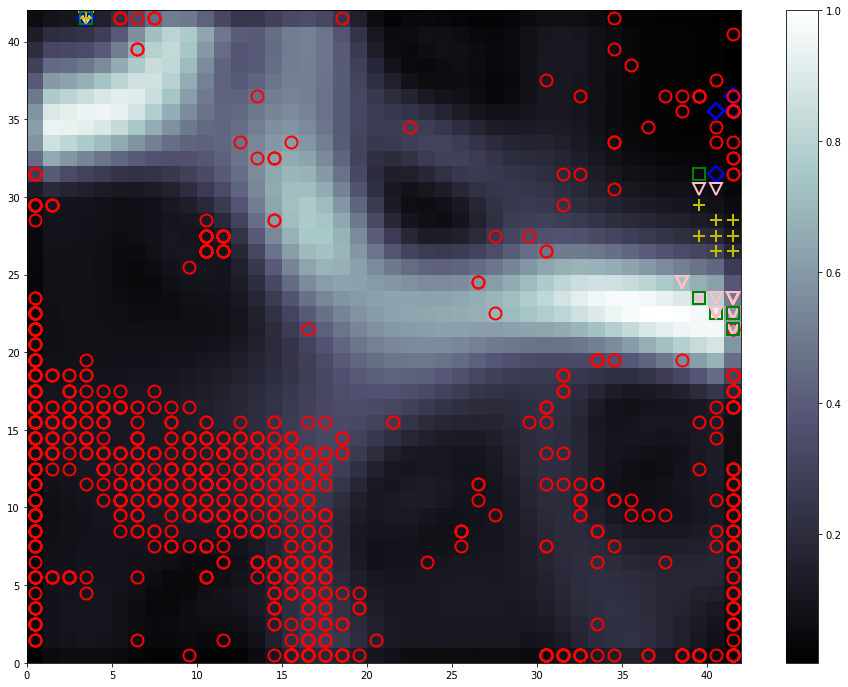

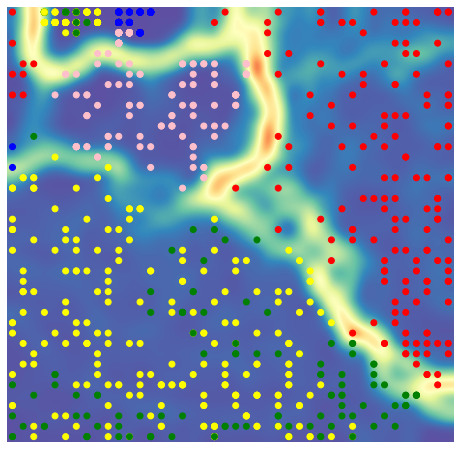

/home/ladin/Projects/research/botnet-traffic-analysis/som_anomaly_detection/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]


sd_benign: 0.04875556609680953, mean_benign: 0.05622100564243945, lim_benign: 0.20248770393286805, pct_benign: 0.4278821048011262


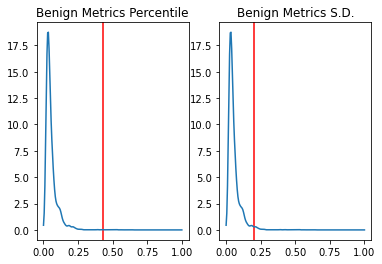

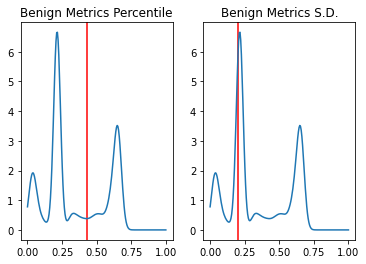

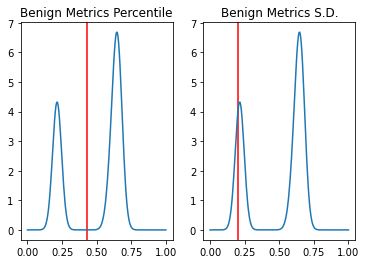

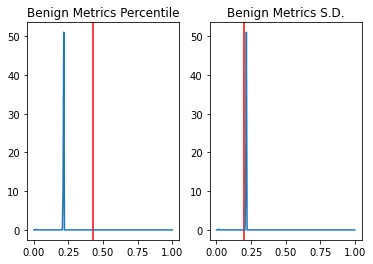

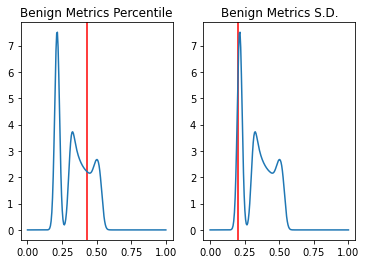

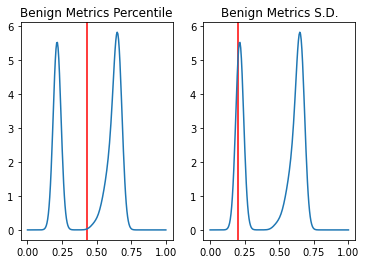

Anomaly detection
benign
Determined:  1.71 % as anomaly
all alnomalies
Determined:  83.42833333333334 % as anomaly
ack
Determined:  99.99 % as anomaly
scan
Determined:  99.86 % as anomaly
syn
Determined:  100.0 % as anomaly
udp
Determined:  100.0 % as anomaly


In [9]:
other_main(choose_folder=nbaiot_10K_data_path, choose_index=1)

(20000, 115) (20000, 115) (20000, 115) (20000, 115) (40000, 115)


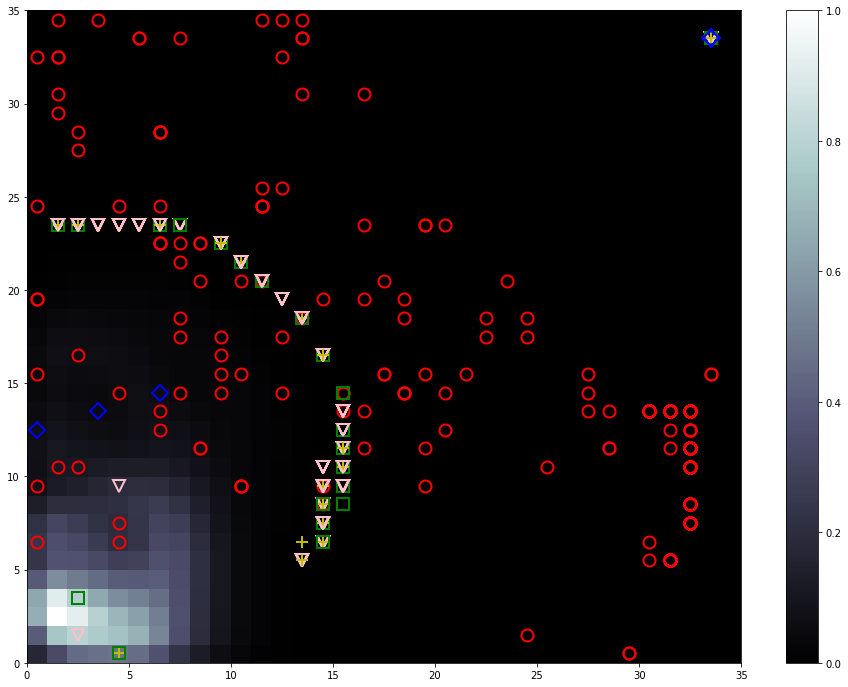

Number of feature:  35
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-04, 2.59829918e-01, 7.33982820e-04, ...,
        2.29331822e-02, 4.25831224e-02, 2.54412978e-01],
       [1.33483737e-03, 2.58980394e-01, 1.37381374e-03, ...,
        1.62036089e-02, 3.50911038e-02, 2.52916374e-01],
       ...,
       [1.54471985e-03, 1.56344674e-01, 1.61456850e-03, ...,
        5.98111335e-02, 4.86107048e-01, 2.21169228e-01],
       [3.11879742e-03, 1.58443844e-01, 3.18958616e-03, ...,
        6.06052873e-02, 4.92624812e-01, 2.24106217e-01],
       [4.71850868e-03, 1.60032382e-01, 4.79019773e-03, ...,
        6.12099611e-02, 4.97477492e-01, 2.26342066e-01]]), 'learning_rate': 0.8303180081364478, 'sigma': 6.04719273759407, 'x': 25.603054570198665}
1.117153479572844
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08]

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-04, 2.59829918e-01, 7.33982820e-04, ...,
        2.29331822e-02, 4.25831224e-02, 2.54412978e-01],
       [1.33483737e-03, 2.58980394e-01, 1.37381374e-03, ...,
        1.62036089e-02, 3.50911038e-02, 2.52916374e-01],
       ...,
       [1.54471985e-03, 1.56344674e-01, 1.61456850e-03, ...,
        5.98111335e-02, 4.86107048e-01, 2.21169228e-01],
       [3.11879742e-03, 1.58443844e-01, 3.18958616e-03, ...,
        6.06052873e-02, 4.92624812e-01, 2.24106217e-01],
       [4.71850868e-03, 1.60032382e-01, 4.79019773e-03, ...,
        6.12099611e-02, 4.97477492e-01, 2.26342066e-01]]), 'learning_rate': 2.6081482551413417, 'sigma': 7.057786448751539, 'x': 31.1153329999091}
1.1164172267643357
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-0

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-04, 2.59829918e-01, 7.33982820e-04, ...,
        2.29331822e-02, 4.25831224e-02, 2.54412978e-01],
       [1.33483737e-03, 2.58980394e-01, 1.37381374e-03, ...,
        1.62036089e-02, 3.50911038e-02, 2.52916374e-01],
       ...,
       [1.54471985e-03, 1.56344674e-01, 1.61456850e-03, ...,
        5.98111335e-02, 4.86107048e-01, 2.21169228e-01],
       [3.11879742e-03, 1.58443844e-01, 3.18958616e-03, ...,
        6.06052873e-02, 4.92624812e-01, 2.24106217e-01],
       [4.71850868e-03, 1.60032382e-01, 4.79019773e-03, ...,
        6.12099611e-02, 4.97477492e-01, 2.26342066e-01]]), 'learning_rate': 3.2831924859199675, 'sigma': 8.180560834248391, 'x': 49.96991920705531}
1.1096808771438802
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-04, 2.59829918e-01, 7.33982820e-04, ...,
        2.29331822e-02, 4.25831224e-02, 2.54412978e-01],
       [1.33483737e-03, 2.58980394e-01, 1.37381374e-03, ...,
        1.62036089e-02, 3.50911038e-02, 2.52916374e-01],
       ...,
       [1.54471985e-03, 1.56344674e-01, 1.61456850e-03, ...,
        5.98111335e-02, 4.86107048e-01, 2.21169228e-01],
       [3.11879742e-03, 1.58443844e-01, 3.18958616e-03, ...,
        6.06052873e-02, 4.92624812e-01, 2.24106217e-01],
       [4.71850868e-03, 1.60032382e-01, 4.79019773e-03, ...,
        6.12099611e-02, 4.97477492e-01, 2.26342066e-01]]), 'learning_rate': 3.593514799992576, 'sigma': 7.639690969241165, 'x': 48.284803981527865}
1.0768837585963937
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-04, 2.59829918e-01, 7.33982820e-04, ...,
        2.29331822e-02, 4.25831224e-02, 2.54412978e-01],
       [1.33483737e-03, 2.58980394e-01, 1.37381374e-03, ...,
        1.62036089e-02, 3.50911038e-02, 2.52916374e-01],
       ...,
       [1.54471985e-03, 1.56344674e-01, 1.61456850e-03, ...,
        5.98111335e-02, 4.86107048e-01, 2.21169228e-01],
       [3.11879742e-03, 1.58443844e-01, 3.18958616e-03, ...,
        6.06052873e-02, 4.92624812e-01, 2.24106217e-01],
       [4.71850868e-03, 1.60032382e-01, 4.79019773e-03, ...,
        6.12099611e-02, 4.97477492e-01, 2.26342066e-01]]), 'learning_rate': 2.7723011372642192, 'sigma': 6.879367461060612, 'x': 42.44802380522026}
1.0902647164781198
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-04, 2.59829918e-01, 7.33982820e-04, ...,
        2.29331822e-02, 4.25831224e-02, 2.54412978e-01],
       [1.33483737e-03, 2.58980394e-01, 1.37381374e-03, ...,
        1.62036089e-02, 3.50911038e-02, 2.52916374e-01],
       ...,
       [1.54471985e-03, 1.56344674e-01, 1.61456850e-03, ...,
        5.98111335e-02, 4.86107048e-01, 2.21169228e-01],
       [3.11879742e-03, 1.58443844e-01, 3.18958616e-03, ...,
        6.06052873e-02, 4.92624812e-01, 2.24106217e-01],
       [4.71850868e-03, 1.60032382e-01, 4.79019773e-03, ...,
        6.12099611e-02, 4.97477492e-01, 2.26342066e-01]]), 'learning_rate': 3.513633523928291, 'sigma': 9.983825302211793, 'x': 43.460458104866376}
1.089725832479189
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-0

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-04, 2.59829918e-01, 7.33982820e-04, ...,
        2.29331822e-02, 4.25831224e-02, 2.54412978e-01],
       [1.33483737e-03, 2.58980394e-01, 1.37381374e-03, ...,
        1.62036089e-02, 3.50911038e-02, 2.52916374e-01],
       ...,
       [1.54471985e-03, 1.56344674e-01, 1.61456850e-03, ...,
        5.98111335e-02, 4.86107048e-01, 2.21169228e-01],
       [3.11879742e-03, 1.58443844e-01, 3.18958616e-03, ...,
        6.06052873e-02, 4.92624812e-01, 2.24106217e-01],
       [4.71850868e-03, 1.60032382e-01, 4.79019773e-03, ...,
        6.12099611e-02, 4.97477492e-01, 2.26342066e-01]]), 'learning_rate': 1.067065228842057, 'sigma': 5.774799103681879, 'x': 48.67816881958203}
1.1081279348906137
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-0

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-04, 2.59829918e-01, 7.33982820e-04, ...,
        2.29331822e-02, 4.25831224e-02, 2.54412978e-01],
       [1.33483737e-03, 2.58980394e-01, 1.37381374e-03, ...,
        1.62036089e-02, 3.50911038e-02, 2.52916374e-01],
       ...,
       [1.54471985e-03, 1.56344674e-01, 1.61456850e-03, ...,
        5.98111335e-02, 4.86107048e-01, 2.21169228e-01],
       [3.11879742e-03, 1.58443844e-01, 3.18958616e-03, ...,
        6.06052873e-02, 4.92624812e-01, 2.24106217e-01],
       [4.71850868e-03, 1.60032382e-01, 4.79019773e-03, ...,
        6.12099611e-02, 4.97477492e-01, 2.26342066e-01]]), 'learning_rate': 2.1064073153288057, 'sigma': 8.052457077945318, 'x': 41.15371892974714}
1.1135063837671422
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-04, 2.59829918e-01, 7.33982820e-04, ...,
        2.29331822e-02, 4.25831224e-02, 2.54412978e-01],
       [1.33483737e-03, 2.58980394e-01, 1.37381374e-03, ...,
        1.62036089e-02, 3.50911038e-02, 2.52916374e-01],
       ...,
       [1.54471985e-03, 1.56344674e-01, 1.61456850e-03, ...,
        5.98111335e-02, 4.86107048e-01, 2.21169228e-01],
       [3.11879742e-03, 1.58443844e-01, 3.18958616e-03, ...,
        6.06052873e-02, 4.92624812e-01, 2.24106217e-01],
       [4.71850868e-03, 1.60032382e-01, 4.79019773e-03, ...,
        6.12099611e-02, 4.97477492e-01, 2.26342066e-01]]), 'learning_rate': 2.189759295073252, 'sigma': 6.504318054663302, 'x': 47.531095452558596}
1.1124483318491216
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-04, 2.59829918e-01, 7.33982820e-04, ...,
        2.29331822e-02, 4.25831224e-02, 2.54412978e-01],
       [1.33483737e-03, 2.58980394e-01, 1.37381374e-03, ...,
        1.62036089e-02, 3.50911038e-02, 2.52916374e-01],
       ...,
       [1.54471985e-03, 1.56344674e-01, 1.61456850e-03, ...,
        5.98111335e-02, 4.86107048e-01, 2.21169228e-01],
       [3.11879742e-03, 1.58443844e-01, 3.18958616e-03, ...,
        6.06052873e-02, 4.92624812e-01, 2.24106217e-01],
       [4.71850868e-03, 1.60032382e-01, 4.79019773e-03, ...,
        6.12099611e-02, 4.97477492e-01, 2.26342066e-01]]), 'learning_rate': 2.9539234892596182, 'sigma': 6.008414670805415, 'x': 38.58369419247358}
1.0993041836111737
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-04, 2.59829918e-01, 7.33982820e-04, ...,
        2.29331822e-02, 4.25831224e-02, 2.54412978e-01],
       [1.33483737e-03, 2.58980394e-01, 1.37381374e-03, ...,
        1.62036089e-02, 3.50911038e-02, 2.52916374e-01],
       ...,
       [1.54471985e-03, 1.56344674e-01, 1.61456850e-03, ...,
        5.98111335e-02, 4.86107048e-01, 2.21169228e-01],
       [3.11879742e-03, 1.58443844e-01, 3.18958616e-03, ...,
        6.06052873e-02, 4.92624812e-01, 2.24106217e-01],
       [4.71850868e-03, 1.60032382e-01, 4.79019773e-03, ...,
        6.12099611e-02, 4.97477492e-01, 2.26342066e-01]]), 'learning_rate': 0.619764441901705, 'sigma': 7.517314157244105, 'x': 30.626982861479902}
1.1159163451038259
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-04, 2.59829918e-01, 7.33982820e-04, ...,
        2.29331822e-02, 4.25831224e-02, 2.54412978e-01],
       [1.33483737e-03, 2.58980394e-01, 1.37381374e-03, ...,
        1.62036089e-02, 3.50911038e-02, 2.52916374e-01],
       ...,
       [1.54471985e-03, 1.56344674e-01, 1.61456850e-03, ...,
        5.98111335e-02, 4.86107048e-01, 2.21169228e-01],
       [3.11879742e-03, 1.58443844e-01, 3.18958616e-03, ...,
        6.06052873e-02, 4.92624812e-01, 2.24106217e-01],
       [4.71850868e-03, 1.60032382e-01, 4.79019773e-03, ...,
        6.12099611e-02, 4.97477492e-01, 2.26342066e-01]]), 'learning_rate': 3.5931331570015095, 'sigma': 5.3085647818240895, 'x': 43.28256531330228}
1.09454194543382
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-0

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-04, 2.59829918e-01, 7.33982820e-04, ...,
        2.29331822e-02, 4.25831224e-02, 2.54412978e-01],
       [1.33483737e-03, 2.58980394e-01, 1.37381374e-03, ...,
        1.62036089e-02, 3.50911038e-02, 2.52916374e-01],
       ...,
       [1.54471985e-03, 1.56344674e-01, 1.61456850e-03, ...,
        5.98111335e-02, 4.86107048e-01, 2.21169228e-01],
       [3.11879742e-03, 1.58443844e-01, 3.18958616e-03, ...,
        6.06052873e-02, 4.92624812e-01, 2.24106217e-01],
       [4.71850868e-03, 1.60032382e-01, 4.79019773e-03, ...,
        6.12099611e-02, 4.97477492e-01, 2.26342066e-01]]), 'learning_rate': 4.924396370793833, 'sigma': 5.062328276997655, 'x': 31.424553679243587}
1.107031327108301
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-0

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-04, 2.59829918e-01, 7.33982820e-04, ...,
        2.29331822e-02, 4.25831224e-02, 2.54412978e-01],
       [1.33483737e-03, 2.58980394e-01, 1.37381374e-03, ...,
        1.62036089e-02, 3.50911038e-02, 2.52916374e-01],
       ...,
       [1.54471985e-03, 1.56344674e-01, 1.61456850e-03, ...,
        5.98111335e-02, 4.86107048e-01, 2.21169228e-01],
       [3.11879742e-03, 1.58443844e-01, 3.18958616e-03, ...,
        6.06052873e-02, 4.92624812e-01, 2.24106217e-01],
       [4.71850868e-03, 1.60032382e-01, 4.79019773e-03, ...,
        6.12099611e-02, 4.97477492e-01, 2.26342066e-01]]), 'learning_rate': 2.3860252535413133, 'sigma': 7.064766121719012, 'x': 36.04064763000415}
1.1116878246206077
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-04, 2.59829918e-01, 7.33982820e-04, ...,
        2.29331822e-02, 4.25831224e-02, 2.54412978e-01],
       [1.33483737e-03, 2.58980394e-01, 1.37381374e-03, ...,
        1.62036089e-02, 3.50911038e-02, 2.52916374e-01],
       ...,
       [1.54471985e-03, 1.56344674e-01, 1.61456850e-03, ...,
        5.98111335e-02, 4.86107048e-01, 2.21169228e-01],
       [3.11879742e-03, 1.58443844e-01, 3.18958616e-03, ...,
        6.06052873e-02, 4.92624812e-01, 2.24106217e-01],
       [4.71850868e-03, 1.60032382e-01, 4.79019773e-03, ...,
        6.12099611e-02, 4.97477492e-01, 2.26342066e-01]]), 'learning_rate': 1.2602523149330267, 'sigma': 9.752745227189092, 'x': 42.74384202459287}
1.0889731227995454
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-04, 2.59829918e-01, 7.33982820e-04, ...,
        2.29331822e-02, 4.25831224e-02, 2.54412978e-01],
       [1.33483737e-03, 2.58980394e-01, 1.37381374e-03, ...,
        1.62036089e-02, 3.50911038e-02, 2.52916374e-01],
       ...,
       [1.54471985e-03, 1.56344674e-01, 1.61456850e-03, ...,
        5.98111335e-02, 4.86107048e-01, 2.21169228e-01],
       [3.11879742e-03, 1.58443844e-01, 3.18958616e-03, ...,
        6.06052873e-02, 4.92624812e-01, 2.24106217e-01],
       [4.71850868e-03, 1.60032382e-01, 4.79019773e-03, ...,
        6.12099611e-02, 4.97477492e-01, 2.26342066e-01]]), 'learning_rate': 4.274370160439903, 'sigma': 7.6040913824563745, 'x': 42.555625507197774}
1.102181967961395
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-04, 2.59829918e-01, 7.33982820e-04, ...,
        2.29331822e-02, 4.25831224e-02, 2.54412978e-01],
       [1.33483737e-03, 2.58980394e-01, 1.37381374e-03, ...,
        1.62036089e-02, 3.50911038e-02, 2.52916374e-01],
       ...,
       [1.54471985e-03, 1.56344674e-01, 1.61456850e-03, ...,
        5.98111335e-02, 4.86107048e-01, 2.21169228e-01],
       [3.11879742e-03, 1.58443844e-01, 3.18958616e-03, ...,
        6.06052873e-02, 4.92624812e-01, 2.24106217e-01],
       [4.71850868e-03, 1.60032382e-01, 4.79019773e-03, ...,
        6.12099611e-02, 4.97477492e-01, 2.26342066e-01]]), 'learning_rate': 4.986279186043827, 'sigma': 8.747096406406282, 'x': 41.170212954267086}
1.1012214137858434
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-04, 2.59829918e-01, 7.33982820e-04, ...,
        2.29331822e-02, 4.25831224e-02, 2.54412978e-01],
       [1.33483737e-03, 2.58980394e-01, 1.37381374e-03, ...,
        1.62036089e-02, 3.50911038e-02, 2.52916374e-01],
       ...,
       [1.54471985e-03, 1.56344674e-01, 1.61456850e-03, ...,
        5.98111335e-02, 4.86107048e-01, 2.21169228e-01],
       [3.11879742e-03, 1.58443844e-01, 3.18958616e-03, ...,
        6.06052873e-02, 4.92624812e-01, 2.24106217e-01],
       [4.71850868e-03, 1.60032382e-01, 4.79019773e-03, ...,
        6.12099611e-02, 4.97477492e-01, 2.26342066e-01]]), 'learning_rate': 0.2008801483380136, 'sigma': 8.373698346962652, 'x': 23.687765396607702}
1.1291985121048032
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-04, 2.59829918e-01, 7.33982820e-04, ...,
        2.29331822e-02, 4.25831224e-02, 2.54412978e-01],
       [1.33483737e-03, 2.58980394e-01, 1.37381374e-03, ...,
        1.62036089e-02, 3.50911038e-02, 2.52916374e-01],
       ...,
       [1.54471985e-03, 1.56344674e-01, 1.61456850e-03, ...,
        5.98111335e-02, 4.86107048e-01, 2.21169228e-01],
       [3.11879742e-03, 1.58443844e-01, 3.18958616e-03, ...,
        6.06052873e-02, 4.92624812e-01, 2.24106217e-01],
       [4.71850868e-03, 1.60032382e-01, 4.79019773e-03, ...,
        6.12099611e-02, 4.97477492e-01, 2.26342066e-01]]), 'learning_rate': 4.0376051656528045, 'sigma': 6.165491732155985, 'x': 37.31612084810308}
1.1091353845681011
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-04, 2.59829918e-01, 7.33982820e-04, ...,
        2.29331822e-02, 4.25831224e-02, 2.54412978e-01],
       [1.33483737e-03, 2.58980394e-01, 1.37381374e-03, ...,
        1.62036089e-02, 3.50911038e-02, 2.52916374e-01],
       ...,
       [1.54471985e-03, 1.56344674e-01, 1.61456850e-03, ...,
        5.98111335e-02, 4.86107048e-01, 2.21169228e-01],
       [3.11879742e-03, 1.58443844e-01, 3.18958616e-03, ...,
        6.06052873e-02, 4.92624812e-01, 2.24106217e-01],
       [4.71850868e-03, 1.60032382e-01, 4.79019773e-03, ...,
        6.12099611e-02, 4.97477492e-01, 2.26342066e-01]]), 'learning_rate': 3.145245349025516, 'sigma': 7.315788148456138, 'x': 41.62176360889653}
1.1144256987652938
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-0

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-04, 2.59829918e-01, 7.33982820e-04, ...,
        2.29331822e-02, 4.25831224e-02, 2.54412978e-01],
       [1.33483737e-03, 2.58980394e-01, 1.37381374e-03, ...,
        1.62036089e-02, 3.50911038e-02, 2.52916374e-01],
       ...,
       [1.54471985e-03, 1.56344674e-01, 1.61456850e-03, ...,
        5.98111335e-02, 4.86107048e-01, 2.21169228e-01],
       [3.11879742e-03, 1.58443844e-01, 3.18958616e-03, ...,
        6.06052873e-02, 4.92624812e-01, 2.24106217e-01],
       [4.71850868e-03, 1.60032382e-01, 4.79019773e-03, ...,
        6.12099611e-02, 4.97477492e-01, 2.26342066e-01]]), 'learning_rate': 1.5731798597627518, 'sigma': 6.496975863121718, 'x': 39.22688569487975}
1.0990605767217323
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-04, 2.59829918e-01, 7.33982820e-04, ...,
        2.29331822e-02, 4.25831224e-02, 2.54412978e-01],
       [1.33483737e-03, 2.58980394e-01, 1.37381374e-03, ...,
        1.62036089e-02, 3.50911038e-02, 2.52916374e-01],
       ...,
       [1.54471985e-03, 1.56344674e-01, 1.61456850e-03, ...,
        5.98111335e-02, 4.86107048e-01, 2.21169228e-01],
       [3.11879742e-03, 1.58443844e-01, 3.18958616e-03, ...,
        6.06052873e-02, 4.92624812e-01, 2.24106217e-01],
       [4.71850868e-03, 1.60032382e-01, 4.79019773e-03, ...,
        6.12099611e-02, 4.97477492e-01, 2.26342066e-01]]), 'learning_rate': 4.989355064859845, 'sigma': 6.83994902866422, 'x': 20.996626284994655}
1.139583355701296
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-04

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-04, 2.59829918e-01, 7.33982820e-04, ...,
        2.29331822e-02, 4.25831224e-02, 2.54412978e-01],
       [1.33483737e-03, 2.58980394e-01, 1.37381374e-03, ...,
        1.62036089e-02, 3.50911038e-02, 2.52916374e-01],
       ...,
       [1.54471985e-03, 1.56344674e-01, 1.61456850e-03, ...,
        5.98111335e-02, 4.86107048e-01, 2.21169228e-01],
       [3.11879742e-03, 1.58443844e-01, 3.18958616e-03, ...,
        6.06052873e-02, 4.92624812e-01, 2.24106217e-01],
       [4.71850868e-03, 1.60032382e-01, 4.79019773e-03, ...,
        6.12099611e-02, 4.97477492e-01, 2.26342066e-01]]), 'learning_rate': 4.196815585966171, 'sigma': 8.045562460779736, 'x': 35.90646707753443}
1.0971122331019445
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-0

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-04, 2.59829918e-01, 7.33982820e-04, ...,
        2.29331822e-02, 4.25831224e-02, 2.54412978e-01],
       [1.33483737e-03, 2.58980394e-01, 1.37381374e-03, ...,
        1.62036089e-02, 3.50911038e-02, 2.52916374e-01],
       ...,
       [1.54471985e-03, 1.56344674e-01, 1.61456850e-03, ...,
        5.98111335e-02, 4.86107048e-01, 2.21169228e-01],
       [3.11879742e-03, 1.58443844e-01, 3.18958616e-03, ...,
        6.06052873e-02, 4.92624812e-01, 2.24106217e-01],
       [4.71850868e-03, 1.60032382e-01, 4.79019773e-03, ...,
        6.12099611e-02, 4.97477492e-01, 2.26342066e-01]]), 'learning_rate': 4.856264033371188, 'sigma': 7.312414900221061, 'x': 43.789504342697015}
1.1053931391233125
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-04, 2.59829918e-01, 7.33982820e-04, ...,
        2.29331822e-02, 4.25831224e-02, 2.54412978e-01],
       [1.33483737e-03, 2.58980394e-01, 1.37381374e-03, ...,
        1.62036089e-02, 3.50911038e-02, 2.52916374e-01],
       ...,
       [1.54471985e-03, 1.56344674e-01, 1.61456850e-03, ...,
        5.98111335e-02, 4.86107048e-01, 2.21169228e-01],
       [3.11879742e-03, 1.58443844e-01, 3.18958616e-03, ...,
        6.06052873e-02, 4.92624812e-01, 2.24106217e-01],
       [4.71850868e-03, 1.60032382e-01, 4.79019773e-03, ...,
        6.12099611e-02, 4.97477492e-01, 2.26342066e-01]]), 'learning_rate': 4.452614516443053, 'sigma': 6.910084878408516, 'x': 41.07885791193926}
1.0916739799937376
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-0

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-04, 2.59829918e-01, 7.33982820e-04, ...,
        2.29331822e-02, 4.25831224e-02, 2.54412978e-01],
       [1.33483737e-03, 2.58980394e-01, 1.37381374e-03, ...,
        1.62036089e-02, 3.50911038e-02, 2.52916374e-01],
       ...,
       [1.54471985e-03, 1.56344674e-01, 1.61456850e-03, ...,
        5.98111335e-02, 4.86107048e-01, 2.21169228e-01],
       [3.11879742e-03, 1.58443844e-01, 3.18958616e-03, ...,
        6.06052873e-02, 4.92624812e-01, 2.24106217e-01],
       [4.71850868e-03, 1.60032382e-01, 4.79019773e-03, ...,
        6.12099611e-02, 4.97477492e-01, 2.26342066e-01]]), 'learning_rate': 3.4670105437239105, 'sigma': 6.626683975589741, 'x': 46.24852819824452}
1.093916934157419
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-0

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-04, 2.59829918e-01, 7.33982820e-04, ...,
        2.29331822e-02, 4.25831224e-02, 2.54412978e-01],
       [1.33483737e-03, 2.58980394e-01, 1.37381374e-03, ...,
        1.62036089e-02, 3.50911038e-02, 2.52916374e-01],
       ...,
       [1.54471985e-03, 1.56344674e-01, 1.61456850e-03, ...,
        5.98111335e-02, 4.86107048e-01, 2.21169228e-01],
       [3.11879742e-03, 1.58443844e-01, 3.18958616e-03, ...,
        6.06052873e-02, 4.92624812e-01, 2.24106217e-01],
       [4.71850868e-03, 1.60032382e-01, 4.79019773e-03, ...,
        6.12099611e-02, 4.97477492e-01, 2.26342066e-01]]), 'learning_rate': 4.980225552447194, 'sigma': 6.483116506659058, 'x': 36.91243962326185}
1.1230138433679735
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-0

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-04, 2.59829918e-01, 7.33982820e-04, ...,
        2.29331822e-02, 4.25831224e-02, 2.54412978e-01],
       [1.33483737e-03, 2.58980394e-01, 1.37381374e-03, ...,
        1.62036089e-02, 3.50911038e-02, 2.52916374e-01],
       ...,
       [1.54471985e-03, 1.56344674e-01, 1.61456850e-03, ...,
        5.98111335e-02, 4.86107048e-01, 2.21169228e-01],
       [3.11879742e-03, 1.58443844e-01, 3.18958616e-03, ...,
        6.06052873e-02, 4.92624812e-01, 2.24106217e-01],
       [4.71850868e-03, 1.60032382e-01, 4.79019773e-03, ...,
        6.12099611e-02, 4.97477492e-01, 2.26342066e-01]]), 'learning_rate': 0.8864183653238533, 'sigma': 7.624563813887393, 'x': 39.97066999326014}
1.100606382254889
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-0

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-04, 2.59829918e-01, 7.33982820e-04, ...,
        2.29331822e-02, 4.25831224e-02, 2.54412978e-01],
       [1.33483737e-03, 2.58980394e-01, 1.37381374e-03, ...,
        1.62036089e-02, 3.50911038e-02, 2.52916374e-01],
       ...,
       [1.54471985e-03, 1.56344674e-01, 1.61456850e-03, ...,
        5.98111335e-02, 4.86107048e-01, 2.21169228e-01],
       [3.11879742e-03, 1.58443844e-01, 3.18958616e-03, ...,
        6.06052873e-02, 4.92624812e-01, 2.24106217e-01],
       [4.71850868e-03, 1.60032382e-01, 4.79019773e-03, ...,
        6.12099611e-02, 4.97477492e-01, 2.26342066e-01]]), 'learning_rate': 4.36188581368727, 'sigma': 8.250804702400702, 'x': 37.28695631838956}
1.1023566922667716
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-04

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-04, 2.59829918e-01, 7.33982820e-04, ...,
        2.29331822e-02, 4.25831224e-02, 2.54412978e-01],
       [1.33483737e-03, 2.58980394e-01, 1.37381374e-03, ...,
        1.62036089e-02, 3.50911038e-02, 2.52916374e-01],
       ...,
       [1.54471985e-03, 1.56344674e-01, 1.61456850e-03, ...,
        5.98111335e-02, 4.86107048e-01, 2.21169228e-01],
       [3.11879742e-03, 1.58443844e-01, 3.18958616e-03, ...,
        6.06052873e-02, 4.92624812e-01, 2.24106217e-01],
       [4.71850868e-03, 1.60032382e-01, 4.79019773e-03, ...,
        6.12099611e-02, 4.97477492e-01, 2.26342066e-01]]), 'learning_rate': 0.21135904555012552, 'sigma': 7.061920845683971, 'x': 42.17857316927786}
1.109061281346503
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-04, 2.59829918e-01, 7.33982820e-04, ...,
        2.29331822e-02, 4.25831224e-02, 2.54412978e-01],
       [1.33483737e-03, 2.58980394e-01, 1.37381374e-03, ...,
        1.62036089e-02, 3.50911038e-02, 2.52916374e-01],
       ...,
       [1.54471985e-03, 1.56344674e-01, 1.61456850e-03, ...,
        5.98111335e-02, 4.86107048e-01, 2.21169228e-01],
       [3.11879742e-03, 1.58443844e-01, 3.18958616e-03, ...,
        6.06052873e-02, 4.92624812e-01, 2.24106217e-01],
       [4.71850868e-03, 1.60032382e-01, 4.79019773e-03, ...,
        6.12099611e-02, 4.97477492e-01, 2.26342066e-01]]), 'learning_rate': 3.88523556009004, 'sigma': 6.940831681300381, 'x': 40.096549686558284}
1.1038697201719756
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-0

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-04, 2.59829918e-01, 7.33982820e-04, ...,
        2.29331822e-02, 4.25831224e-02, 2.54412978e-01],
       [1.33483737e-03, 2.58980394e-01, 1.37381374e-03, ...,
        1.62036089e-02, 3.50911038e-02, 2.52916374e-01],
       ...,
       [1.54471985e-03, 1.56344674e-01, 1.61456850e-03, ...,
        5.98111335e-02, 4.86107048e-01, 2.21169228e-01],
       [3.11879742e-03, 1.58443844e-01, 3.18958616e-03, ...,
        6.06052873e-02, 4.92624812e-01, 2.24106217e-01],
       [4.71850868e-03, 1.60032382e-01, 4.79019773e-03, ...,
        6.12099611e-02, 4.97477492e-01, 2.26342066e-01]]), 'learning_rate': 4.658443041658941, 'sigma': 7.988132052244864, 'x': 49.5264552626148}
1.0797876131838742
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-04

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-04, 2.59829918e-01, 7.33982820e-04, ...,
        2.29331822e-02, 4.25831224e-02, 2.54412978e-01],
       [1.33483737e-03, 2.58980394e-01, 1.37381374e-03, ...,
        1.62036089e-02, 3.50911038e-02, 2.52916374e-01],
       ...,
       [1.54471985e-03, 1.56344674e-01, 1.61456850e-03, ...,
        5.98111335e-02, 4.86107048e-01, 2.21169228e-01],
       [3.11879742e-03, 1.58443844e-01, 3.18958616e-03, ...,
        6.06052873e-02, 4.92624812e-01, 2.24106217e-01],
       [4.71850868e-03, 1.60032382e-01, 4.79019773e-03, ...,
        6.12099611e-02, 4.97477492e-01, 2.26342066e-01]]), 'learning_rate': 4.7636715903096, 'sigma': 7.8479138688601955, 'x': 37.063041172806415}
1.1156515399408304
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-0

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-04, 2.59829918e-01, 7.33982820e-04, ...,
        2.29331822e-02, 4.25831224e-02, 2.54412978e-01],
       [1.33483737e-03, 2.58980394e-01, 1.37381374e-03, ...,
        1.62036089e-02, 3.50911038e-02, 2.52916374e-01],
       ...,
       [1.54471985e-03, 1.56344674e-01, 1.61456850e-03, ...,
        5.98111335e-02, 4.86107048e-01, 2.21169228e-01],
       [3.11879742e-03, 1.58443844e-01, 3.18958616e-03, ...,
        6.06052873e-02, 4.92624812e-01, 2.24106217e-01],
       [4.71850868e-03, 1.60032382e-01, 4.79019773e-03, ...,
        6.12099611e-02, 4.97477492e-01, 2.26342066e-01]]), 'learning_rate': 1.1625056318107148, 'sigma': 5.233265317110342, 'x': 41.36670161362414}
1.1037912395089995
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-04, 2.59829918e-01, 7.33982820e-04, ...,
        2.29331822e-02, 4.25831224e-02, 2.54412978e-01],
       [1.33483737e-03, 2.58980394e-01, 1.37381374e-03, ...,
        1.62036089e-02, 3.50911038e-02, 2.52916374e-01],
       ...,
       [1.54471985e-03, 1.56344674e-01, 1.61456850e-03, ...,
        5.98111335e-02, 4.86107048e-01, 2.21169228e-01],
       [3.11879742e-03, 1.58443844e-01, 3.18958616e-03, ...,
        6.06052873e-02, 4.92624812e-01, 2.24106217e-01],
       [4.71850868e-03, 1.60032382e-01, 4.79019773e-03, ...,
        6.12099611e-02, 4.97477492e-01, 2.26342066e-01]]), 'learning_rate': 0.9861061570330897, 'sigma': 6.3737522491625125, 'x': 44.771866955313435}
1.0977431912373306
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-04, 2.59829918e-01, 7.33982820e-04, ...,
        2.29331822e-02, 4.25831224e-02, 2.54412978e-01],
       [1.33483737e-03, 2.58980394e-01, 1.37381374e-03, ...,
        1.62036089e-02, 3.50911038e-02, 2.52916374e-01],
       ...,
       [1.54471985e-03, 1.56344674e-01, 1.61456850e-03, ...,
        5.98111335e-02, 4.86107048e-01, 2.21169228e-01],
       [3.11879742e-03, 1.58443844e-01, 3.18958616e-03, ...,
        6.06052873e-02, 4.92624812e-01, 2.24106217e-01],
       [4.71850868e-03, 1.60032382e-01, 4.79019773e-03, ...,
        6.12099611e-02, 4.97477492e-01, 2.26342066e-01]]), 'learning_rate': 1.4777689200679427, 'sigma': 7.213439163272413, 'x': 46.64246704294068}
1.1006970469010218
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-04, 2.59829918e-01, 7.33982820e-04, ...,
        2.29331822e-02, 4.25831224e-02, 2.54412978e-01],
       [1.33483737e-03, 2.58980394e-01, 1.37381374e-03, ...,
        1.62036089e-02, 3.50911038e-02, 2.52916374e-01],
       ...,
       [1.54471985e-03, 1.56344674e-01, 1.61456850e-03, ...,
        5.98111335e-02, 4.86107048e-01, 2.21169228e-01],
       [3.11879742e-03, 1.58443844e-01, 3.18958616e-03, ...,
        6.06052873e-02, 4.92624812e-01, 2.24106217e-01],
       [4.71850868e-03, 1.60032382e-01, 4.79019773e-03, ...,
        6.12099611e-02, 4.97477492e-01, 2.26342066e-01]]), 'learning_rate': 4.989790488498894, 'sigma': 7.617674303464561, 'x': 36.96805552832432}
1.1029466765949962
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-0

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-04, 2.59829918e-01, 7.33982820e-04, ...,
        2.29331822e-02, 4.25831224e-02, 2.54412978e-01],
       [1.33483737e-03, 2.58980394e-01, 1.37381374e-03, ...,
        1.62036089e-02, 3.50911038e-02, 2.52916374e-01],
       ...,
       [1.54471985e-03, 1.56344674e-01, 1.61456850e-03, ...,
        5.98111335e-02, 4.86107048e-01, 2.21169228e-01],
       [3.11879742e-03, 1.58443844e-01, 3.18958616e-03, ...,
        6.06052873e-02, 4.92624812e-01, 2.24106217e-01],
       [4.71850868e-03, 1.60032382e-01, 4.79019773e-03, ...,
        6.12099611e-02, 4.97477492e-01, 2.26342066e-01]]), 'learning_rate': 2.3750978780672294, 'sigma': 6.780345050049078, 'x': 21.729383792970076}
1.105480935152549
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-04, 2.59829918e-01, 7.33982820e-04, ...,
        2.29331822e-02, 4.25831224e-02, 2.54412978e-01],
       [1.33483737e-03, 2.58980394e-01, 1.37381374e-03, ...,
        1.62036089e-02, 3.50911038e-02, 2.52916374e-01],
       ...,
       [1.54471985e-03, 1.56344674e-01, 1.61456850e-03, ...,
        5.98111335e-02, 4.86107048e-01, 2.21169228e-01],
       [3.11879742e-03, 1.58443844e-01, 3.18958616e-03, ...,
        6.06052873e-02, 4.92624812e-01, 2.24106217e-01],
       [4.71850868e-03, 1.60032382e-01, 4.79019773e-03, ...,
        6.12099611e-02, 4.97477492e-01, 2.26342066e-01]]), 'learning_rate': 2.2671260914050535, 'sigma': 6.524799266864143, 'x': 42.25943602005471}
1.1147781543228035
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-04, 2.59829918e-01, 7.33982820e-04, ...,
        2.29331822e-02, 4.25831224e-02, 2.54412978e-01],
       [1.33483737e-03, 2.58980394e-01, 1.37381374e-03, ...,
        1.62036089e-02, 3.50911038e-02, 2.52916374e-01],
       ...,
       [1.54471985e-03, 1.56344674e-01, 1.61456850e-03, ...,
        5.98111335e-02, 4.86107048e-01, 2.21169228e-01],
       [3.11879742e-03, 1.58443844e-01, 3.18958616e-03, ...,
        6.06052873e-02, 4.92624812e-01, 2.24106217e-01],
       [4.71850868e-03, 1.60032382e-01, 4.79019773e-03, ...,
        6.12099611e-02, 4.97477492e-01, 2.26342066e-01]]), 'learning_rate': 1.8681428182429751, 'sigma': 6.898029084830293, 'x': 36.78496458990743}
1.119795084142902
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-0

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-04, 2.59829918e-01, 7.33982820e-04, ...,
        2.29331822e-02, 4.25831224e-02, 2.54412978e-01],
       [1.33483737e-03, 2.58980394e-01, 1.37381374e-03, ...,
        1.62036089e-02, 3.50911038e-02, 2.52916374e-01],
       ...,
       [1.54471985e-03, 1.56344674e-01, 1.61456850e-03, ...,
        5.98111335e-02, 4.86107048e-01, 2.21169228e-01],
       [3.11879742e-03, 1.58443844e-01, 3.18958616e-03, ...,
        6.06052873e-02, 4.92624812e-01, 2.24106217e-01],
       [4.71850868e-03, 1.60032382e-01, 4.79019773e-03, ...,
        6.12099611e-02, 4.97477492e-01, 2.26342066e-01]]), 'learning_rate': 0.335268889540556, 'sigma': 6.5446164491239465, 'x': 33.20342606268652}
1.1091974795327717
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-04, 2.59829918e-01, 7.33982820e-04, ...,
        2.29331822e-02, 4.25831224e-02, 2.54412978e-01],
       [1.33483737e-03, 2.58980394e-01, 1.37381374e-03, ...,
        1.62036089e-02, 3.50911038e-02, 2.52916374e-01],
       ...,
       [1.54471985e-03, 1.56344674e-01, 1.61456850e-03, ...,
        5.98111335e-02, 4.86107048e-01, 2.21169228e-01],
       [3.11879742e-03, 1.58443844e-01, 3.18958616e-03, ...,
        6.06052873e-02, 4.92624812e-01, 2.24106217e-01],
       [4.71850868e-03, 1.60032382e-01, 4.79019773e-03, ...,
        6.12099611e-02, 4.97477492e-01, 2.26342066e-01]]), 'learning_rate': 4.803454924882921, 'sigma': 6.627303077435176, 'x': 38.365561049762235}
1.0952040481464327
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-04, 2.59829918e-01, 7.33982820e-04, ...,
        2.29331822e-02, 4.25831224e-02, 2.54412978e-01],
       [1.33483737e-03, 2.58980394e-01, 1.37381374e-03, ...,
        1.62036089e-02, 3.50911038e-02, 2.52916374e-01],
       ...,
       [1.54471985e-03, 1.56344674e-01, 1.61456850e-03, ...,
        5.98111335e-02, 4.86107048e-01, 2.21169228e-01],
       [3.11879742e-03, 1.58443844e-01, 3.18958616e-03, ...,
        6.06052873e-02, 4.92624812e-01, 2.24106217e-01],
       [4.71850868e-03, 1.60032382e-01, 4.79019773e-03, ...,
        6.12099611e-02, 4.97477492e-01, 2.26342066e-01]]), 'learning_rate': 0.9156359610164736, 'sigma': 7.061994819870128, 'x': 36.01626846745347}
1.1128613879135607
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-

{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e-04, 2.59829918e-01, 7.33982820e-04, ...,
        2.29331822e-02, 4.25831224e-02, 2.54412978e-01],
       [1.33483737e-03, 2.58980394e-01, 1.37381374e-03, ...,
        1.62036089e-02, 3.50911038e-02, 2.52916374e-01],
       ...,
       [1.54471985e-03, 1.56344674e-01, 1.61456850e-03, ...,
        5.98111335e-02, 4.86107048e-01, 2.21169228e-01],
       [3.11879742e-03, 1.58443844e-01, 3.18958616e-03, ...,
        6.06052873e-02, 4.92624812e-01, 2.24106217e-01],
       [4.71850868e-03, 1.60032382e-01, 4.79019773e-03, ...,
        6.12099611e-02, 4.97477492e-01, 2.26342066e-01]]), 'learning_rate': 0.4779305682878423, 'sigma': 5.449240008805546, 'x': 30.218296254038144}
1.0863512667729809
{'data_benign': array([[3.32079910e-10, 1.99247946e-08, 3.32079910e-10, ...,
        5.00000000e-01, 5.00000000e-01, 1.99247946e-08],
       [7.33982820e

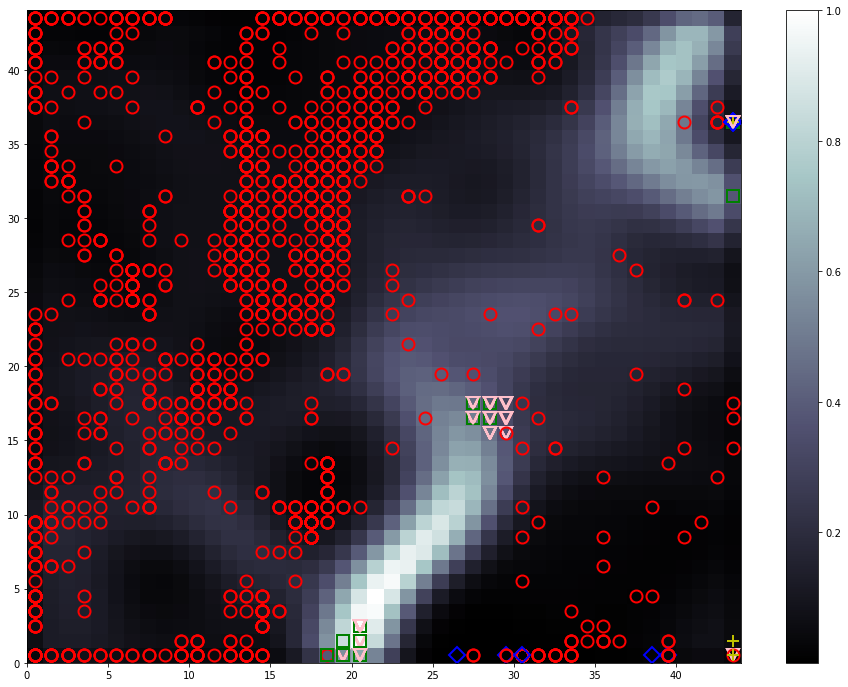

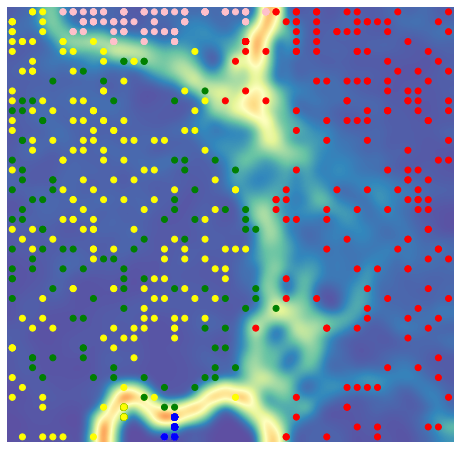

/home/ladin/Projects/research/botnet-traffic-analysis/som_anomaly_detection/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]


sd_benign: 0.05780717597447888, mean_benign: 0.06189077723921634, lim_benign: 0.235312305162653, pct_benign: 0.48185108329241133


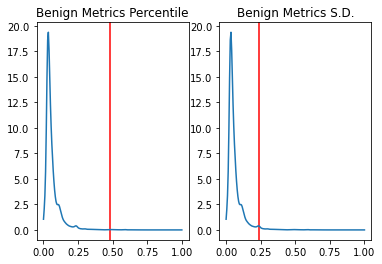

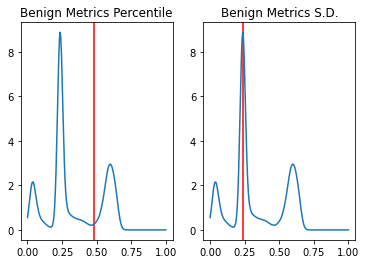

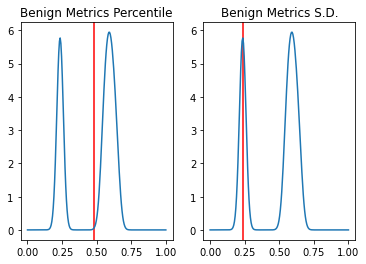

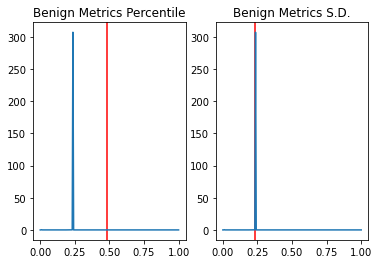

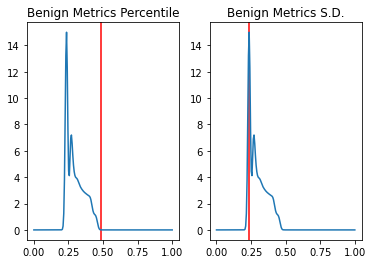

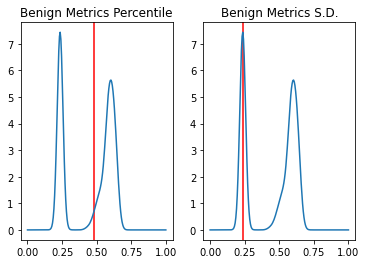

Anomaly detection
benign
Determined:  2.1950000000000003 % as anomaly
all alnomalies
Determined:  83.59666666666666 % as anomaly
ack
Determined:  99.925 % as anomaly
scan
Determined:  99.86 % as anomaly
syn
Determined:  99.94 % as anomaly
udp
Determined:  99.9525 % as anomaly


In [10]:
other_main(choose_folder=nbaiot_20K_data_path, choose_index=1)

(49548, 115) (102195, 115) (107685, 115) (122573, 115) (319647, 115)


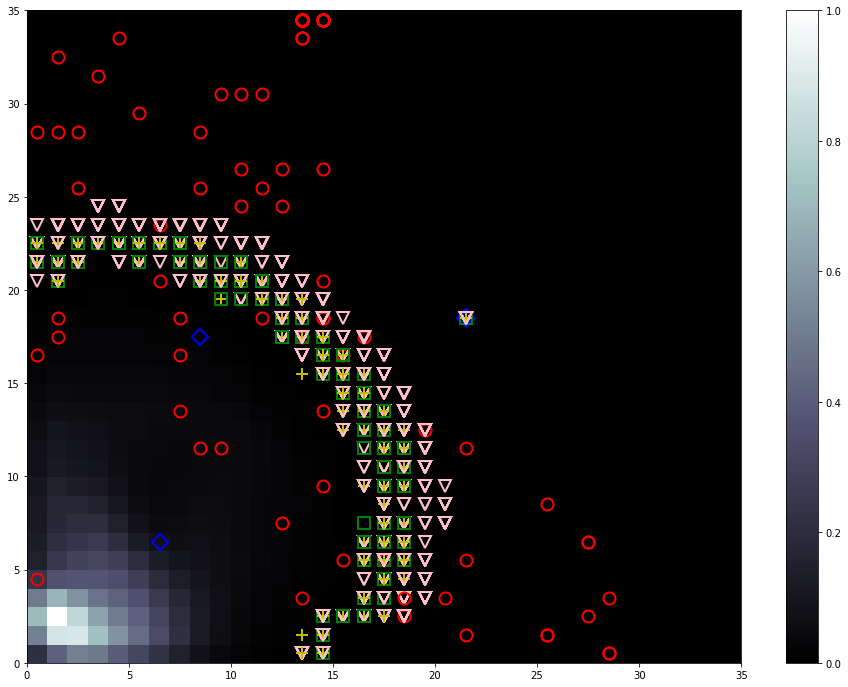

Number of feature:  37
{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-01, 0.00000000e+00, 7.33673264e-04, ...,
        2.29235102e-02, 2.59720056e-01, 2.59449349e-01],
       [2.58530174e-01, 2.56690059e-02, 1.37142545e-03, ...,
        1.61754400e-02, 2.58398546e-01, 2.58067186e-01],
       ...,
       [1.44694605e-01, 5.16361139e-15, 4.25561466e-03, ...,
        5.53790350e-02, 2.04629073e-01, 1.44694605e-01],
       [1.50706396e-01, 5.37814983e-15, 5.90975663e-03, ...,
        5.76609585e-02, 2.13131030e-01, 1.50706396e-01],
       [1.55296912e-01, 5.54196824e-15, 7.61048738e-03, ...,
        5.94223373e-02, 2.19623000e-01, 1.55296912e-01]]), 'learning_rate': 3.433944585318699, 'sigma': 7.158100521954873, 'x': 29.22290214016951}
1.086894079672846
{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],

{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-01, 0.00000000e+00, 7.33673264e-04, ...,
        2.29235102e-02, 2.59720056e-01, 2.59449349e-01],
       [2.58530174e-01, 2.56690059e-02, 1.37142545e-03, ...,
        1.61754400e-02, 2.58398546e-01, 2.58067186e-01],
       ...,
       [1.44694605e-01, 5.16361139e-15, 4.25561466e-03, ...,
        5.53790350e-02, 2.04629073e-01, 1.44694605e-01],
       [1.50706396e-01, 5.37814983e-15, 5.90975663e-03, ...,
        5.76609585e-02, 2.13131030e-01, 1.50706396e-01],
       [1.55296912e-01, 5.54196824e-15, 7.61048738e-03, ...,
        5.94223373e-02, 2.19623000e-01, 1.55296912e-01]]), 'learning_rate': 3.765837040016576, 'sigma': 5.3438506845200475, 'x': 28.49243929443056}
1.0966848929763227
{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-

{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-01, 0.00000000e+00, 7.33673264e-04, ...,
        2.29235102e-02, 2.59720056e-01, 2.59449349e-01],
       [2.58530174e-01, 2.56690059e-02, 1.37142545e-03, ...,
        1.61754400e-02, 2.58398546e-01, 2.58067186e-01],
       ...,
       [1.44694605e-01, 5.16361139e-15, 4.25561466e-03, ...,
        5.53790350e-02, 2.04629073e-01, 1.44694605e-01],
       [1.50706396e-01, 5.37814983e-15, 5.90975663e-03, ...,
        5.76609585e-02, 2.13131030e-01, 1.50706396e-01],
       [1.55296912e-01, 5.54196824e-15, 7.61048738e-03, ...,
        5.94223373e-02, 2.19623000e-01, 1.55296912e-01]]), 'learning_rate': 1.6460446690499553, 'sigma': 6.489759854713604, 'x': 44.288505558612194}
1.0844982817103594
{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e

{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-01, 0.00000000e+00, 7.33673264e-04, ...,
        2.29235102e-02, 2.59720056e-01, 2.59449349e-01],
       [2.58530174e-01, 2.56690059e-02, 1.37142545e-03, ...,
        1.61754400e-02, 2.58398546e-01, 2.58067186e-01],
       ...,
       [1.44694605e-01, 5.16361139e-15, 4.25561466e-03, ...,
        5.53790350e-02, 2.04629073e-01, 1.44694605e-01],
       [1.50706396e-01, 5.37814983e-15, 5.90975663e-03, ...,
        5.76609585e-02, 2.13131030e-01, 1.50706396e-01],
       [1.55296912e-01, 5.54196824e-15, 7.61048738e-03, ...,
        5.94223373e-02, 2.19623000e-01, 1.55296912e-01]]), 'learning_rate': 2.030857340529256, 'sigma': 5.895916691561468, 'x': 49.81152135840837}
1.0542186427442832
{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-0

{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-01, 0.00000000e+00, 7.33673264e-04, ...,
        2.29235102e-02, 2.59720056e-01, 2.59449349e-01],
       [2.58530174e-01, 2.56690059e-02, 1.37142545e-03, ...,
        1.61754400e-02, 2.58398546e-01, 2.58067186e-01],
       ...,
       [1.44694605e-01, 5.16361139e-15, 4.25561466e-03, ...,
        5.53790350e-02, 2.04629073e-01, 1.44694605e-01],
       [1.50706396e-01, 5.37814983e-15, 5.90975663e-03, ...,
        5.76609585e-02, 2.13131030e-01, 1.50706396e-01],
       [1.55296912e-01, 5.54196824e-15, 7.61048738e-03, ...,
        5.94223373e-02, 2.19623000e-01, 1.55296912e-01]]), 'learning_rate': 0.39320435967550516, 'sigma': 9.630171320810428, 'x': 48.116005776681035}
1.0881550350267974
{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335

{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-01, 0.00000000e+00, 7.33673264e-04, ...,
        2.29235102e-02, 2.59720056e-01, 2.59449349e-01],
       [2.58530174e-01, 2.56690059e-02, 1.37142545e-03, ...,
        1.61754400e-02, 2.58398546e-01, 2.58067186e-01],
       ...,
       [1.44694605e-01, 5.16361139e-15, 4.25561466e-03, ...,
        5.53790350e-02, 2.04629073e-01, 1.44694605e-01],
       [1.50706396e-01, 5.37814983e-15, 5.90975663e-03, ...,
        5.76609585e-02, 2.13131030e-01, 1.50706396e-01],
       [1.55296912e-01, 5.54196824e-15, 7.61048738e-03, ...,
        5.94223373e-02, 2.19623000e-01, 1.55296912e-01]]), 'learning_rate': 1.8324004149442255, 'sigma': 6.74729165790281, 'x': 20.266804322052085}
1.1040223815729766
{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-

{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-01, 0.00000000e+00, 7.33673264e-04, ...,
        2.29235102e-02, 2.59720056e-01, 2.59449349e-01],
       [2.58530174e-01, 2.56690059e-02, 1.37142545e-03, ...,
        1.61754400e-02, 2.58398546e-01, 2.58067186e-01],
       ...,
       [1.44694605e-01, 5.16361139e-15, 4.25561466e-03, ...,
        5.53790350e-02, 2.04629073e-01, 1.44694605e-01],
       [1.50706396e-01, 5.37814983e-15, 5.90975663e-03, ...,
        5.76609585e-02, 2.13131030e-01, 1.50706396e-01],
       [1.55296912e-01, 5.54196824e-15, 7.61048738e-03, ...,
        5.94223373e-02, 2.19623000e-01, 1.55296912e-01]]), 'learning_rate': 2.2871382439170587, 'sigma': 8.127589819774526, 'x': 27.721478036639198}
1.0999169334046213
{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e

{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-01, 0.00000000e+00, 7.33673264e-04, ...,
        2.29235102e-02, 2.59720056e-01, 2.59449349e-01],
       [2.58530174e-01, 2.56690059e-02, 1.37142545e-03, ...,
        1.61754400e-02, 2.58398546e-01, 2.58067186e-01],
       ...,
       [1.44694605e-01, 5.16361139e-15, 4.25561466e-03, ...,
        5.53790350e-02, 2.04629073e-01, 1.44694605e-01],
       [1.50706396e-01, 5.37814983e-15, 5.90975663e-03, ...,
        5.76609585e-02, 2.13131030e-01, 1.50706396e-01],
       [1.55296912e-01, 5.54196824e-15, 7.61048738e-03, ...,
        5.94223373e-02, 2.19623000e-01, 1.55296912e-01]]), 'learning_rate': 4.747209355997017, 'sigma': 8.739517026907835, 'x': 43.34753807084519}
1.0812873015050972
{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-0

{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-01, 0.00000000e+00, 7.33673264e-04, ...,
        2.29235102e-02, 2.59720056e-01, 2.59449349e-01],
       [2.58530174e-01, 2.56690059e-02, 1.37142545e-03, ...,
        1.61754400e-02, 2.58398546e-01, 2.58067186e-01],
       ...,
       [1.44694605e-01, 5.16361139e-15, 4.25561466e-03, ...,
        5.53790350e-02, 2.04629073e-01, 1.44694605e-01],
       [1.50706396e-01, 5.37814983e-15, 5.90975663e-03, ...,
        5.76609585e-02, 2.13131030e-01, 1.50706396e-01],
       [1.55296912e-01, 5.54196824e-15, 7.61048738e-03, ...,
        5.94223373e-02, 2.19623000e-01, 1.55296912e-01]]), 'learning_rate': 4.279301564018313, 'sigma': 8.65651253545496, 'x': 45.91552850888306}
1.0496069659767
{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-01, 0

{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-01, 0.00000000e+00, 7.33673264e-04, ...,
        2.29235102e-02, 2.59720056e-01, 2.59449349e-01],
       [2.58530174e-01, 2.56690059e-02, 1.37142545e-03, ...,
        1.61754400e-02, 2.58398546e-01, 2.58067186e-01],
       ...,
       [1.44694605e-01, 5.16361139e-15, 4.25561466e-03, ...,
        5.53790350e-02, 2.04629073e-01, 1.44694605e-01],
       [1.50706396e-01, 5.37814983e-15, 5.90975663e-03, ...,
        5.76609585e-02, 2.13131030e-01, 1.50706396e-01],
       [1.55296912e-01, 5.54196824e-15, 7.61048738e-03, ...,
        5.94223373e-02, 2.19623000e-01, 1.55296912e-01]]), 'learning_rate': 3.820642142955581, 'sigma': 8.86853701403906, 'x': 46.657585706916876}
1.065588334871463
{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-01

{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-01, 0.00000000e+00, 7.33673264e-04, ...,
        2.29235102e-02, 2.59720056e-01, 2.59449349e-01],
       [2.58530174e-01, 2.56690059e-02, 1.37142545e-03, ...,
        1.61754400e-02, 2.58398546e-01, 2.58067186e-01],
       ...,
       [1.44694605e-01, 5.16361139e-15, 4.25561466e-03, ...,
        5.53790350e-02, 2.04629073e-01, 1.44694605e-01],
       [1.50706396e-01, 5.37814983e-15, 5.90975663e-03, ...,
        5.76609585e-02, 2.13131030e-01, 1.50706396e-01],
       [1.55296912e-01, 5.54196824e-15, 7.61048738e-03, ...,
        5.94223373e-02, 2.19623000e-01, 1.55296912e-01]]), 'learning_rate': 3.5116851570772094, 'sigma': 8.807317563661865, 'x': 31.379003087082182}
1.0897285319131194
{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e

{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-01, 0.00000000e+00, 7.33673264e-04, ...,
        2.29235102e-02, 2.59720056e-01, 2.59449349e-01],
       [2.58530174e-01, 2.56690059e-02, 1.37142545e-03, ...,
        1.61754400e-02, 2.58398546e-01, 2.58067186e-01],
       ...,
       [1.44694605e-01, 5.16361139e-15, 4.25561466e-03, ...,
        5.53790350e-02, 2.04629073e-01, 1.44694605e-01],
       [1.50706396e-01, 5.37814983e-15, 5.90975663e-03, ...,
        5.76609585e-02, 2.13131030e-01, 1.50706396e-01],
       [1.55296912e-01, 5.54196824e-15, 7.61048738e-03, ...,
        5.94223373e-02, 2.19623000e-01, 1.55296912e-01]]), 'learning_rate': 2.860802598275666, 'sigma': 9.526277161759023, 'x': 46.45292090170868}
1.0711950690406884
{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-0

{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-01, 0.00000000e+00, 7.33673264e-04, ...,
        2.29235102e-02, 2.59720056e-01, 2.59449349e-01],
       [2.58530174e-01, 2.56690059e-02, 1.37142545e-03, ...,
        1.61754400e-02, 2.58398546e-01, 2.58067186e-01],
       ...,
       [1.44694605e-01, 5.16361139e-15, 4.25561466e-03, ...,
        5.53790350e-02, 2.04629073e-01, 1.44694605e-01],
       [1.50706396e-01, 5.37814983e-15, 5.90975663e-03, ...,
        5.76609585e-02, 2.13131030e-01, 1.50706396e-01],
       [1.55296912e-01, 5.54196824e-15, 7.61048738e-03, ...,
        5.94223373e-02, 2.19623000e-01, 1.55296912e-01]]), 'learning_rate': 1.9445850022738176, 'sigma': 8.312612206901404, 'x': 45.15367347411806}
1.0617103584629342
{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-

{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-01, 0.00000000e+00, 7.33673264e-04, ...,
        2.29235102e-02, 2.59720056e-01, 2.59449349e-01],
       [2.58530174e-01, 2.56690059e-02, 1.37142545e-03, ...,
        1.61754400e-02, 2.58398546e-01, 2.58067186e-01],
       ...,
       [1.44694605e-01, 5.16361139e-15, 4.25561466e-03, ...,
        5.53790350e-02, 2.04629073e-01, 1.44694605e-01],
       [1.50706396e-01, 5.37814983e-15, 5.90975663e-03, ...,
        5.76609585e-02, 2.13131030e-01, 1.50706396e-01],
       [1.55296912e-01, 5.54196824e-15, 7.61048738e-03, ...,
        5.94223373e-02, 2.19623000e-01, 1.55296912e-01]]), 'learning_rate': 4.251109122891043, 'sigma': 8.594810547210912, 'x': 41.276282761968126}
1.0732634843157352
{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-

{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-01, 0.00000000e+00, 7.33673264e-04, ...,
        2.29235102e-02, 2.59720056e-01, 2.59449349e-01],
       [2.58530174e-01, 2.56690059e-02, 1.37142545e-03, ...,
        1.61754400e-02, 2.58398546e-01, 2.58067186e-01],
       ...,
       [1.44694605e-01, 5.16361139e-15, 4.25561466e-03, ...,
        5.53790350e-02, 2.04629073e-01, 1.44694605e-01],
       [1.50706396e-01, 5.37814983e-15, 5.90975663e-03, ...,
        5.76609585e-02, 2.13131030e-01, 1.50706396e-01],
       [1.55296912e-01, 5.54196824e-15, 7.61048738e-03, ...,
        5.94223373e-02, 2.19623000e-01, 1.55296912e-01]]), 'learning_rate': 4.356328559338722, 'sigma': 9.395211040163598, 'x': 49.353635584737226}
1.0830163341835506
{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-

{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-01, 0.00000000e+00, 7.33673264e-04, ...,
        2.29235102e-02, 2.59720056e-01, 2.59449349e-01],
       [2.58530174e-01, 2.56690059e-02, 1.37142545e-03, ...,
        1.61754400e-02, 2.58398546e-01, 2.58067186e-01],
       ...,
       [1.44694605e-01, 5.16361139e-15, 4.25561466e-03, ...,
        5.53790350e-02, 2.04629073e-01, 1.44694605e-01],
       [1.50706396e-01, 5.37814983e-15, 5.90975663e-03, ...,
        5.76609585e-02, 2.13131030e-01, 1.50706396e-01],
       [1.55296912e-01, 5.54196824e-15, 7.61048738e-03, ...,
        5.94223373e-02, 2.19623000e-01, 1.55296912e-01]]), 'learning_rate': 4.205055284163481, 'sigma': 9.615903679764834, 'x': 31.329891822383722}
1.0885975042182392
{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-

{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-01, 0.00000000e+00, 7.33673264e-04, ...,
        2.29235102e-02, 2.59720056e-01, 2.59449349e-01],
       [2.58530174e-01, 2.56690059e-02, 1.37142545e-03, ...,
        1.61754400e-02, 2.58398546e-01, 2.58067186e-01],
       ...,
       [1.44694605e-01, 5.16361139e-15, 4.25561466e-03, ...,
        5.53790350e-02, 2.04629073e-01, 1.44694605e-01],
       [1.50706396e-01, 5.37814983e-15, 5.90975663e-03, ...,
        5.76609585e-02, 2.13131030e-01, 1.50706396e-01],
       [1.55296912e-01, 5.54196824e-15, 7.61048738e-03, ...,
        5.94223373e-02, 2.19623000e-01, 1.55296912e-01]]), 'learning_rate': 2.9645274766578575, 'sigma': 9.170807388759817, 'x': 46.16668259282527}
1.0759089264951038
{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-

{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-01, 0.00000000e+00, 7.33673264e-04, ...,
        2.29235102e-02, 2.59720056e-01, 2.59449349e-01],
       [2.58530174e-01, 2.56690059e-02, 1.37142545e-03, ...,
        1.61754400e-02, 2.58398546e-01, 2.58067186e-01],
       ...,
       [1.44694605e-01, 5.16361139e-15, 4.25561466e-03, ...,
        5.53790350e-02, 2.04629073e-01, 1.44694605e-01],
       [1.50706396e-01, 5.37814983e-15, 5.90975663e-03, ...,
        5.76609585e-02, 2.13131030e-01, 1.50706396e-01],
       [1.55296912e-01, 5.54196824e-15, 7.61048738e-03, ...,
        5.94223373e-02, 2.19623000e-01, 1.55296912e-01]]), 'learning_rate': 2.2776773361042046, 'sigma': 8.684072889910182, 'x': 39.290172711628934}
1.077097680256232
{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-

{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-01, 0.00000000e+00, 7.33673264e-04, ...,
        2.29235102e-02, 2.59720056e-01, 2.59449349e-01],
       [2.58530174e-01, 2.56690059e-02, 1.37142545e-03, ...,
        1.61754400e-02, 2.58398546e-01, 2.58067186e-01],
       ...,
       [1.44694605e-01, 5.16361139e-15, 4.25561466e-03, ...,
        5.53790350e-02, 2.04629073e-01, 1.44694605e-01],
       [1.50706396e-01, 5.37814983e-15, 5.90975663e-03, ...,
        5.76609585e-02, 2.13131030e-01, 1.50706396e-01],
       [1.55296912e-01, 5.54196824e-15, 7.61048738e-03, ...,
        5.94223373e-02, 2.19623000e-01, 1.55296912e-01]]), 'learning_rate': 3.025379474006436, 'sigma': 9.159617377754886, 'x': 38.910372034297744}
1.0833292751188228
{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-

{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-01, 0.00000000e+00, 7.33673264e-04, ...,
        2.29235102e-02, 2.59720056e-01, 2.59449349e-01],
       [2.58530174e-01, 2.56690059e-02, 1.37142545e-03, ...,
        1.61754400e-02, 2.58398546e-01, 2.58067186e-01],
       ...,
       [1.44694605e-01, 5.16361139e-15, 4.25561466e-03, ...,
        5.53790350e-02, 2.04629073e-01, 1.44694605e-01],
       [1.50706396e-01, 5.37814983e-15, 5.90975663e-03, ...,
        5.76609585e-02, 2.13131030e-01, 1.50706396e-01],
       [1.55296912e-01, 5.54196824e-15, 7.61048738e-03, ...,
        5.94223373e-02, 2.19623000e-01, 1.55296912e-01]]), 'learning_rate': 1.6419752526592486, 'sigma': 9.429990955770734, 'x': 40.67867271252069}
1.080116014046126
{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-0

{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-01, 0.00000000e+00, 7.33673264e-04, ...,
        2.29235102e-02, 2.59720056e-01, 2.59449349e-01],
       [2.58530174e-01, 2.56690059e-02, 1.37142545e-03, ...,
        1.61754400e-02, 2.58398546e-01, 2.58067186e-01],
       ...,
       [1.44694605e-01, 5.16361139e-15, 4.25561466e-03, ...,
        5.53790350e-02, 2.04629073e-01, 1.44694605e-01],
       [1.50706396e-01, 5.37814983e-15, 5.90975663e-03, ...,
        5.76609585e-02, 2.13131030e-01, 1.50706396e-01],
       [1.55296912e-01, 5.54196824e-15, 7.61048738e-03, ...,
        5.94223373e-02, 2.19623000e-01, 1.55296912e-01]]), 'learning_rate': 4.678327468119413, 'sigma': 8.63193677200774, 'x': 46.37690391168449}
1.0613722705539537
{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-01

{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-01, 0.00000000e+00, 7.33673264e-04, ...,
        2.29235102e-02, 2.59720056e-01, 2.59449349e-01],
       [2.58530174e-01, 2.56690059e-02, 1.37142545e-03, ...,
        1.61754400e-02, 2.58398546e-01, 2.58067186e-01],
       ...,
       [1.44694605e-01, 5.16361139e-15, 4.25561466e-03, ...,
        5.53790350e-02, 2.04629073e-01, 1.44694605e-01],
       [1.50706396e-01, 5.37814983e-15, 5.90975663e-03, ...,
        5.76609585e-02, 2.13131030e-01, 1.50706396e-01],
       [1.55296912e-01, 5.54196824e-15, 7.61048738e-03, ...,
        5.94223373e-02, 2.19623000e-01, 1.55296912e-01]]), 'learning_rate': 4.392544696523578, 'sigma': 8.42218394403801, 'x': 44.30938872195068}
1.0944925825145915
{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-01

{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-01, 0.00000000e+00, 7.33673264e-04, ...,
        2.29235102e-02, 2.59720056e-01, 2.59449349e-01],
       [2.58530174e-01, 2.56690059e-02, 1.37142545e-03, ...,
        1.61754400e-02, 2.58398546e-01, 2.58067186e-01],
       ...,
       [1.44694605e-01, 5.16361139e-15, 4.25561466e-03, ...,
        5.53790350e-02, 2.04629073e-01, 1.44694605e-01],
       [1.50706396e-01, 5.37814983e-15, 5.90975663e-03, ...,
        5.76609585e-02, 2.13131030e-01, 1.50706396e-01],
       [1.55296912e-01, 5.54196824e-15, 7.61048738e-03, ...,
        5.94223373e-02, 2.19623000e-01, 1.55296912e-01]]), 'learning_rate': 3.350410783709918, 'sigma': 8.952950059934718, 'x': 43.93869043051699}
1.089838816343813
{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-01

{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-01, 0.00000000e+00, 7.33673264e-04, ...,
        2.29235102e-02, 2.59720056e-01, 2.59449349e-01],
       [2.58530174e-01, 2.56690059e-02, 1.37142545e-03, ...,
        1.61754400e-02, 2.58398546e-01, 2.58067186e-01],
       ...,
       [1.44694605e-01, 5.16361139e-15, 4.25561466e-03, ...,
        5.53790350e-02, 2.04629073e-01, 1.44694605e-01],
       [1.50706396e-01, 5.37814983e-15, 5.90975663e-03, ...,
        5.76609585e-02, 2.13131030e-01, 1.50706396e-01],
       [1.55296912e-01, 5.54196824e-15, 7.61048738e-03, ...,
        5.94223373e-02, 2.19623000e-01, 1.55296912e-01]]), 'learning_rate': 2.8404951201222617, 'sigma': 9.865103296906405, 'x': 46.67431389248607}
1.073123682215071
{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-0

{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-01, 0.00000000e+00, 7.33673264e-04, ...,
        2.29235102e-02, 2.59720056e-01, 2.59449349e-01],
       [2.58530174e-01, 2.56690059e-02, 1.37142545e-03, ...,
        1.61754400e-02, 2.58398546e-01, 2.58067186e-01],
       ...,
       [1.44694605e-01, 5.16361139e-15, 4.25561466e-03, ...,
        5.53790350e-02, 2.04629073e-01, 1.44694605e-01],
       [1.50706396e-01, 5.37814983e-15, 5.90975663e-03, ...,
        5.76609585e-02, 2.13131030e-01, 1.50706396e-01],
       [1.55296912e-01, 5.54196824e-15, 7.61048738e-03, ...,
        5.94223373e-02, 2.19623000e-01, 1.55296912e-01]]), 'learning_rate': 2.504225556717399, 'sigma': 8.092458980502075, 'x': 32.48915742535735}
1.0992860130149753
{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-0

{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-01, 0.00000000e+00, 7.33673264e-04, ...,
        2.29235102e-02, 2.59720056e-01, 2.59449349e-01],
       [2.58530174e-01, 2.56690059e-02, 1.37142545e-03, ...,
        1.61754400e-02, 2.58398546e-01, 2.58067186e-01],
       ...,
       [1.44694605e-01, 5.16361139e-15, 4.25561466e-03, ...,
        5.53790350e-02, 2.04629073e-01, 1.44694605e-01],
       [1.50706396e-01, 5.37814983e-15, 5.90975663e-03, ...,
        5.76609585e-02, 2.13131030e-01, 1.50706396e-01],
       [1.55296912e-01, 5.54196824e-15, 7.61048738e-03, ...,
        5.94223373e-02, 2.19623000e-01, 1.55296912e-01]]), 'learning_rate': 4.576481634934467, 'sigma': 9.049872491265303, 'x': 46.65230063159886}
1.0697445600916402
{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-0

{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-01, 0.00000000e+00, 7.33673264e-04, ...,
        2.29235102e-02, 2.59720056e-01, 2.59449349e-01],
       [2.58530174e-01, 2.56690059e-02, 1.37142545e-03, ...,
        1.61754400e-02, 2.58398546e-01, 2.58067186e-01],
       ...,
       [1.44694605e-01, 5.16361139e-15, 4.25561466e-03, ...,
        5.53790350e-02, 2.04629073e-01, 1.44694605e-01],
       [1.50706396e-01, 5.37814983e-15, 5.90975663e-03, ...,
        5.76609585e-02, 2.13131030e-01, 1.50706396e-01],
       [1.55296912e-01, 5.54196824e-15, 7.61048738e-03, ...,
        5.94223373e-02, 2.19623000e-01, 1.55296912e-01]]), 'learning_rate': 4.378542244838847, 'sigma': 8.975193548279154, 'x': 44.864094414778144}
1.07588114967701
{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-01

{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-01, 0.00000000e+00, 7.33673264e-04, ...,
        2.29235102e-02, 2.59720056e-01, 2.59449349e-01],
       [2.58530174e-01, 2.56690059e-02, 1.37142545e-03, ...,
        1.61754400e-02, 2.58398546e-01, 2.58067186e-01],
       ...,
       [1.44694605e-01, 5.16361139e-15, 4.25561466e-03, ...,
        5.53790350e-02, 2.04629073e-01, 1.44694605e-01],
       [1.50706396e-01, 5.37814983e-15, 5.90975663e-03, ...,
        5.76609585e-02, 2.13131030e-01, 1.50706396e-01],
       [1.55296912e-01, 5.54196824e-15, 7.61048738e-03, ...,
        5.94223373e-02, 2.19623000e-01, 1.55296912e-01]]), 'learning_rate': 3.433648226605315, 'sigma': 9.626156947407587, 'x': 46.14904194507441}
1.0782293750422318
{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-0

{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-01, 0.00000000e+00, 7.33673264e-04, ...,
        2.29235102e-02, 2.59720056e-01, 2.59449349e-01],
       [2.58530174e-01, 2.56690059e-02, 1.37142545e-03, ...,
        1.61754400e-02, 2.58398546e-01, 2.58067186e-01],
       ...,
       [1.44694605e-01, 5.16361139e-15, 4.25561466e-03, ...,
        5.53790350e-02, 2.04629073e-01, 1.44694605e-01],
       [1.50706396e-01, 5.37814983e-15, 5.90975663e-03, ...,
        5.76609585e-02, 2.13131030e-01, 1.50706396e-01],
       [1.55296912e-01, 5.54196824e-15, 7.61048738e-03, ...,
        5.94223373e-02, 2.19623000e-01, 1.55296912e-01]]), 'learning_rate': 4.9856385620533, 'sigma': 9.720165262950877, 'x': 46.851046563357514}
1.0761432357391416
{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-01

{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-01, 0.00000000e+00, 7.33673264e-04, ...,
        2.29235102e-02, 2.59720056e-01, 2.59449349e-01],
       [2.58530174e-01, 2.56690059e-02, 1.37142545e-03, ...,
        1.61754400e-02, 2.58398546e-01, 2.58067186e-01],
       ...,
       [1.44694605e-01, 5.16361139e-15, 4.25561466e-03, ...,
        5.53790350e-02, 2.04629073e-01, 1.44694605e-01],
       [1.50706396e-01, 5.37814983e-15, 5.90975663e-03, ...,
        5.76609585e-02, 2.13131030e-01, 1.50706396e-01],
       [1.55296912e-01, 5.54196824e-15, 7.61048738e-03, ...,
        5.94223373e-02, 2.19623000e-01, 1.55296912e-01]]), 'learning_rate': 4.530732462651757, 'sigma': 9.422238713332609, 'x': 42.261391390626535}
1.0698719885841035
{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-

{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-01, 0.00000000e+00, 7.33673264e-04, ...,
        2.29235102e-02, 2.59720056e-01, 2.59449349e-01],
       [2.58530174e-01, 2.56690059e-02, 1.37142545e-03, ...,
        1.61754400e-02, 2.58398546e-01, 2.58067186e-01],
       ...,
       [1.44694605e-01, 5.16361139e-15, 4.25561466e-03, ...,
        5.53790350e-02, 2.04629073e-01, 1.44694605e-01],
       [1.50706396e-01, 5.37814983e-15, 5.90975663e-03, ...,
        5.76609585e-02, 2.13131030e-01, 1.50706396e-01],
       [1.55296912e-01, 5.54196824e-15, 7.61048738e-03, ...,
        5.94223373e-02, 2.19623000e-01, 1.55296912e-01]]), 'learning_rate': 3.559902558740023, 'sigma': 7.265626449482116, 'x': 46.39973768485807}
1.0774253308814175
{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-0

{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-01, 0.00000000e+00, 7.33673264e-04, ...,
        2.29235102e-02, 2.59720056e-01, 2.59449349e-01],
       [2.58530174e-01, 2.56690059e-02, 1.37142545e-03, ...,
        1.61754400e-02, 2.58398546e-01, 2.58067186e-01],
       ...,
       [1.44694605e-01, 5.16361139e-15, 4.25561466e-03, ...,
        5.53790350e-02, 2.04629073e-01, 1.44694605e-01],
       [1.50706396e-01, 5.37814983e-15, 5.90975663e-03, ...,
        5.76609585e-02, 2.13131030e-01, 1.50706396e-01],
       [1.55296912e-01, 5.54196824e-15, 7.61048738e-03, ...,
        5.94223373e-02, 2.19623000e-01, 1.55296912e-01]]), 'learning_rate': 2.7513589722543372, 'sigma': 9.096588080547306, 'x': 33.51637569984768}
1.081516344279694
{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-0

{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-01, 0.00000000e+00, 7.33673264e-04, ...,
        2.29235102e-02, 2.59720056e-01, 2.59449349e-01],
       [2.58530174e-01, 2.56690059e-02, 1.37142545e-03, ...,
        1.61754400e-02, 2.58398546e-01, 2.58067186e-01],
       ...,
       [1.44694605e-01, 5.16361139e-15, 4.25561466e-03, ...,
        5.53790350e-02, 2.04629073e-01, 1.44694605e-01],
       [1.50706396e-01, 5.37814983e-15, 5.90975663e-03, ...,
        5.76609585e-02, 2.13131030e-01, 1.50706396e-01],
       [1.55296912e-01, 5.54196824e-15, 7.61048738e-03, ...,
        5.94223373e-02, 2.19623000e-01, 1.55296912e-01]]), 'learning_rate': 4.302967627831777, 'sigma': 8.691506974765577, 'x': 49.981838425723474}
1.0564111892575674
{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-

{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-01, 0.00000000e+00, 7.33673264e-04, ...,
        2.29235102e-02, 2.59720056e-01, 2.59449349e-01],
       [2.58530174e-01, 2.56690059e-02, 1.37142545e-03, ...,
        1.61754400e-02, 2.58398546e-01, 2.58067186e-01],
       ...,
       [1.44694605e-01, 5.16361139e-15, 4.25561466e-03, ...,
        5.53790350e-02, 2.04629073e-01, 1.44694605e-01],
       [1.50706396e-01, 5.37814983e-15, 5.90975663e-03, ...,
        5.76609585e-02, 2.13131030e-01, 1.50706396e-01],
       [1.55296912e-01, 5.54196824e-15, 7.61048738e-03, ...,
        5.94223373e-02, 2.19623000e-01, 1.55296912e-01]]), 'learning_rate': 3.258071395940797, 'sigma': 7.963406597345168, 'x': 46.59704278680112}
1.0650428556818743
{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-0

{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-01, 0.00000000e+00, 7.33673264e-04, ...,
        2.29235102e-02, 2.59720056e-01, 2.59449349e-01],
       [2.58530174e-01, 2.56690059e-02, 1.37142545e-03, ...,
        1.61754400e-02, 2.58398546e-01, 2.58067186e-01],
       ...,
       [1.44694605e-01, 5.16361139e-15, 4.25561466e-03, ...,
        5.53790350e-02, 2.04629073e-01, 1.44694605e-01],
       [1.50706396e-01, 5.37814983e-15, 5.90975663e-03, ...,
        5.76609585e-02, 2.13131030e-01, 1.50706396e-01],
       [1.55296912e-01, 5.54196824e-15, 7.61048738e-03, ...,
        5.94223373e-02, 2.19623000e-01, 1.55296912e-01]]), 'learning_rate': 3.05283800341529, 'sigma': 9.336270502811272, 'x': 48.183073362922634}
1.07800153266253
{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-01,

{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-01, 0.00000000e+00, 7.33673264e-04, ...,
        2.29235102e-02, 2.59720056e-01, 2.59449349e-01],
       [2.58530174e-01, 2.56690059e-02, 1.37142545e-03, ...,
        1.61754400e-02, 2.58398546e-01, 2.58067186e-01],
       ...,
       [1.44694605e-01, 5.16361139e-15, 4.25561466e-03, ...,
        5.53790350e-02, 2.04629073e-01, 1.44694605e-01],
       [1.50706396e-01, 5.37814983e-15, 5.90975663e-03, ...,
        5.76609585e-02, 2.13131030e-01, 1.50706396e-01],
       [1.55296912e-01, 5.54196824e-15, 7.61048738e-03, ...,
        5.94223373e-02, 2.19623000e-01, 1.55296912e-01]]), 'learning_rate': 2.347961065222559, 'sigma': 9.452895093265608, 'x': 37.82315417074255}
1.0827688909302322
{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-0

{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-01, 0.00000000e+00, 7.33673264e-04, ...,
        2.29235102e-02, 2.59720056e-01, 2.59449349e-01],
       [2.58530174e-01, 2.56690059e-02, 1.37142545e-03, ...,
        1.61754400e-02, 2.58398546e-01, 2.58067186e-01],
       ...,
       [1.44694605e-01, 5.16361139e-15, 4.25561466e-03, ...,
        5.53790350e-02, 2.04629073e-01, 1.44694605e-01],
       [1.50706396e-01, 5.37814983e-15, 5.90975663e-03, ...,
        5.76609585e-02, 2.13131030e-01, 1.50706396e-01],
       [1.55296912e-01, 5.54196824e-15, 7.61048738e-03, ...,
        5.94223373e-02, 2.19623000e-01, 1.55296912e-01]]), 'learning_rate': 0.05722223342609256, 'sigma': 9.238999175624317, 'x': 30.68822867909855}
1.0770303265971035
{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e

{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-01, 0.00000000e+00, 7.33673264e-04, ...,
        2.29235102e-02, 2.59720056e-01, 2.59449349e-01],
       [2.58530174e-01, 2.56690059e-02, 1.37142545e-03, ...,
        1.61754400e-02, 2.58398546e-01, 2.58067186e-01],
       ...,
       [1.44694605e-01, 5.16361139e-15, 4.25561466e-03, ...,
        5.53790350e-02, 2.04629073e-01, 1.44694605e-01],
       [1.50706396e-01, 5.37814983e-15, 5.90975663e-03, ...,
        5.76609585e-02, 2.13131030e-01, 1.50706396e-01],
       [1.55296912e-01, 5.54196824e-15, 7.61048738e-03, ...,
        5.94223373e-02, 2.19623000e-01, 1.55296912e-01]]), 'learning_rate': 3.3968270568967345, 'sigma': 8.886571137159418, 'x': 42.20389509626158}
1.0805039275623836
{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-

{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-01, 0.00000000e+00, 7.33673264e-04, ...,
        2.29235102e-02, 2.59720056e-01, 2.59449349e-01],
       [2.58530174e-01, 2.56690059e-02, 1.37142545e-03, ...,
        1.61754400e-02, 2.58398546e-01, 2.58067186e-01],
       ...,
       [1.44694605e-01, 5.16361139e-15, 4.25561466e-03, ...,
        5.53790350e-02, 2.04629073e-01, 1.44694605e-01],
       [1.50706396e-01, 5.37814983e-15, 5.90975663e-03, ...,
        5.76609585e-02, 2.13131030e-01, 1.50706396e-01],
       [1.55296912e-01, 5.54196824e-15, 7.61048738e-03, ...,
        5.94223373e-02, 2.19623000e-01, 1.55296912e-01]]), 'learning_rate': 2.1679829803714905, 'sigma': 6.958868408381506, 'x': 35.01291504531626}
1.090656612912157
{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-0

{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-01, 0.00000000e+00, 7.33673264e-04, ...,
        2.29235102e-02, 2.59720056e-01, 2.59449349e-01],
       [2.58530174e-01, 2.56690059e-02, 1.37142545e-03, ...,
        1.61754400e-02, 2.58398546e-01, 2.58067186e-01],
       ...,
       [1.44694605e-01, 5.16361139e-15, 4.25561466e-03, ...,
        5.53790350e-02, 2.04629073e-01, 1.44694605e-01],
       [1.50706396e-01, 5.37814983e-15, 5.90975663e-03, ...,
        5.76609585e-02, 2.13131030e-01, 1.50706396e-01],
       [1.55296912e-01, 5.54196824e-15, 7.61048738e-03, ...,
        5.94223373e-02, 2.19623000e-01, 1.55296912e-01]]), 'learning_rate': 3.124967129421722, 'sigma': 8.122582002524421, 'x': 36.25393420812435}
1.0710988140072462
{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-0

{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-01, 0.00000000e+00, 7.33673264e-04, ...,
        2.29235102e-02, 2.59720056e-01, 2.59449349e-01],
       [2.58530174e-01, 2.56690059e-02, 1.37142545e-03, ...,
        1.61754400e-02, 2.58398546e-01, 2.58067186e-01],
       ...,
       [1.44694605e-01, 5.16361139e-15, 4.25561466e-03, ...,
        5.53790350e-02, 2.04629073e-01, 1.44694605e-01],
       [1.50706396e-01, 5.37814983e-15, 5.90975663e-03, ...,
        5.76609585e-02, 2.13131030e-01, 1.50706396e-01],
       [1.55296912e-01, 5.54196824e-15, 7.61048738e-03, ...,
        5.94223373e-02, 2.19623000e-01, 1.55296912e-01]]), 'learning_rate': 2.785886534135532, 'sigma': 9.20194328603197, 'x': 31.73716491271098}
1.07060607204918
{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-01, 

{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-01, 0.00000000e+00, 7.33673264e-04, ...,
        2.29235102e-02, 2.59720056e-01, 2.59449349e-01],
       [2.58530174e-01, 2.56690059e-02, 1.37142545e-03, ...,
        1.61754400e-02, 2.58398546e-01, 2.58067186e-01],
       ...,
       [1.44694605e-01, 5.16361139e-15, 4.25561466e-03, ...,
        5.53790350e-02, 2.04629073e-01, 1.44694605e-01],
       [1.50706396e-01, 5.37814983e-15, 5.90975663e-03, ...,
        5.76609585e-02, 2.13131030e-01, 1.50706396e-01],
       [1.55296912e-01, 5.54196824e-15, 7.61048738e-03, ...,
        5.94223373e-02, 2.19623000e-01, 1.55296912e-01]]), 'learning_rate': 2.6236424858434364, 'sigma': 8.490053287587264, 'x': 46.15624647882835}
1.0722706795827923
{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-

{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-01, 0.00000000e+00, 7.33673264e-04, ...,
        2.29235102e-02, 2.59720056e-01, 2.59449349e-01],
       [2.58530174e-01, 2.56690059e-02, 1.37142545e-03, ...,
        1.61754400e-02, 2.58398546e-01, 2.58067186e-01],
       ...,
       [1.44694605e-01, 5.16361139e-15, 4.25561466e-03, ...,
        5.53790350e-02, 2.04629073e-01, 1.44694605e-01],
       [1.50706396e-01, 5.37814983e-15, 5.90975663e-03, ...,
        5.76609585e-02, 2.13131030e-01, 1.50706396e-01],
       [1.55296912e-01, 5.54196824e-15, 7.61048738e-03, ...,
        5.94223373e-02, 2.19623000e-01, 1.55296912e-01]]), 'learning_rate': 3.6413107241683074, 'sigma': 8.855872886236696, 'x': 44.67393467462245}
1.0683805931712693
{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-

{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-01, 0.00000000e+00, 7.33673264e-04, ...,
        2.29235102e-02, 2.59720056e-01, 2.59449349e-01],
       [2.58530174e-01, 2.56690059e-02, 1.37142545e-03, ...,
        1.61754400e-02, 2.58398546e-01, 2.58067186e-01],
       ...,
       [1.44694605e-01, 5.16361139e-15, 4.25561466e-03, ...,
        5.53790350e-02, 2.04629073e-01, 1.44694605e-01],
       [1.50706396e-01, 5.37814983e-15, 5.90975663e-03, ...,
        5.76609585e-02, 2.13131030e-01, 1.50706396e-01],
       [1.55296912e-01, 5.54196824e-15, 7.61048738e-03, ...,
        5.94223373e-02, 2.19623000e-01, 1.55296912e-01]]), 'learning_rate': 3.120334283768031, 'sigma': 8.698413754675903, 'x': 41.18121022714936}
1.0995526366305917
{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-0

{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-01, 0.00000000e+00, 7.33673264e-04, ...,
        2.29235102e-02, 2.59720056e-01, 2.59449349e-01],
       [2.58530174e-01, 2.56690059e-02, 1.37142545e-03, ...,
        1.61754400e-02, 2.58398546e-01, 2.58067186e-01],
       ...,
       [1.44694605e-01, 5.16361139e-15, 4.25561466e-03, ...,
        5.53790350e-02, 2.04629073e-01, 1.44694605e-01],
       [1.50706396e-01, 5.37814983e-15, 5.90975663e-03, ...,
        5.76609585e-02, 2.13131030e-01, 1.50706396e-01],
       [1.55296912e-01, 5.54196824e-15, 7.61048738e-03, ...,
        5.94223373e-02, 2.19623000e-01, 1.55296912e-01]]), 'learning_rate': 3.7099693149154964, 'sigma': 7.50351459013236, 'x': 40.56341102464178}
1.0717016173294858
{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-0

{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-01, 0.00000000e+00, 7.33673264e-04, ...,
        2.29235102e-02, 2.59720056e-01, 2.59449349e-01],
       [2.58530174e-01, 2.56690059e-02, 1.37142545e-03, ...,
        1.61754400e-02, 2.58398546e-01, 2.58067186e-01],
       ...,
       [1.44694605e-01, 5.16361139e-15, 4.25561466e-03, ...,
        5.53790350e-02, 2.04629073e-01, 1.44694605e-01],
       [1.50706396e-01, 5.37814983e-15, 5.90975663e-03, ...,
        5.76609585e-02, 2.13131030e-01, 1.50706396e-01],
       [1.55296912e-01, 5.54196824e-15, 7.61048738e-03, ...,
        5.94223373e-02, 2.19623000e-01, 1.55296912e-01]]), 'learning_rate': 2.911596970505003, 'sigma': 8.801255473587256, 'x': 45.873741677030424}
1.0564068329290064
{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-

{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-01, 0.00000000e+00, 7.33673264e-04, ...,
        2.29235102e-02, 2.59720056e-01, 2.59449349e-01],
       [2.58530174e-01, 2.56690059e-02, 1.37142545e-03, ...,
        1.61754400e-02, 2.58398546e-01, 2.58067186e-01],
       ...,
       [1.44694605e-01, 5.16361139e-15, 4.25561466e-03, ...,
        5.53790350e-02, 2.04629073e-01, 1.44694605e-01],
       [1.50706396e-01, 5.37814983e-15, 5.90975663e-03, ...,
        5.76609585e-02, 2.13131030e-01, 1.50706396e-01],
       [1.55296912e-01, 5.54196824e-15, 7.61048738e-03, ...,
        5.94223373e-02, 2.19623000e-01, 1.55296912e-01]]), 'learning_rate': 3.092279590283653, 'sigma': 7.37409500264564, 'x': 46.551391982078094}
1.0689759276406061
{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-0

{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-01, 0.00000000e+00, 7.33673264e-04, ...,
        2.29235102e-02, 2.59720056e-01, 2.59449349e-01],
       [2.58530174e-01, 2.56690059e-02, 1.37142545e-03, ...,
        1.61754400e-02, 2.58398546e-01, 2.58067186e-01],
       ...,
       [1.44694605e-01, 5.16361139e-15, 4.25561466e-03, ...,
        5.53790350e-02, 2.04629073e-01, 1.44694605e-01],
       [1.50706396e-01, 5.37814983e-15, 5.90975663e-03, ...,
        5.76609585e-02, 2.13131030e-01, 1.50706396e-01],
       [1.55296912e-01, 5.54196824e-15, 7.61048738e-03, ...,
        5.94223373e-02, 2.19623000e-01, 1.55296912e-01]]), 'learning_rate': 2.1986011121161884, 'sigma': 6.209983452236621, 'x': 48.00842677677451}
1.0833352774482958
{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-

{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-01, 0.00000000e+00, 7.33673264e-04, ...,
        2.29235102e-02, 2.59720056e-01, 2.59449349e-01],
       [2.58530174e-01, 2.56690059e-02, 1.37142545e-03, ...,
        1.61754400e-02, 2.58398546e-01, 2.58067186e-01],
       ...,
       [1.44694605e-01, 5.16361139e-15, 4.25561466e-03, ...,
        5.53790350e-02, 2.04629073e-01, 1.44694605e-01],
       [1.50706396e-01, 5.37814983e-15, 5.90975663e-03, ...,
        5.76609585e-02, 2.13131030e-01, 1.50706396e-01],
       [1.55296912e-01, 5.54196824e-15, 7.61048738e-03, ...,
        5.94223373e-02, 2.19623000e-01, 1.55296912e-01]]), 'learning_rate': 2.8158754580931653, 'sigma': 6.5625837329394825, 'x': 25.6921750849633}
1.122126085039109
{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-0

{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-01, 0.00000000e+00, 7.33673264e-04, ...,
        2.29235102e-02, 2.59720056e-01, 2.59449349e-01],
       [2.58530174e-01, 2.56690059e-02, 1.37142545e-03, ...,
        1.61754400e-02, 2.58398546e-01, 2.58067186e-01],
       ...,
       [1.44694605e-01, 5.16361139e-15, 4.25561466e-03, ...,
        5.53790350e-02, 2.04629073e-01, 1.44694605e-01],
       [1.50706396e-01, 5.37814983e-15, 5.90975663e-03, ...,
        5.76609585e-02, 2.13131030e-01, 1.50706396e-01],
       [1.55296912e-01, 5.54196824e-15, 7.61048738e-03, ...,
        5.94223373e-02, 2.19623000e-01, 1.55296912e-01]]), 'learning_rate': 1.472748200365425, 'sigma': 9.668724271347662, 'x': 44.86956303343874}
1.065567927991828
{'data_benign': array([[1.99247946e-08, 0.00000000e+00, 3.32079910e-10, ...,
        5.00000000e-01, 1.99247946e-08, 1.99247946e-08],
       [2.59720335e-01

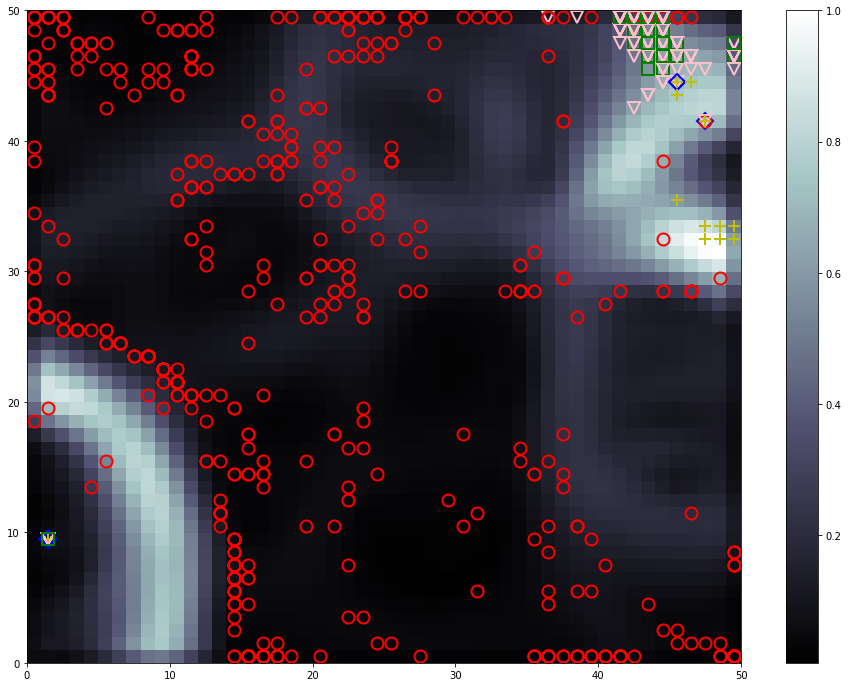

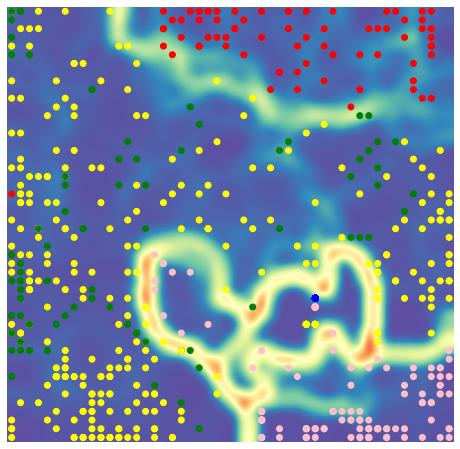

/home/ladin/Projects/research/botnet-traffic-analysis/som_anomaly_detection/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]


sd_benign: 0.0751232532723091, mean_benign: 0.06729765307533533, lim_benign: 0.2926674128922626, pct_benign: 0.5482059345010705


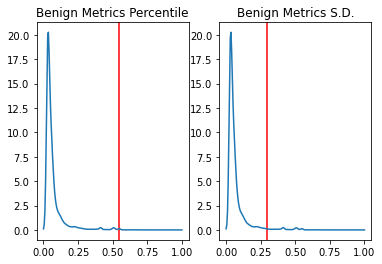

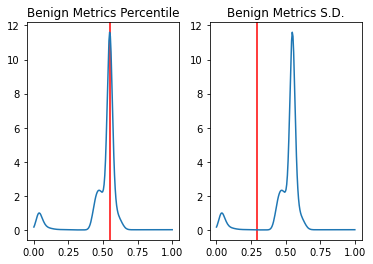

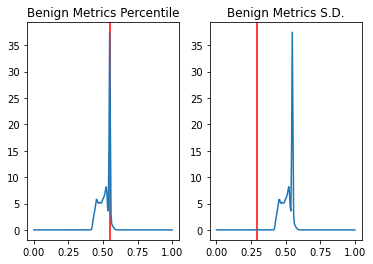

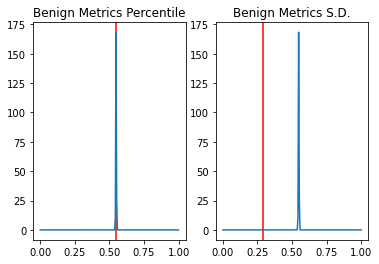

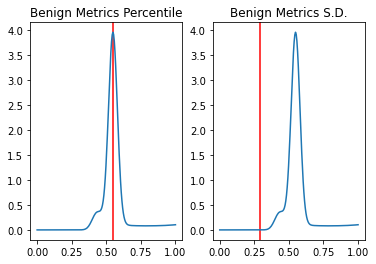

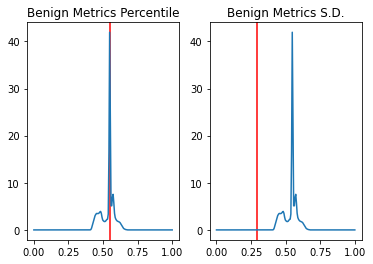

Anomaly detection
benign
Determined:  2.540970372164366 % as anomaly
all alnomalies
Determined:  93.11421111440494 % as anomaly
ack
Determined:  100.0 % as anomaly
scan
Determined:  100.0 % as anomaly
syn
Determined:  100.0 % as anomaly
udp
Determined:  100.0 % as anomaly


In [11]:
other_main(choose_folder=nbaiot_data_path, choose_index=1)